# Citation Intent Classification - XLNet_BASE_CASED

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A survey of methodologies for Citation Intent Classification
#### Brief description of the task
The aim of this project is to walk through the building of a Machine Learning model capable of classifying citation intents in scientific papers.

I will make use of a Pre-trained language model (PLM) to build a meaningful comparison between some of the different techniques that could be used to produce the final outcome, in order to investigate which works better for the task.

The techniques I aim to compare are:
- The fine-tuning of a PLM;
- The construction of an ensemble multi-class classifier based on binary classifiers.

#### Requirements

Download additional libraries and modules.

In [ ]:
!pip install transformers datasets scikit-learn accelerate ray[tune]==2.9.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.4 MB/s eta 0:00:00


Below you will find all the necessary imports for the project, together with the version of the main libraries.

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno
import seaborn as sns
import sklearn
import tensorflow as tf
import datasets
from datasets import load_dataset
import random
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

print(f"Python Version: {sys.version}\n\nMain libraries of the project:\n")
print(f"- NumPy Version: {np.__version__}")
print(f"- Pandas Version: {pd.__version__}")
print(f"- Matplotlib Version: {mpl.__version__}")
print(f"- Seaborn Version: {sns.__version__}")
print(f"- Scikit-learn Version: {sklearn.__version__}")
print(f"- TensorFlow Version: {tf.__version__}")
print(f"- PyTorch Version: {torch.__version__}")
print(f"- Datasets Version: {datasets.__version__}")
print(f"- Transformers Version: {transformers.__version__}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Main libraries of the project:

- NumPy Version: 1.23.5
- Pandas Version: 1.5.3
- Matplotlib Version: 3.7.1
- Seaborn Version: 0.13.1
- Scikit-learn Version: 1.2.2
- TensorFlow Version: 2.15.0
- PyTorch Version: 2.1.0+cu121
- Datasets Version: 2.16.1
- Transformers Version: 4.35.2


Retrieve GPU device for PyTorch based operations

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset loading and inspection

Below, I download the SciCite dataset directly from the datasets library provided by Huggingface. The dataset will be stored inside a dict-like object yet splitted, consistently with the benchmark dataset, into train, validation and test sets.

In [ ]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1859 [00:00<?, ? examples/s]

Here I print some information about the dataset we are using. Mainly, we get a brief description of it, as well as the link to access the original dataset.

In [ ]:
print(dataset['train'].description, '\n\n')
print(dataset['train'].homepage)


This is a dataset for classifying citation intents in academic papers.
The main citation intent label for each Json object is specified with the label
key while the citation context is specified in with a context key. Example:
{
 'string': 'In chacma baboons, male-infant relationships can be linked to both
    formation of friendships and paternity success [30,31].'
 'sectionName': 'Introduction',
 'label': 'background',
 'citingPaperId': '7a6b2d4b405439',
 'citedPaperId': '9d1abadc55b5e0',
 ...
 }
You may obtain the full information about the paper using the provided paper ids
with the Semantic Scholar API (https://api.semanticscholar.org/).
The labels are:
Method, Background, Result
 


https://github.com/allenai/scicite


Let's start inspecting our dataset.

At first, we print the shape of each one of the three splits.

In [ ]:
print(dataset.shape)

{'train': (8194, 14), 'validation': (916, 14), 'test': (1859, 14)}


Now, let's look at the specific columns of each one the splits.

For simplicty, I will work around the train split for inspection purposes, but first asserting that all the splits have the same columns.

In [ ]:
assert(dataset['train'].column_names==dataset['validation'].column_names==dataset['test'].column_names)
print(dataset['train'].column_names)

['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']


Let's now inspect the types of data contained in these columns.

In [ ]:
dataset['train'].features

{'string': Value(dtype='string', id=None),
 'sectionName': Value(dtype='string', id=None),
 'label': ClassLabel(names=['method', 'background', 'result'], id=None),
 'citingPaperId': Value(dtype='string', id=None),
 'citedPaperId': Value(dtype='string', id=None),
 'excerpt_index': Value(dtype='int32', id=None),
 'isKeyCitation': Value(dtype='bool', id=None),
 'label2': ClassLabel(names=['supportive', 'not_supportive', 'cant_determine', 'none'], id=None),
 'citeEnd': Value(dtype='int64', id=None),
 'citeStart': Value(dtype='int64', id=None),
 'source': ClassLabel(names=['properNoun', 'andPhrase', 'acronym', 'etAlPhrase', 'explicit', 'acronymParen', 'nan'], id=None),
 'label_confidence': Value(dtype='float32', id=None),
 'label2_confidence': Value(dtype='float32', id=None),
 'id': Value(dtype='string', id=None)}

The dataset has been thought to represent a real distribution of citation intents in the average research paper. Thus, it presents an higly imbalanced distribution of labels. </br>To better see this, let's visualize the distribution for each of the splits.

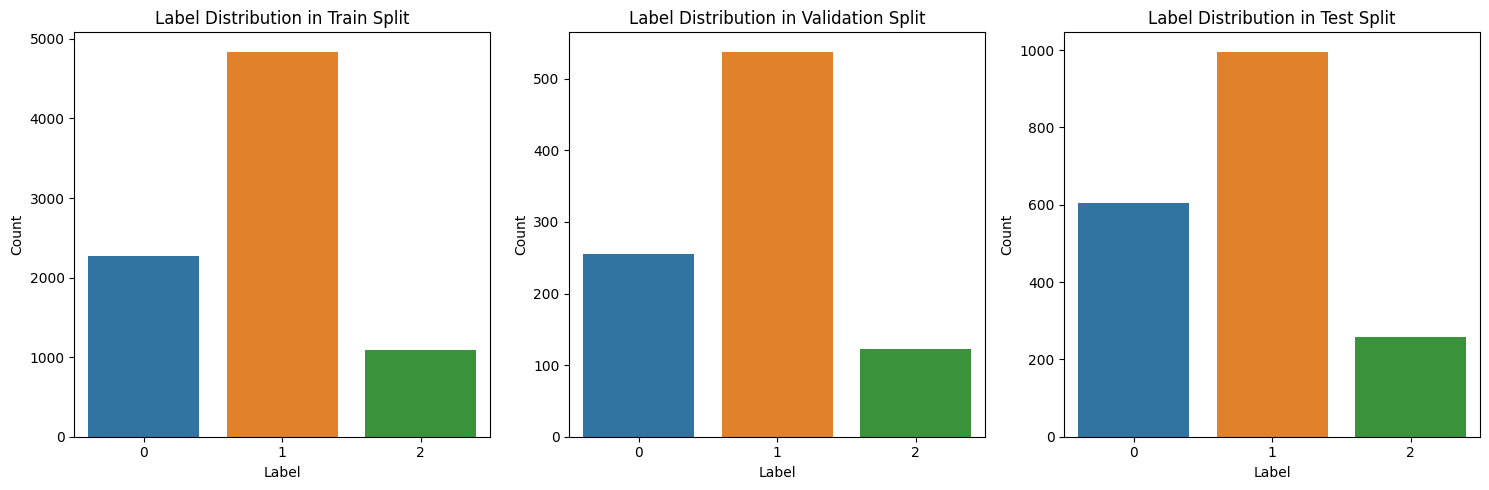

In [ ]:
splits = ['train', 'validation', 'test']

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, split in enumerate(splits):
    labels = [example['label'] for example in dataset[split]]
    # Here I count the occurrence of each label thanks to counter, imported from collections
    label_counts = Counter(labels)

    df = pd.DataFrame({'label': list(label_counts.keys()), 'count': list(label_counts.values())})
    sns.barplot(x='label', y='count', data=df, ax=axs[i])

    axs[i].set_title(f'Label Distribution in {split.capitalize()} Split')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Below is to adjust padding
plt.tight_layout()
plt.show()

As stated above, the distribution of labels is consistent within the splits.

Now, let's inspect the missing values from the dataset.

According to how the dataset has been created, <b>NaN</b> values are not present in the huggingface version. Thus, in order to have a grasp of which columns present missing values, and how many of them we have to deal with, we should made a simple conversion from "", or " ", to np.nan.</br>Then, we plot a mtrix like representation of missing values for each of the splits.

Missing values in Train: 587
Missing values in Train Split:
Missing values in Validation: 71
Missing values in Validation Split:
Missing values in Test: 66
Missing values in Test Split:


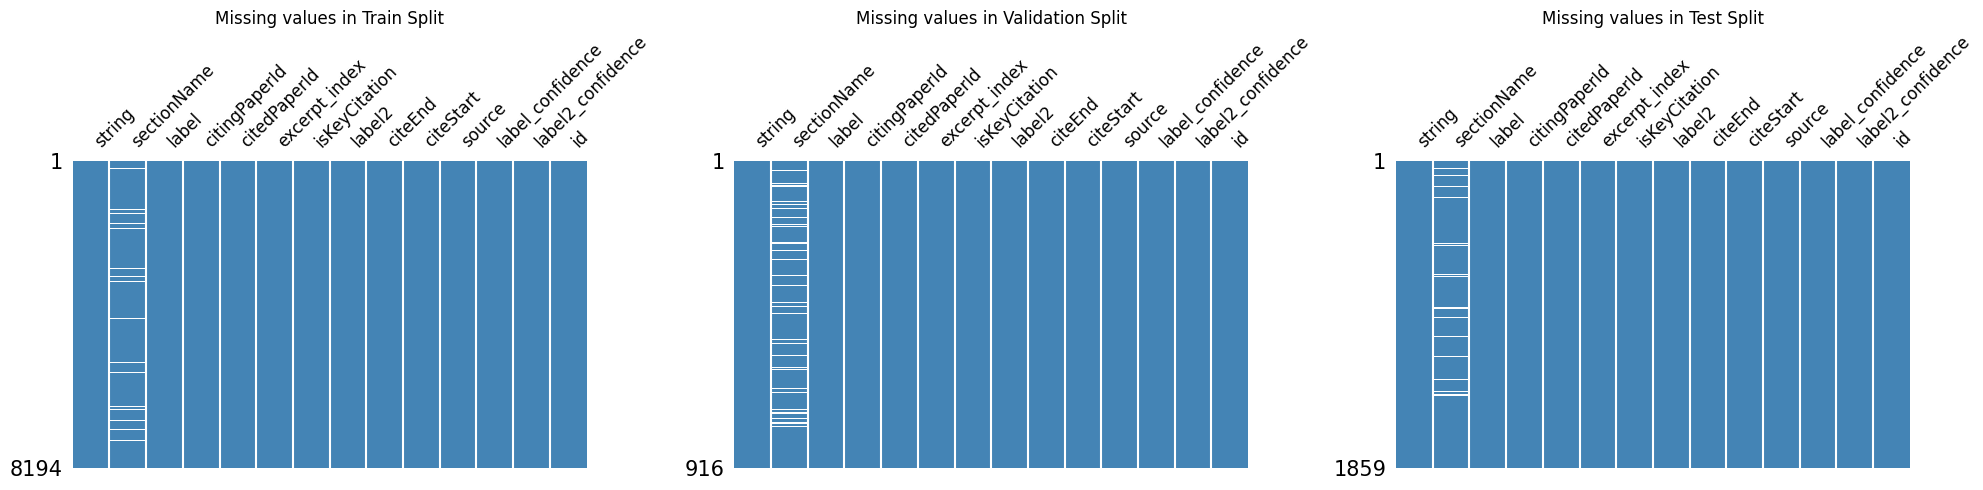

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    df = pd.DataFrame(dataset[split])
    # Conversion of empty cells into np.nan
    df.replace({"": np.nan, " ": np.nan}, inplace=True)
    # Find missing values
    missing_values = df.isna().sum().sum()
    print(f"Missing values in {split.capitalize()}: {missing_values}")
    # Visualizing the missing values with missingno library
    print(f"Missing values in {split.capitalize()} Split:")
    msno.matrix(df, ax=axs[i], sparkline=False, fontsize=12, color=(0.27, 0.52, 0.71))
    axs[i].set_title(f'Missing values in {split.capitalize()} Split')

plt.tight_layout()
plt.show()

From this dataset, we are mainly interested in seeing how to deal with string, sectionName, and label columns. All the other information can be discarded because are not useful for the task.

## 2. Brief discussion: PLMs and SOTA

The Citation Intent Classification task has been studied intensively, and the current state of the art is a Macro-F1 score of 88.93 obtained with an XLNet based model ([SOTA page](https://paperswithcode.com/sota/citation-intent-classification-on-scicite)). Other methodologies, like embedding based analyses, together with LSTM based approaches, show a much lower performance.

As you can imagine, the task can be tackled from very different perspectives, we could use prompt-tuning, fine-tuning, zero-shot, few-shot, sentence-transformer based similarity, and so on... But, for the aim of this project, I'd like to go deeper on the scores we can obtain by using an ensemble based approach, and see whether or not it will outperform the scores obtained with task specific fine-tuning. Additionally, I'd like to investigate the impact that a mix of feature and prompt engineering, correctly applied to these PLMs could have.

In order to move our first steps into the task, we must first decide which model we would like to use. To make such decision, I have a list of candidate PLMs.

The models I will take into consideration are the following:
- <b>SciBERT</b>: A BERT based model trained on a corpus of scientific texts. Its main advantages is its good understanding of the scientific domain and the SciVocab, a newly designed vocabulary containing a great number of terms from the scientific literature - [Reference Paper](https://arxiv.org/abs/1903.10676);
- <b>XLNet</b>: A model presenting an evolution of the way in which LMs are trained for Language Understanding tasks. As said before, it is also the current base-model of SOTA results for this task - [Reference Paper](https://arxiv.org/abs/1906.08237);
- <b>Galactica</b>: A big open source science based language model from META. It is a controversial model for the results it has obtained in text generation tasks, but it is now back on track - [Reference Paper](https://arxiv.org/abs/2211.09085).

Each of these models could be particularly suited for the task.

## 3. XLNet Fine-Tuning
In this section, I will tackle the problem with the raw fine-tuning of the XLNet model on the SciCite dataset.

Fine tuning is an approach that involves changing the weights of the PLM to adapt it to a new task. Additionally, the process involves the use of a classification head in this specific case. Such head is useful to classify, by means of the logits of the model, its answers into either one of the three possible classes.

For this part, I will solely rely on Huggingface for fine tuning and Ray Tune for hyperparameter optimization.

Below, you can see and inspect XLNet configuration.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ckp = "xlnet/xlnet-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3)
model.to(device)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

#### 3.a) Tokenization and Model download

The tokenization part is mostly carried out by the AutoTokenizer object of  Huggingface. What we need to do is simply load the tokenizer we want to use, and then define a mapping function to the dataset.

For what concerns the model download, the same is true. We can easily rely on huggingface to download the model we want to use, and add a mapping from labels to numerical values of them.

#### 3.b) Ray Tune for HP optimization

To optimize the search in the HP space, we will make use of ray tune library. This library gives us the possibility to define in high details the way in which we want to perform such search.

<b><u>"Unfortunately", seen the dimension of these PLMs, I will need to define each of the steps I am describing inside a single function, otherwise Ray Tune wouldn't be able to correctly handle GPU RAM.</b></u>

For what concerns the task specific Fine-Tuning, I would like to make use of some prompt and feature engineering on the sentences that the model will need to classify. Additionally, I will implement a Population Based Search for HP optimization.

The main HP I will deal with are the following:
- Learning Rate;
- Weighted loss or non-weighted loss (since the dataset is higly imbalanced, a weighted loss could, or not, help);
- Weight decay for the optimizer;
- Batch size.

Additionally, these models are highly sensible to weights initialization and data order, which may result in drastically different performances, as stated in [Fine-Tuning Pretrained Language Models:
Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/pdf/2002.06305v1.pdf). Thus, searching also through the seeds could be a good idea but, for memory and efficiency requirements, I will manually set a pre-defined seed.

#### 3.c) Training loop

Inside the main function, that you will see below, I have implemented a particular training loop.

This is not the standard training suggested for PLMs fine tuning (which is way less flexible...), I have implemented an early stopping condition to deal with the fact that such PLMs heavily tends to overfit. Moreover, since the problem of overfitting is real, I will save the model with the best generalization performance in terms of validation loss at each step, to finally retrieve the best performing overall.

Additionally, seen that PLMs need really low learning rate values in their fine tuning, they risk many times to get stuck. Thus, instead of opting for a linear decrease of the learning rate through epochs, I found way better results with a static reduction of the learning rate when the model gets stuck in a plateau.

Since the number of epochs needed for PLMs is relatively low (around 5 epochs at most, or they will for sure overfit...), I have decided to add a fine-grained evaluation of generalization performances. This means that the model will look into validation data more than once during each epoch, and these data are used to implement LR reduction and Early Stopping.

Finally, to speed up the fine tuning process, I have used mixed precision training thanks to Autocast and GradScaler. The former is useful to perform forward and backward passes at half precision (float16 instead of float32), thus reducing memory requirements and speeding up the process, while the latter serves to purpose of mitigating numerical instability issues due to the half precision. With this strategy, we are in the end able to obtain more or less the same results but with a significantly lower use of resources and with a training that requires less than a half of the time that a normal loop would need.

#### 3.d) Implementation

Below I implement and describe through comments all the steps I have discussed above.

In [ ]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from ray import tune, train
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import tempfile
from ray.train import Checkpoint


def train_model(config):
    dataset = load_dataset("allenai/scicite", trust_remote_code=True)

    # Use config from ray Tune
    ckp = config["model_ckp"]
    loss_balance = config["loss_balance"]
    seed = config["seed"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    ray_checkpoint_interval = config['ray_checkpoint_interval']
    tokens_max_length = config["tokens_max_length"]

    # Here I define the mapping from numerical to string labels, and viceversa
    # This is useful for Huggingface automodel
    id2label = {0: "method", 1: "background", 2: "result"}
    label2id = {"method": 0, "background": 1, "result": 2}

    # Download the model from the checkpoint of SciBERT, and move it on GPU
    model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)
    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    # Load SciBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckp)

    # The function below defines the tokenization process
    def tokenize_function(examples):
        augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
        tokenized = tokenizer(augmented, max_length=tokens_max_length, padding='max_length', truncation=True)
        tokenized['augmented'] = augmented
        return tokenized

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Define train and validation sets according to the standard splits
    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=128)

    # It is good norm to not applying weight decay to the following two layers if present
    # I will check if they are in the model and in case set their weight decay to 0
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    # Define the optimizer and the scheduler
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.75, min_lr=8e-7, cooldown=2, verbose=True)

    batch_counter = 0
    # Accumulation steps are only useful if the GPU is not sufficiently big,
    # in this case I leave it to 1, so it is like if it is not here
    accumulation_steps = 1
    validation_interval = ray_checkpoint_interval
    step_counter = 0
    evaluation_counter = 0

    # Set extreme values to have checkpointing
    best_val_loss = float('inf')
    best_val_f1 = float('-inf')

    scaler = GradScaler()

    no_improvement = 0
    early_stopping_patience = 8 # Number of evaluations without performance improvement before stopping

    start_epoch = 0
    last_batch_index = 0

    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        print("GETTING BACK CHECKPOINT AFTER PAUSED TRAINING")
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        step_counter = checkpoint_dict["step"]
        best_val_loss = checkpoint_dict["best_val_loss"]
        evaluation_counter = checkpoint_dict["performed_evaluation"]
        scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

        # Give a cooldown step
        no_improvement = checkpoint_dict["no_improvement_steps"]
        if no_improvement >= 1:
            no_improvement-=1

        start_epoch = checkpoint_dict["last_epoch_index"]
        last_batch_index = checkpoint_dict["last_batch_index"]
        print(f"Resuming training from Epoch {start_epoch}, Batch Index: {last_batch_index}")
        metrics = checkpoint_dict["metrics"]

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        optimizer.zero_grad()

        for batch_index, batch in enumerate(train_dataloader):
            if epoch == start_epoch and batch_index < last_batch_index:
                continue  # Skip batches up to checkpoint

            batch = {k: v.to(device) for k, v in batch.items()}
            # Mixed precision below
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            # This below should ensure that the same amount of data has been seen by the model
            # even if it has the smallest batch size (16) between the searched ones.
            # This is useful to have a meaningful comparison of val_loss at the evaluation time,
            # because both bs=32 and bs=16 models should have seen the same amount of data.
            if batch_size==16:
                step_counter += 0.5
            else:
                step_counter += 1

            # Evaluation on Validation data + Ray Checkpoint creation
            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches
                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement = 0
                else:
                    no_improvement += 1

                evaluation_counter += 1

                if no_improvement >= early_stopping_patience:
                    print("No improvement in validation loss for {} evaluations, stopping.".format(early_stopping_patience))
                    train.report(metrics)
                    break

                scheduler.step(val_loss)
                intermediate_train_loss = train_loss/num_train_batches

                metrics = {"training_iteration":step_counter, "performed_evaluation":evaluation_counter, "best_val_loss": best_val_loss, "train_loss":intermediate_train_loss, "current_val_loss":val_loss, "current_val_f1":val_f1}

                # Checkpointing with Ray Tune/Train
                with tempfile.TemporaryDirectory() as tmpdir:
                    torch.save(
                        {
                            "performed_evaluation": evaluation_counter,
                            "step": step_counter,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "best_val_loss": best_val_loss,
                            "no_improvement_steps": no_improvement,
                            "scheduler_state_dict": scheduler.state_dict(),
                            "last_batch_index": batch_index,
                            "last_epoch_index": epoch,
                            "metrics": metrics
                        },
                        os.path.join(tmpdir, "checkpoint.pt"),
                    )
                    train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir)) # tmpdir
                    print(f"Checkpoint stored at Epoch:{epoch}, Batch:{batch_index} - batch size:{batch_size}")

        if no_improvement >= early_stopping_patience:
            break

        train.report(metrics)
        print(f"EPOCH {epoch} finished")


Below I define the configuration, as well as the population based training. Finally, I start the training process, of which you will be able to see the results under the cell.

In [ ]:
seeds = [1482]
"""
For simplicity, here I will consider a single seed, without performing any kind of search.
Normally, the seed do not need to be searched, but, according to https://arxiv.org/pdf/2002.06305v1.pdf
in a LLM, a different weight initialization, and data order, can higly impact the performances of the
fine tuned model.
"""
# After evaluation_interval batches (depending on batch_size, if 32 is 30, if 16 is 60) -> I consider step_counter as time_attr
evaluation_interval = 30

# Define configuration space
config = {
    "num_epochs": 5,
    "batch_size": tune.grid_search([16, 32]),
    "seed": tune.grid_search(seeds),
    "lr": tune.uniform(1e-5, 2e-5), # These are the recommended learning rates for similar tasks
    "weight_decay": tune.uniform(0.02, 0.01), # Weight decay may highly influence the final results
    "model_ckp": ckp,
    "loss_balance": False, #tune.grid_search([True, False]),
    "tokens_max_length": tune.grid_search([256, 312]),
    "ray_checkpoint_interval": evaluation_interval
}

For the population based training, I have defined a perturbation interval every 30 steps. This means that, after 30 evaluations on validation data for each possible model, the worst (also called explorers) will be randomly mutated according to the parameters defined below. Thus, their learning rate, or weight decay, could be changed in the range defined. Additionally, these modified explorers will be re-trained from zero up to 2x number of perturbation interval (so for 60 evaluations), and the process is repeated.

The best performing models, called exploiters, are then modified according to the best performing explorers in a random way. Finally, the worst performing HP are discarded and the ones that gave best results replace them in following iterations.

This process of "evolution" goes on until all the models have completed their training.

Usually, with Population Based Training (PBT), models converge faster and a broader HP search space is explored. Unfortunately, since I am running this on single GPU on Colab platform, the process is pretty slow because training cannot be parallelized.

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=evaluation_interval*8,
    metric="best_val_loss",
    mode="min",
    #burn_in_period=120.0, # Number of training steps before starting with Exploitation/Exploration process
    quantile_fraction=0.5,
    resample_probability=0.3,
    perturbation_factors=(1.15,0.85),
    hyperparam_mutations={
        "lr": tune.uniform(9e-6, 3e-5),
        "weight_decay": tune.uniform(0.001, 0.03),
    },
    synch=True
)

In [ ]:
import time

start_time = time.time()

if ray.is_initialized():
    ray.shutdown()
ray.init()

# This tune.with_resources is basically the same of resources_per_trial
# So this is allocating 4 CPUs and 30% GPU for trial, making it possible to
# train more model in parallel (Slows a bit the performances but it's ok)
train_model_with_resources = tune.with_resources(train_model, {"cpu": 4, "gpu":0.3})

tuner = tune.Tuner(
    train_model_with_resources, #train_model,
    run_config=train.RunConfig(
        name="XLNet_PBT",
        stop={"training_iteration": 800}, # a bit more than 3 epochs
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="best_val_loss",
            checkpoint_score_order="min",
            num_to_keep=6,
        ),
        storage_path="/content/tmp/ray_results", #"/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Ray_PBT_Checkpoints", # "/tmp/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2,
    ),
    param_space=config,
)

results_grid = tuner.fit()
end_time = time.time()

2024-01-21 13:54:20,287	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-21 13:54:21,157	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     XLNet_PBT               |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        PopulationBasedTraining |
| Number of trials                 8                       |
+----------------------------------------------------------+

View detailed results here: /content/tmp/ray_results/XLNet_PBT
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/XLNet_PBT`

Trial status: 8 PENDING
Current time: 2024-01-21 13:54:21. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------

(train_model pid=2026) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
(train_model pid=2026) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2025) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
(train_model pid=2027) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
spiece.model: 100%|████


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:54:51. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256 |
| train_model_93d7e_00001   RUNNING    1.00077e-05        0.0138213             32     1482                   256 |
| train_model_93d7e_00002   RUNNING    1.74107e-05        0.0165829             16     1482                   312 |
| train_model_93d7e_00003   PENDING    1.08908e-05        0.0133251             32     1482                   31

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000000)
Map: 100%|██████████| 1859/1859 [00:00<00:00, 5129.94 examples/s] [repeated 5x across cluster]


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:29 - batch size:32
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:55:21. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000000)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000000)


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000001) [repeated 2x across cluster]


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:119 - batch size:16 [repeated 2x across cluster]
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:55:51. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000  

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000002)


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:56:21. Total running time: 2min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256       60            81

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000001)


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:119 - batch size:32 [repeated 2x across cluster]


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000003) [repeated 2x across cluster]


Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:56:51. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256       90            1

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000002)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000003)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:57:21. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05        

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000003) [repeated 2x across cluster]
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000004)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:299 - batch size:16
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:57:51. Total running time: 3min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05       

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000005)


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000004)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000005)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:359 - batch size:16
Trial status: 3 RUNNING | 5 PENDING
Current time: 2024-01-21 13:58:21. Total running time: 4min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05        

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:359 - batch size:16 [repeated 2x across cluster]


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01333 |
+---------------------------------------------------------------+

Trial status: 3 RUNNING | 1 PAUSED | 4 PENDING
Current time: 2024-01-21 13:58:52. 

(train_model pid=2026) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
(train_model pid=2026) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:01<00:00, 628.30 examples/s] 
(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01332 |
+---------------------------------------------------------------+


(train_model pid=2025) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
(train_model pid=2025) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 5019.48 examples/s]



Trial status: 2 PAUSED | 3 RUNNING | 3 PENDING
Current time: 2024-01-21 13:59:22. Total running time: 5min 0s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00002   RUNNING    1.74107e-05        0.0165829             16     1482                   312      210  

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000000)
(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01227 |
+---------------------------------------------------------------+


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000000)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=2027) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
(train_model pid=2027) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1859/1859 [00:00<00:00, 4897.15 examples/s]


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:59 - batch size:32

Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 13:59:52. Total running time: 5min 30s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.0890

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000001)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000001)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000000)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:00:22. Total running time: 6min 1s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908e-05        0.0133251             32     1482                   312       60   

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000002)


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:59 - batch size:32 [repeated 2x across cluster]


(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000001) [repeated 2x across cluster]


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:00:52. Total running time: 6min 31s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908e-05        0.0133251             32     1482                   312       90  

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000003)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:01:22. Total running time: 7min 1s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000002)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000004) [repeated 2x across cluster]


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:299 - batch size:16 [repeated 2x across cluster]
Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:01:52. Total running time: 7min 31s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000003)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:02:22. Total running time: 8min 1s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908e-05        0.0133251             32     1482                   312      120   

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000004)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000005)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:359 - batch size:16
(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000004)


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000005)


Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:02:52. Total running time: 8min 31s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908e-05        0.0133251             32     1482                   312      180  

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:419 - batch size:16
Trial status: 3 PAUSED | 3 RUNNING | 2 PENDING
Current time: 2024-01-21 14:03:22. Total running time: 9min 1s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING    1.08908

(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000005)
(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01579 |
+---------------------------------------------------------------+

Trial status: 4 PAUSED | 3 RUNNING | 1 PENDING
Current time: 2024-01-21 14:03:52. 

(train_model pid=2025) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
(train_model pid=2025) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1859/1859 [00:01<00:00, 1384.00 examples/s]
(train_model pid=2027) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2027) Checkpoint stored at Epoch:0, Batch:209 - batch size:32

Trial train_model_93d7e_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01128 |
+---------------------------------------------------------------+


(train_model pid=2026) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
(train_model pid=2026) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000007)



Trial status: 5 PAUSED | 3 RUNNING
Current time: 2024-01-21 14:04:22. Total running time: 10min 1s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00005   RUNNING    1.88181e-05        0.0122699             32     1482                   256      210            2

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000000)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:59 - batch size:16
(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:29 - batch size:32


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000000) [repeated 2x across cluster]


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 14:04:52. Total running time: 10min 31s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00006   RUNNING    1.22617e-05        0.0157923             16     1482                   312       30            45.6377          

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000001)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000001)
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000002)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 14:05:22. Total running time: 11min 1s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00006   RUNNING    1.22617e-05        0.0157923      

(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000002)
2024-01-21 14:05:30,459	WARNING util.py:202 -- The `on_step_begin` operation took 1.816 s, which may be a performance bottleneck.
2024-01-21 14:05:42,890	WARNING util.py:202 -- The `on_step_begin` operation took 2.376 s, which may be a performance bottleneck.
(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000003)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000003)


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:119 - batch size:32
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 14:05:52. Total running time: 11min 31s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00006   RUNNING    1.22617e-05        0.0157923     

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000004)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:299 - batch size:16
(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000004)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 14:06:23. Total running time: 12min 1s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00006   RUNNING    1.22617e-05        0.0157923             16     1482                   312      150            135.286           

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000005)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:359 - batch size:16
(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000005)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 14:06:53. Total running time: 12min 31s
Logical resource usage: 8.0/12 CPUs, 0.6/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00006   RUNNING    1.22617e-05        0.0157923             16     1482                   312      180            155.946          

(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2025) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


2024-01-21 14:06:58,989	WARNING util.py:202 -- The `on_step_begin` operation took 1.233 s, which may be a performance bottleneck.
(train_model pid=2026) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/checkpoint_000006)


(train_model pid=2026) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=2025) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/checkpoint_000007)


Trial status: 7 PAUSED | 1 RUNNING
Current time: 2024-01-21 14:07:23. Total running time: 13min 1s
Logical resource usage: 4.0/12 CPUs, 0.3/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00007   RUNNING    1.2385e-05         0.0112809             32     1482                   312      210            176.254           

2024-01-21 14:07:25,551	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 93d7e_00000 (score = -0.356479) into trial 93d7e_00007 (score = -0.396222)

2024-01-21 14:07:25,553	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial93d7e_00007:
lr : 1.3892036626668626e-05 --- (* 0.85) --> 1.180823113266833e-05
weight_decay : 0.01937648307634858 --- (* 1.15) --> 0.022282955537800866

2024-01-21 14:07:25,557	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 93d7e_00000 (score = -0.356479) into trial 93d7e_00001 (score = -0.389772)

2024-01-21 14:07:25,559	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trial93d7e_00001:
lr : 1.3892036626668626e-05 --- (* 0.85) --> 1.180823113266833e-05
weight_decay : 0.01937648307634858 --- (resample) --> 0.01404420907126656

2024-01-21 14:07:25,562	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial 93d7


Trial train_model_93d7e_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01938 |
+---------------------------------------------------------------+


(train_model pid=5760) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01404 |
+---------------------------------------------------------------+


(train_model pid=5760) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
(train_model pid=5760) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=5834) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000007)



Trial train_model_93d7e_00002 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00002 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01658 |
+---------------------------------------------------------------+
(train_model pid=5760) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5908) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000007)
(train_model pid=5834) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']


(train_model pid=5760) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=5834) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5908) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
(train_model pid=5908) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference. [repeated 2x across cluster]


(train_model pid=5908) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:07:53. Total running time: 13min 31s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05    

(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000008)


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000008) [repeated 2x across cluster]


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:25 - batch size:16 [repeated 2x across cluster]
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:08:53. Total running time: 14min 31s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000009)
(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000009)


Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:09:23. Total running time: 15min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256      300  

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000010) [repeated 2x across cluster]


Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:09:53. Total running time: 15min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256      330 

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000011) [repeated 3x across cluster]
(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000011)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000011)
(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000012)


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000012)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:10:53. Total running time: 16min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.389

(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000012)


Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:11:23. Total running time: 17min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.3892e-05         0.0193765             16     1482                   256      390  

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000013)


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:325 - batch size:16 [repeated 2x across cluster]


(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0194_2024-01-21_13-54-21/checkpoint_000014)


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
Trial status: 3 RUNNING | 1 PENDING | 4 PAUSED
Current time: 2024-01-21 14:11:53. Total running time: 17min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   RUNNING    1.389

(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0138_2024-01-21_13-54-21/checkpoint_000014)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_93d7e_00000 completed after 450.0 iterations at 2024-01-21 14:12:07. Total running time: 17min 45s
+--------------------------------------------------+
| Trial train_model_93d7e_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         17.0032 |
| time_total_s                             553.618 |
| training_iteration                           450 |
| best_val_loss                            0.35648 |
| current_val_f1                           0.82433 |
| current_val_loss                         0.43287 |
| performed_evaluation                          15 |
| train_loss                                0.2352 |
+--------------------------------------------------+

Trial train_model_93d7e_00003 started with configuration:
+------------------------------------------------------

(train_model pid=5760) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000007)
(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0166_2024-01-21_13-54-21/checkpoint_000014)


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=5760) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias', 'sequence_summary.summary.bias']
(train_model pid=5760) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=5760) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial train_model_93d7e_00001 completed after 450.0 iterations at 2024-01-21 14:12:15. Total running time: 17min 53s
+--------------------------------------------------+
| Trial train_model_93d7e_00001 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          14.114 |
| time_total_s                             557.628 |
| training_iteration                           450 |
| best_val_loss                            0.35648 |
| current_val_f1                           0.82433 |
| current_val_loss                         0.43287 |
| performed_evaluation                          15 |
| train_loss                                0.2352 |
+--------------------------------------------------+

Trial train_model_93d7e_00004 started with configuration:
+---------------------------------------------------------------+

(train_model pid=5834) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000007)
(train_model pid=5834) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
(train_model pid=5834) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=5760) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=5834) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING

Trial status: 2 TERMINATED | 3 RUNNING | 1 PENDING | 2 PAUSED
Current time: 2024-01-21 14:12:23. Total running time: 18min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=5908) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000007)


(train_model pid=5760) EPOCH 0 finished
(train_model pid=5834) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=5908) Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
(train_model pid=5908) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=5908) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=5834) EPOCH 0 finished
(train_model pid=5908) Resuming training from Epoch 0, Batch Index: 239
(train_model pid=5908) EPOCH 0 finished


(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000008)


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:25 - batch size:16

Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:12:53. Total running time: 18min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_000

2024-01-21 14:13:06,552	WARNING util.py:202 -- The `on_step_begin` operation took 2.204 s, which may be a performance bottleneck.
(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000008)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:11 - batch size:32


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000008)


Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:13:23. Total running time: 19min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING      8.61276e-06        0.0153195             16     1482          

2024-01-21 14:13:29,577	WARNING util.py:202 -- The `on_step_begin` operation took 2.875 s, which may be a performance bottleneck.
(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000009) [repeated 2x across cluster]


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:85 - batch size:16 [repeated 2x across cluster]
(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:41 - batch size:32


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000009)


Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:13:53. Total running time: 19min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING      8.61276e-06        0.0153195             16     1482         

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000010)
2024-01-21 14:14:12,297	WARNING util.py:202 -- The `on_step_begin` operation took 2.435 s, which may be a performance bottleneck.


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:71 - batch size:32 [repeated 2x across cluster]


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000010) [repeated 2x across cluster]
2024-01-21 14:14:23,616	WARNING util.py:202 -- The `on_step_begin` operation took 1.312 s, which may be a performance bottleneck.


Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:14:23. Total running time: 20min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING      8.61276e-06        0.0153195             16     1482          

(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000011)
2024-01-21 14:14:34,301	WARNING util.py:202 -- The `on_step_begin` operation took 0.661 s, which may be a performance bottleneck.
(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000011)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000011)


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:101 - batch size:32
(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000012)


Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:14:53. Total running time: 20min 32s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING      8.61276e-06        0.0153195             16     1482         

(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000012)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=5760) Epoch 00014: reducing learning rate of group 0 to 7.5995e-06.
(train_model pid=5760) Epoch 00014: reducing learning rate of group 1 to 7.5995e-06.


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000012)


(train_model pid=5908) Checkpoint stored at Epoch:1, Batch:131 - batch size:32
(train_model pid=5834) Epoch 00014: reducing learning rate of group 1 to 7.5995e-06. [repeated 2x across cluster]
(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000013)


Trial status: 3 TERMINATED | 3 RUNNING | 1 PENDING | 1 PAUSED
Current time: 2024-01-21 14:15:24. Total running time: 21min 2s
Logical resource usage: 12.0/12 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00003   RUNNING      8.61276e-06        0.0153195             16     1482          

(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000013)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000014) [repeated 2x across cluster]
2024-01-21 14:15:43,580	WARNING util.py:202 -- The `process_trial_save` operation took 2.726 s, which may be a performance bottleneck.


(train_model pid=5760) Checkpoint stored at Epoch:1, Batch:385 - batch size:16 [repeated 2x across cluster]
(train_model pid=5908) Epoch 00015: reducing learning rate of group 0 to 1.4114e-05.
(train_model pid=5908) Epoch 00015: reducing learning rate of group 1 to 1.4114e-05.

Trial train_model_93d7e_00003 completed after 450.0 iterations at 2024-01-21 14:15:52. Total running time: 21min 31s
+--------------------------------------------------+
| Trial train_model_93d7e_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         8.90509 |
| time_total_s                             505.273 |
| training_iteration                           450 |
| best_val_loss                            0.37016 |
| current_val_f1                           0.84489 |
| current_val_loss                          0.3929 |
| performed_evaluation                          15 |
| train_loss         

2024-01-21 14:15:53,076	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_93d7e_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.restore() (pid=5760, ip=172.28.0.12, actor_id=6deb4a4dbded06d18660f39901000000, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 556, in restore
    raise ValueError(
ValueError: Co


Trial train_model_93d7e_00006 errored after 240.0 iterations at 2024-01-21 14:15:53. Total running time: 21min 31s
Error file: /root/ray_results/XLNet_PBT/train_model_93d7e_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0158_2024-01-21_13-54-21/error.txt
+------------------------------------------------------------+
| Trial train_model_93d7e_00006 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  19.75242 |
| time_total_s                                     201.34192 |
| training_iteration                                    240. |
| best_val_loss                                      0.37814 |
| current_val_f1                                     0.84017 |
| current_val_loss                                   0.37814 |
| performed_evaluation                                     8 |
| train_loss       

(train_model pid=5834) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0133_2024-01-21_13-54-21/checkpoint_000014)


(train_model pid=5834) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000014)



Trial train_model_93d7e_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_93d7e_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                .../xlnet-base-cased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.02228 |
+---------------------------------------------------------------+


2024-01-21 14:16:02,300	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_93d7e_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.restore() (pid=8192, ip=172.28.0.12, actor_id=65e3d6e5952cc9c63f5e745301000000, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 556, in restore
    raise ValueError(
ValueError: Co


Trial train_model_93d7e_00007 errored after 240 iterations at 2024-01-21 14:16:02. Total running time: 21min 40s
Error file: /root/ray_results/XLNet_PBT/train_model_93d7e_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0113_2024-01-21_13-54-21/error.txt
+------------------------------------------------------------+
| Trial train_model_93d7e_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  24.43881 |
| time_total_s                                      200.6932 |
| training_iteration                                     240 |
| best_val_loss                                      0.39622 |
| current_val_f1                                     0.84049 |
| current_val_loss                                   0.39915 |
| performed_evaluation                                     8 |
| train_loss         

(train_model pid=5908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/XLNet_PBT/train_model_93d7e_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0123_2024-01-21_13-54-21/checkpoint_000015)
2024-01-21 14:16:17,540	WARNING insufficient_resources_manager.py:163 -- Ignore this message if the cluster is autoscaling. No trial is running and no new trial has been started within the last 60 seconds. This could be due to the cluster not having enough resources available. You asked for 4.0 CPUs and 0.3 GPUs per trial, but the cluster only has 12.0 CPUs and 1.0 GPUs available. Stop the tuning and adjust the required resources (e.g. via the `ScalingConfig` or `resources_per_trial`, or `num_workers` for rllib), or add more resources to your cluster.



Trial status: 5 TERMINATED | 1 PAUSED | 2 ERROR
Current time: 2024-01-21 14:16:24. Total running time: 22min 2s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   TERMINATED   1.3892e-05         0.0193765             16     1482                   256      450            

2024-01-21 14:16:54,395	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-01-21 14:16:54,446	ERROR tune.py:1038 -- Trials did not complete: [train_model_93d7e_00005, train_model_93d7e_00006, train_model_93d7e_00007]
2024-01-21 14:16:54,447	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/content/tmp/ray_results/XLNet_PBT", trainable=...)


Trial status: 5 TERMINATED | 1 PAUSED | 2 ERROR
Current time: 2024-01-21 14:16:54. Total running time: 22min 33s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_93d7e_00000   TERMINATED   1.3892e-05         0.0193765             16     1482                   256      450            

In [ ]:
from ray.train import Result

# Function to convert elapsed time in seconds to minutes and seconds
def convert_seconds_to_minutes_seconds(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return minutes, remaining_seconds

elapsed_time = end_time - start_time  # Calculate the elapsed time
minutes, seconds = convert_seconds_to_minutes_seconds(elapsed_time)
print(f"Time taken: {minutes} minutes and {seconds} seconds")


num_results = len(results_grid)
print("Number of results:", num_results)
# Check if there have been errors
if results_grid.errors:
    print("At least one of the trials failed!")
else:
    print("No errors!")

# Iterate over results
for i, result in enumerate(results_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a validation loss of:",
        result.metrics["current_val_loss"],
        " and the best validation loss through the training has been:",
        result.metrics["best_val_loss"]
    )


# Get the result with the maximum test set `mean_accuracy`
best_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="min"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="max"
)

Time taken: 22.0 minutes and 36.25299525260925 seconds
Number of results: 8
At least one of the trials failed!
Trial #0 finished successfully with a validation loss of: 0.4328659512102604  and the best validation loss through the training has been: 0.3564794696867466
Trial #1 finished successfully with a validation loss of: 0.4328659512102604  and the best validation loss through the training has been: 0.3564794696867466
Trial #2 finished successfully with a validation loss of: 0.44385600462555885  and the best validation loss through the training has been: 0.3739261068403721
Trial #3 finished successfully with a validation loss of: 0.3929031305015087  and the best validation loss through the training has been: 0.3701569326221943
Trial #4 finished successfully with a validation loss of: 0.3929031305015087  and the best validation loss through the training has been: 0.3701569326221943
Trial #5 finished successfully with a validation loss of: 0.3724063038825989  and the best validation l

In [ ]:
print("Best model - final configuration after HP perturbations:\n")
tokenizer_length = best_result.config['tokens_max_length']
best_result.config

Best model - final configuration after HP perturbations:



{'num_epochs': 5,
 'batch_size': 16,
 'seed': 1482,
 'lr': 1.3892036626668626e-05,
 'weight_decay': 0.01937648307634858,
 'model_ckp': 'xlnet/xlnet-base-cased',
 'loss_balance': False,
 'tokens_max_length': 256,
 'ray_checkpoint_interval': 30}

<Figure size 30000x15000 with 0 Axes>

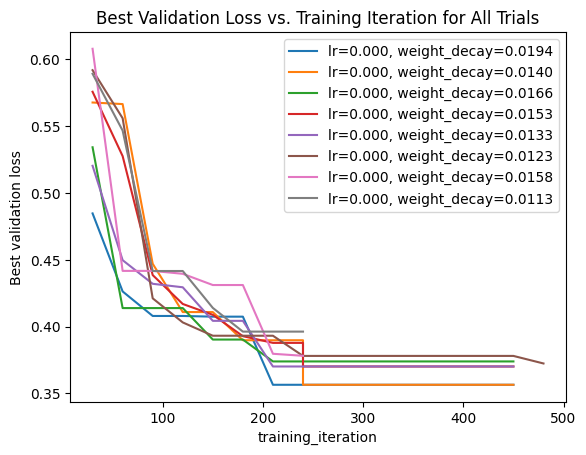

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 150))

ax = None
for result in results_grid:
    label = f"lr={result.config['lr']:.3f}, weight_decay={result.config['weight_decay']:.4f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "best_val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "best_val_loss", ax=ax, label=label)

ax.set_title("Best Validation Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Best validation loss")
plt.show()  # Display the plot


As you might have noticed, the PBT is not exactly correct: it doesn't re-use models but re-starts training for all models without considering to continue any of them. This is due to the difficulty in providing a working trainable object with this particular train loop.

The positive thing about it is that it ensures HP perturbations and that it maintains only the best performing HP.

#### 3.e) Performance assessment and evaluation

Below, I will assess the performances of the best model obtained above on the test set. To do this we need, in order, to:
1. Retrieve the best performing model's checkpoint;
2. Load the best performing checkpoint;
3. Tokenize again the dataset in order to produce tokenized test set;
4. Implement test dataloader;
5. Assess its performances on unseen data.

In [ ]:
# Load the best fine tuned model and move it to GPU
id2label = {0: "method", 1: "background", 2: "result"}
label2id = {"method": 0, "background": 1, "result": 2}

best_model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model_state_dict = checkpoint['model_state_dict']  # Extract only the model's state dictionary
    best_model.load_state_dict(model_state_dict)

best_model = best_model.to(device)

full_model_path = "/content/drive/MyDrive/Models/XLNet_Models/FT/XLNet_ft.pt"
torch.save(best_model.state_dict(), full_model_path)

print(f"Model saved to {full_model_path}")

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/drive/MyDrive/Models/XLNet_Models/FT/XLNet_ft.pt


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=tokenizer_length, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])#, 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
# Test dataset and dataloader
test_dataset = tokenized_datasets["test"]
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In [ ]:
###############################################################################
########################### Performance assessment ###########################
###############################################################################
from tqdm.auto import tqdm

predictions_list = []
labels_list = []

best_model.eval() # Set the model to evaluation mode
test_loss = 0.0
num_test_batches = 0

test_progress_bar = tqdm(eval_dataloader, desc="Evaluating on Test Set")

with torch.no_grad():  # Disable gradient computation
    for batch in test_progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)
        loss = outputs.loss

        test_loss += loss.item()
        num_test_batches += 1

        # Store predictions and labels
        preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
        predictions_list.extend(preds)
        labels_list.extend(batch["labels"].cpu().numpy())

        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")

# Calculate F1 score and accuracy using the stored predictions and labels
test_f1 = f1_score(labels_list, predictions_list, average="macro")
test_f1_none = f1_score(labels_list, predictions_list, average=None)
test_acc = accuracy_score(labels_list, predictions_list)

print(f"Test F1: {test_f1:.4f}, Test_f1_None: {test_f1_none} Test Acc: {test_acc:.4f}")

Evaluating on Test Set:   0%|          | 0/15 [00:00<?, ?it/s]

Test Loss: 0.3318
Test F1: 0.8602, Test_f1_None: [0.88427773 0.88198758 0.81425891] Test Acc: 0.8731


## 4. Ensemble model

#### 4.a) Introduction to the methodology

In order to develop an ensemble model we first need to produce some base models capable of carrying out a part of the entire classification task. To this aim, I will build three different binary classifiers, each of which trained in recognizing whether a specific sentence can or cannot be classified as being part of a specific class.

In the end, I will obtain three binary classifiers:
- Background based model: aimed at correctly classifying whether a sentence is of type background or not;
- Method based model: aimed at correctly classifying whether a sentence is of type method or not;
- Result based model: aimed at correctly classifying whether a sentence is of type result or not.

Once I have the final predictions made by the models, I will use them as input to an ensemble classifier, for which I will inspect different possibilities.

#### 4.b) Base functions

Here, I define the basic functions useful to map labels to their binary counterpart.

In [ ]:
def background_transform_labels(example):
    if example['label'] == 1:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 2]:
        example['label'] = 0  # 'no'
    return example

def method_transform_labels(example):
    if example['label'] == 0:
        example['label'] = 1  # 'yes'
    elif example['label'] in [1, 2]:
        example['label'] = 0  # 'no'
    return example

def result_transform_labels(example):
    if example['label'] == 2:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 1]:
        example['label'] = 0  # 'no'
    return example

Now, we need a training loop for these binary classifiers we aim at building. For these base models, I will not make use of Hyperparameter search strategies. The loop below is based on the same theoretical information given above (scaled, fine-grained eveluation...).

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, class_weights_tensor, train_dataloader, val_dataloader, model_path):
    loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Replace StepLR with ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.2, cooldown=8, verbose=True)

    num_epochs = 5
    batch_counter = 0
    accumulation_steps = 1
    validation_interval = 10
    step_counter = 0

    best_val_loss = float('inf')
    best_model_path = model_path # 'background_model_loss.pt'
    best_val_f1 = float('-inf')
    #best_model_f1_path = 'background_model_f1.pt'

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    no_improvement = 0
    early_stopping_patience = 50  # Number of evaluations with no improvement after which training will be stopped

    for epoch in range(num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        optimizer.zero_grad()

        for batch in epoch_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Use autocast for mixed precision
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Use scaler for backward
            scaler.scale(loss).backward()

            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            epoch_progress_bar.set_postfix({"train_loss": train_loss / num_train_batches})

            step_counter += 1

            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision
                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches

                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")
                val_acc = accuracy_score(val_labels_list, val_predictions_list)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    #torch.save(model_background.state_dict(), best_model_f1_path)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= early_stopping_patience:
                        print("No improvement in validation loss for {} steps, stopping.".format(early_stopping_patience))
                        break

                scheduler.step(val_loss)

                print(f"Step {step_counter}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")
                print(f"Best Val Macro-F1: {best_val_f1:.4f}")

                model.train()

        if no_improvement >= early_stopping_patience:
            break

        train_loss /= num_train_batches

        train_f1 = f1_score(train_labels_list, train_predictions_list, average="macro")
        train_acc = accuracy_score(train_labels_list, train_predictions_list)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}")

Finally, I write a function to compute class weights.

In [ ]:
def compute_weight_tensor(tokenized_datasets):
    label_counts = Counter(tokenized_datasets['train']['label'])
    # Calculate weights
    class_weights = {k: 1.0 / v for k, v in label_counts.items()}
    # Normalize weights such that the sum of weights equals the number of classes
    total_weights = sum(class_weights.values())
    class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}
    # Transform the dict to a tensor and give it to device
    class_weights_tensor = torch.tensor([class_weights[i] for i in [0, 1]], dtype=torch.float).to(device)
    return class_weights_tensor

Now, we can go inside the specificity of each particular binary classifiers, each of which will make use of different weight for loss balance, and will work on different dataloaders.

#### 4.c) Base models

The operations for each model will be basically the same but with different objects and computations. Thus, I will explain them in detail only for their first appeareance.

First of all, let's download the dataset again and set the GPU device.

In [ ]:
dataset = load_dataset("allenai/scicite")

if torch.cuda.is_available():
    print('cuda')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for allenai/scicite contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/scicite
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


cuda


Let's map the labels to the binary case thanks to the functions defined in the previous section.

In [ ]:
background_datasets = dataset.map(background_transform_labels)
method_datasets = dataset.map(method_transform_labels)
result_datasets = dataset.map(result_transform_labels)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Now, let's compute all the weights to balance the loss function.

In [ ]:
background_weight_tensor = compute_weight_tensor(background_datasets)
method_weight_tensor = compute_weight_tensor(method_datasets)
result_weight_tensor = compute_weight_tensor(result_datasets)

Now, we can define the various dataloaders. But, before, we write a function to carry on the tokenization part.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_dataloader(dataset, batch_size, seed=None):
    if seed is not None:
        set_seed(seed)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader

batch_size = 32
random_seed = 1482

background_train_dataloader, background_val_dataloader = prepare_dataloader(background_datasets, batch_size, seed=random_seed)
method_train_dataloader, method_val_dataloader = prepare_dataloader(method_datasets, batch_size, seed=random_seed)
result_train_dataloader, result_val_dataloader = prepare_dataloader(result_datasets, batch_size, seed=random_seed)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

It is important to notice that I will not use at all the test set with the base models. The first time the test set will be used is with the ensemble classifier.

##### <b>Background model</b>

Now, it is time to define the base models I will use for the ensemble classifier. Let's start with the Background model.

The steps will be the same for each model, so I will not repeat what I do.

The main part consists of a mapping between integer and literal labels. Such map must be fed to the PLM I will use, during the loading.

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_background = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_background = model_background.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we can procede with the training. In order to do that, I will use the above defined training loop function.

In [ ]:
train_model(model_background, background_weight_tensor, background_train_dataloader, background_val_dataloader, "background_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.6604, Val F1: 0.4115, Val Acc: 0.6026
Best Val Loss: 0.6604
Best Val Macro-F1: 0.4115
Step 20, Val Loss: 0.5600, Val F1: 0.6633, Val Acc: 0.7009
Best Val Loss: 0.5600
Best Val Macro-F1: 0.6633
Step 30, Val Loss: 0.5087, Val F1: 0.7503, Val Acc: 0.7533
Best Val Loss: 0.5087
Best Val Macro-F1: 0.7503
Step 40, Val Loss: 0.4273, Val F1: 0.8164, Val Acc: 0.8210
Best Val Loss: 0.4273
Best Val Macro-F1: 0.8164
Step 50, Val Loss: 0.3984, Val F1: 0.8270, Val Acc: 0.8297
Best Val Loss: 0.3984
Best Val Macro-F1: 0.8270
Step 60, Val Loss: 0.4444, Val F1: 0.8047, Val Acc: 0.8057
Best Val Loss: 0.3984
Best Val Macro-F1: 0.8270
Step 70, Val Loss: 0.4489, Val F1: 0.8092, Val Acc: 0.8100
Best Val Loss: 0.3984
Best Val Macro-F1: 0.8270
Step 80, Val Loss: 0.3796, Val F1: 0.8536, Val Acc: 0.8581
Best Val Loss: 0.3796
Best Val Macro-F1: 0.8536
Step 90, Val Loss: 0.3742, Val F1: 0.8471, Val Acc: 0.8548
Best Val Loss: 0.3742
Best Val Macro-F1: 0.8536
Step 100, Val Loss: 0.4860, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.3479, Val F1: 0.8538, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 270, Val Loss: 0.3585, Val F1: 0.8522, Val Acc: 0.8559
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 280, Val Loss: 0.3694, Val F1: 0.8537, Val Acc: 0.8570
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 290, Val Loss: 0.3760, Val F1: 0.8550, Val Acc: 0.8581
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 300, Val Loss: 0.3676, Val F1: 0.8550, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 310, Val Loss: 0.3741, Val F1: 0.8548, Val Acc: 0.8581
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 320, Val Loss: 0.3798, Val F1: 0.8542, Val Acc: 0.8570
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 330, Val Loss: 0.3717, Val F1: 0.8542, Val Acc: 0.8570
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 340, Val Loss: 0.3748, Val F1: 0.8521, Val Acc: 0.8548
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 350, Val Loss: 0.3584, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 00052: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00052: reducing learning rate of group 1 to 1.6000e-07.
Step 520, Val Loss: 0.3625, Val F1: 0.8575, Val Acc: 0.8614
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 530, Val Loss: 0.3627, Val F1: 0.8575, Val Acc: 0.8614
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 540, Val Loss: 0.3643, Val F1: 0.8545, Val Acc: 0.8581
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 550, Val Loss: 0.3654, Val F1: 0.8557, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 560, Val Loss: 0.3662, Val F1: 0.8558, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 570, Val Loss: 0.3667, Val F1: 0.8547, Val Acc: 0.8581
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 580, Val Loss: 0.3665, Val F1: 0.8558, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 590, Val Loss: 0.3658, Val F1: 0.8557, Val Acc: 0.8592
Best Val Loss: 0.3410
Best Val Macro-F1: 0.8666
Step 600, Va

##### <b>Method model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_method = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_method = model_method.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_method, method_weight_tensor, method_train_dataloader, method_val_dataloader, "method_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.4774, Val F1: 0.5303, Val Acc: 0.7511
Best Val Loss: 0.4774
Best Val Macro-F1: 0.5303
Step 20, Val Loss: 0.3565, Val F1: 0.7950, Val Acc: 0.8581
Best Val Loss: 0.3565
Best Val Macro-F1: 0.7950
Step 30, Val Loss: 0.2945, Val F1: 0.8587, Val Acc: 0.8843
Best Val Loss: 0.2945
Best Val Macro-F1: 0.8587
Step 40, Val Loss: 0.4048, Val F1: 0.8085, Val Acc: 0.8286
Best Val Loss: 0.2945
Best Val Macro-F1: 0.8587
Step 50, Val Loss: 0.2821, Val F1: 0.8610, Val Acc: 0.8941
Best Val Loss: 0.2821
Best Val Macro-F1: 0.8610
Step 60, Val Loss: 0.2923, Val F1: 0.8669, Val Acc: 0.8886
Best Val Loss: 0.2821
Best Val Macro-F1: 0.8669
Step 70, Val Loss: 0.2670, Val F1: 0.8796, Val Acc: 0.9050
Best Val Loss: 0.2670
Best Val Macro-F1: 0.8796
Step 80, Val Loss: 0.2808, Val F1: 0.8750, Val Acc: 0.9007
Best Val Loss: 0.2670
Best Val Macro-F1: 0.8796
Step 90, Val Loss: 0.2731, Val F1: 0.8789, Val Acc: 0.9061
Best Val Loss: 0.2670
Best Val Macro-F1: 0.8796
Step 100, Val Loss: 0.3420, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.2667, Val F1: 0.8878, Val Acc: 0.9072
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 270, Val Loss: 0.2485, Val F1: 0.8854, Val Acc: 0.9094
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 280, Val Loss: 0.2800, Val F1: 0.8811, Val Acc: 0.9017
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Epoch 00029: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00029: reducing learning rate of group 1 to 4.0000e-06.
Step 290, Val Loss: 0.2662, Val F1: 0.8808, Val Acc: 0.9061
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 300, Val Loss: 0.2688, Val F1: 0.8834, Val Acc: 0.9061
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 310, Val Loss: 0.2679, Val F1: 0.8792, Val Acc: 0.9028
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 320, Val Loss: 0.2684, Val F1: 0.8822, Val Acc: 0.9050
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 330, Val Loss: 0.2661, Val F1: 0.8825, Val Acc: 0.9050
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8933
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.2614, Val F1: 0.8933, Val Acc: 0.9148
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 530, Val Loss: 0.2622, Val F1: 0.8933, Val Acc: 0.9148
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 540, Val Loss: 0.2637, Val F1: 0.8935, Val Acc: 0.9148
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 550, Val Loss: 0.2629, Val F1: 0.8935, Val Acc: 0.9148
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 560, Val Loss: 0.2631, Val F1: 0.8935, Val Acc: 0.9148
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 570, Val Loss: 0.2641, Val F1: 0.8923, Val Acc: 0.9138
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 580, Val Loss: 0.2663, Val F1: 0.8898, Val Acc: 0.9116
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Epoch 00059: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00059: reducing learning rate of group 1 to 1.6000e-07.
Step 590, Val Loss: 0.2667, Val F1: 0.8886, Val Acc: 0.9105
Best Val Loss: 0.2400
Best Val Macro-F1: 0.8935
Step 600, Va

##### <b>Result model</b>

In [ ]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_result = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_result = model_result.to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(model_result, result_weight_tensor, result_train_dataloader, result_val_dataloader, "result_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3312, Val F1: 0.4640, Val Acc: 0.8657
Best Val Loss: 0.3312
Best Val Macro-F1: 0.4640
Step 20, Val Loss: 0.2492, Val F1: 0.6675, Val Acc: 0.8952
Best Val Loss: 0.2492
Best Val Macro-F1: 0.6675
Step 30, Val Loss: 0.2249, Val F1: 0.8182, Val Acc: 0.9072
Best Val Loss: 0.2249
Best Val Macro-F1: 0.8182
Step 40, Val Loss: 0.2045, Val F1: 0.8304, Val Acc: 0.9127
Best Val Loss: 0.2045
Best Val Macro-F1: 0.8304
Step 50, Val Loss: 0.2076, Val F1: 0.8414, Val Acc: 0.9225
Best Val Loss: 0.2045
Best Val Macro-F1: 0.8414
Step 60, Val Loss: 0.2149, Val F1: 0.8508, Val Acc: 0.9225
Best Val Loss: 0.2045
Best Val Macro-F1: 0.8508
Step 70, Val Loss: 0.1514, Val F1: 0.8734, Val Acc: 0.9421
Best Val Loss: 0.1514
Best Val Macro-F1: 0.8734
Step 80, Val Loss: 0.1640, Val F1: 0.8750, Val Acc: 0.9378
Best Val Loss: 0.1514
Best Val Macro-F1: 0.8750
Step 90, Val Loss: 0.1390, Val F1: 0.8833, Val Acc: 0.9476
Best Val Loss: 0.1390
Best Val Macro-F1: 0.8833
Step 100, Val Loss: 0.1418, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.1343, Val F1: 0.8853, Val Acc: 0.9443
Best Val Loss: 0.1329
Best Val Macro-F1: 0.8983
Step 270, Val Loss: 0.1310, Val F1: 0.8896, Val Acc: 0.9476
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 280, Val Loss: 0.1374, Val F1: 0.8898, Val Acc: 0.9465
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 290, Val Loss: 0.1514, Val F1: 0.8882, Val Acc: 0.9443
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 300, Val Loss: 0.1460, Val F1: 0.8805, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 310, Val Loss: 0.1373, Val F1: 0.8917, Val Acc: 0.9476
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 320, Val Loss: 0.1350, Val F1: 0.8903, Val Acc: 0.9476
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 330, Val Loss: 0.1432, Val F1: 0.8898, Val Acc: 0.9465
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 340, Val Loss: 0.1516, Val F1: 0.8857, Val Acc: 0.9432
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 350, Val Loss: 0.1741, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 00052: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00052: reducing learning rate of group 1 to 1.6000e-07.
Step 520, Val Loss: 0.1530, Val F1: 0.8820, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 530, Val Loss: 0.1532, Val F1: 0.8820, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 540, Val Loss: 0.1522, Val F1: 0.8820, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 550, Val Loss: 0.1509, Val F1: 0.8813, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 560, Val Loss: 0.1504, Val F1: 0.8813, Val Acc: 0.9410
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 570, Val Loss: 0.1500, Val F1: 0.8831, Val Acc: 0.9421
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 580, Val Loss: 0.1499, Val F1: 0.8831, Val Acc: 0.9421
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 590, Val Loss: 0.1494, Val F1: 0.8849, Val Acc: 0.9432
Best Val Loss: 0.1310
Best Val Macro-F1: 0.8983
Step 600, Va

##### <b>Best models</b>

Now, I retrieve and load back all the best models.

In [ ]:
# Paths of models checkpoints
background_model_path = "background_model.pt"
method_model_path = "method_model.pt"
result_model_path = "result_model.pt"

# Usual mapping
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

# Load the best fine-tuned models and move them to GPU
background_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
background_model_best.load_state_dict(torch.load(background_model_path))
background_model_best = background_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/XLNet_Models/Ensemble/"+background_model_path
torch.save(background_model_best.state_dict(), model_path)

method_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
method_model_best.load_state_dict(torch.load(method_model_path))
method_model_best = method_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/XLNet_Models/Ensemble/"+method_model_path
torch.save(method_model_best.state_dict(), model_path)

result_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
result_model_best.load_state_dict(torch.load(result_model_path))
result_model_best = result_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/XLNet_Models/Ensemble/"+result_model_path
torch.save(result_model_best.state_dict(), model_path)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You 

#### 4.d) Ensemble models

In this section, I will play around with some different possibilities for the ensemble classifier. Each of which will be explained in its core parts.

I will start with main ML algorithms, to then move into something more elaborated.

The first step, common to all the methodologies, is the use of the three base models, which won't be re-trained according to the final output, but I decide to use their predictions according to what their original training has produced.

To do so, I define a function to extract the binary predictions.

In [ ]:
from tqdm import tqdm

def generate_predictions(dataloader, model1, model2, model3, device):
    model1 = model1.to(device).eval()
    model2 = model2.to(device).eval()
    model3 = model3.to(device).eval()

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"):
            input_data = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            out1 = torch.softmax(model1(**input_data).logits, dim=-1)
            out2 = torch.softmax(model2(**input_data).logits, dim=-1)
            out3 = torch.softmax(model3(**input_data).logits, dim=-1)

            # The probabilities predicted for each class, for each model, are stacked
            out = torch.stack([out1, out2, out3], dim=-1)

            all_outputs.append(out)
            all_labels.append(labels)

    # Concatenate all outputs and labels along the batch dimension
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

Now, let's make use of this function to retrieve the base predictions.

In order to do this, we must first define the new dataloaders and class weights.

In [ ]:
# To be sure we have back the original, I load again the dataset
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for allenai/scicite contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/allenai/scicite
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
label_counts = Counter(dataset['train']['label'])
class_weights = {k: 1.0 / v for k, v in label_counts.items()}

total_weights = sum(class_weights.values())
class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
class_weights_tensor

tensor([0.8449, 0.3955, 1.7596], device='cuda:0')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']) #'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In the following snippet, I extract the predictions done by base models. These will be used as input for the ML models I will try on the task.

In [ ]:
base_model_outputs_train = generate_predictions(train_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_val = generate_predictions(val_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_test = generate_predictions(eval_dataloader, background_model_best, method_model_best, result_model_best, device)

Generating predictions: 100%|██████████| 15/15 [00:35<00:00,  2.38s/it]


Let's now set up a train, validation, test split with our data.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the numpy arrays from the datasets
X_train = base_model_outputs_train[0].view(len(base_model_outputs_train[0]), -1).cpu().numpy()
y_train = base_model_outputs_train[1].cpu().numpy()

X_val = base_model_outputs_val[0].view(len(base_model_outputs_val[0]), -1).cpu().numpy()
y_val = base_model_outputs_val[1].cpu().numpy()

X_test = base_model_outputs_test[0].view(len(base_model_outputs_test[0]), -1).cpu().numpy()
y_test = base_model_outputs_test[1].cpu().numpy()

Before moving on, we need to create Dataset and Dataloader objects in order to handle data. These, will be used as input/output providers for our deep learning experiments.

In [ ]:
from torch.utils.data import Dataset

class MetaClassifierDataset(Dataset):
    def __init__(self, outputs, labels):
        self.outputs = outputs.view(len(outputs), -1)  # Flatten the inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.outputs[idx], self.labels[idx]

train_dataset = MetaClassifierDataset(base_model_outputs_train[0], base_model_outputs_train[1])
val_dataset = MetaClassifierDataset(base_model_outputs_val[0], base_model_outputs_val[1])
test_dataset = MetaClassifierDataset(base_model_outputs_test[0], base_model_outputs_test[1])

# I do not build Dataloaders here because I will do it when necessary

#train_dataloader_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
#eval_dataloader_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### <b>Confidence based selection</b>

Before getting into ML algorithms, I'd like to try a confidence based selection of the most probable class. To do so, I will make use of the same generate predictions functions, together with a function useful to extract the prediction with higher probability among the others.

Now, let's inspect a single prediction.

In [ ]:
X_test[0]

array([4.3505955e-01, 5.1494783e-01, 9.9906951e-01, 5.6494045e-01,
       4.8505220e-01, 9.3047431e-04], dtype=float32)

For what we can see, the prediction is a 6-elements array, and it has the following structure:

    [background_negative, method_negative, result_negative, background_positive, method_positive, result_positive]

Thus, in order to get the positive predictions, we have to take into consideration the last three elements of the array.

<b><u>Highest score voting</u></b>

What I will do below, is to extract the final result by simply looking at the highest among the three positive predictions. In this way, we will see whether the 3 base BERT work well, and we have a base for a comparison with more advanced algorithms.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def classify_prediction(predictions):
    """
    Takes in the stacked predictions and returns the label of the highest positive predicted value.

    Parameters:
    - predictions (list or numpy array): Stacked predictions of shape
    [background_positive, method_positive, result_positive]

    Returns:
    - int: 0 (for 'method'), 1 (for 'background'), or 2 (for 'result')
    """

    background_positive = predictions[3]
    method_positive = predictions[4]
    result_positive = predictions[5]

    max_index = np.argmax([method_positive, background_positive, result_positive])

    # Use argmax to get the index of the highest positive predicted value
    # the index is consistent with the integer labels, as explained above
    return max_index

# For each sample in X_test, I classify it using the classify_prediction function
predicted_labels = [classify_prediction(X_test[i]) for i in range(X_test.shape[0])]

# Compare predictions and true labels
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')

# Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8919
Macro F1-Score: 0.8774
              precision    recall  f1-score   support

      method       0.93      0.88      0.91       604
  background       0.92      0.89      0.90       996
      result       0.74      0.93      0.82       259

    accuracy                           0.89      1859
   macro avg       0.86      0.90      0.88      1859
weighted avg       0.90      0.89      0.89      1859



As we can see, this simple strategy gives yet very good results, producing a macro-F1 score of 87.74%, surpassing most of the models in the [benchmark](https://paperswithcode.com/sota/citation-intent-classification-on-scicite) table, and getting the second best result.

Let's now see if we can further improve this score.

##### <b>Random Forest</b>

The first algorithm I will try is Random Forest. To do so, I will make use of a grid search for HP optimization. The HP for which I want to explore different configurations are:
- n_estimators: number of individual decision trees to be included in the random forest ensemble;
- max_depth: determines the maximum depth of each decision tree in the ensemble;
- min_samples_split: specifies the minimum number of samples required to split an internal node of a decision tree;
- min_samples_leaf: determines the minimum number of samples required to be in a leaf node of a decision tree;
- bootstrap: whether to train or not each tree on the entire dataset (it happens with bootstrap=False);
- criterion: the criterion used for node splitting, can be gini imppurity, or entropy;
- class_weight: to see whether adding weights for class imbalance helps or not.

These HP may determine whether the model overfits, underfits, or is sufficiently well adapted to data. Additionally, we should be able to see whether the model has some particular combination that allows it to better adapt to the task at hand.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# Define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1482)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit="f1_macro", verbose=3)

# Fit the grid search to the training data
grid_rf.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.887) total time=   0.1s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.881) total time=   0.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.887) total time=   0.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.884) total time=   0.1s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.859) total time=   0.1s
[CV 1/5] END bootstrap=True, cla

And now, let's check the best performing model on our test set.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

predicted_labels = grid_rf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8930
Macro F1-Score: 0.8795
              precision    recall  f1-score   support

      method       0.94      0.88      0.91       604
  background       0.91      0.89      0.90       996
      result       0.75      0.93      0.83       259

    accuracy                           0.89      1859
   macro avg       0.87      0.90      0.88      1859
weighted avg       0.90      0.89      0.89      1859



As we can see, thanks to Random Forest algorithm, we have come closer to the SOTA model for the task, improving the performance to 87.95% macro-F1.

Let's go on and see if we can go any further...

##### <b>XGBoost</b>

Now, I will try XGBoost technique, which implements machine learning algorithms under the Gradient Boosting framework. This means it works by combining the results of several weak learners (typically decision trees) into a single strong learner in an iterative fashion.

I will search in the HP space for:
- learning_rate: Also known as the step size. It determines the step size at each iteration while moving toward a minimum loss function. By default, XGBoost sets it to 0.3. Lower values make the optimization more robust, but require more boosting rounds;
- max_depth: The maximum depth of a tree;
- n_estimators: It defines the number of boosting rounds or trees to build.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1482)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 5, 10],
    'n_estimators': [10, 50, 100],
    'gamma': [0, 0.05, 0.1]
}

# Define scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the grid search object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid search object to the data
grid_xgb.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.891) total time=   0.0s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.896) total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.888) total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.896) total time=   0.0s
[CV 5/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.867) total time=   0.0s
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.891) total time=   0.1s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.896) total time=   0.1s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.885) total time=   0.1s
[CV 4/5] END gamma

In [ ]:
# The best model is:
model = grid_xgb.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8913
Macro F1-Score: 0.8777
              precision    recall  f1-score   support

      method       0.94      0.86      0.90       604
  background       0.91      0.90      0.91       996
      result       0.75      0.93      0.83       259

    accuracy                           0.89      1859
   macro avg       0.87      0.90      0.88      1859
weighted avg       0.90      0.89      0.89      1859



As we can see, with XGBoost we have been able to improve base performances to 87.77%, but the results are still lower than the top result obtained, that is for now given by random forest.

##### <b>K-Nearest Neighbors</b>

This step involves using KNN algorithm. With this, I operate a grid search only on the number of neighbors.


In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Create a K-NN classifier
knn = KNeighborsClassifier() # This time we cannot set a seed, since the KNN is deterministic

# Define the parameter values that should be searched
k_range = list(range(1, 101))

# Create a parameter grid, which maps the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# I define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid with data
grid_knn.fit(X_train_val, y_train_val)

# View the complete results
print(grid_knn.cv_results_)

# Examine the best model
print("Best score: ", grid_knn.best_score_)
print("Best parameters: ", grid_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ...........n_neighbors=1; f1_macro: (test=0.856) total time=   0.1s
[CV 2/5] END ...........n_neighbors=1; f1_macro: (test=0.833) total time=   0.1s
[CV 3/5] END ...........n_neighbors=1; f1_macro: (test=0.842) total time=   0.1s
[CV 4/5] END ...........n_neighbors=1; f1_macro: (test=0.838) total time=   0.1s
[CV 5/5] END ...........n_neighbors=1; f1_macro: (test=0.827) total time=   0.1s
[CV 1/5] END ...........n_neighbors=2; f1_macro: (test=0.843) total time=   0.1s
[CV 2/5] END ...........n_neighbors=2; f1_macro: (test=0.843) total time=   0.1s
[CV 3/5] END ...........n_neighbors=2; f1_macro: (test=0.828) total time=   0.1s
[CV 4/5] END ...........n_neighbors=2; f1_macro: (test=0.843) total time=   0.1s
[CV 5/5] END ...........n_neighbors=2; f1_macro: (test=0.826) total time=   0.1s
[CV 1/5] END ...........n_neighbors=3; f1_macro: (test=0.875) total time=   0.1s
[CV 2/5] END ...........n_neighbors=3; f1_macr

In [ ]:
# The best model is:
model = grid_knn.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8956
Macro F1-Score: 0.8827
              precision    recall  f1-score   support

      method       0.94      0.86      0.90       604
  background       0.91      0.91      0.91       996
      result       0.77      0.92      0.84       259

    accuracy                           0.90      1859
   macro avg       0.87      0.90      0.88      1859
weighted avg       0.90      0.90      0.90      1859



As we can see, we are getting closer to SOTA model. </br>We have now surpassed the Random Forest, setting a new standard of 88.27% macro-F1.

##### <b>Support Vector Machine</b>

It is now time to try with our last ML algorithm, SVM.
For this, I will operate again a grid search, and this time the HP I will consider are the following:
-

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))


# Define the parameter ranges
param_grid = {
    'C': [0.01, 0.1],
    'gamma': [1, 'scale', 'auto'],
    'kernel': ['rbf', 'sigmoid'], # I exclude linear kernel because hardly could provide good results, I also exclude poly kernel in order to avoid to deal with degree HP
    'class_weight': [None, 'balanced']
}

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
grid_svm = GridSearchCV(SVC(probability=True, random_state=1482), param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit on the data
grid_svm.fit(X_train_val, y_train_val)

# Print the best parameters
print(grid_svm.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.890) total time=   3.2s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.903) total time=   3.2s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.894) total time=   3.2s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.897) total time=   3.3s
[CV 5/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.866) total time=   3.1s
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.891) total time=  10.7s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.896) total time=  10.6s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.888) total time=  10.6s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.896) total time=  1

In [ ]:
# The best model is:
model = grid_svm.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8935
Macro F1-Score: 0.8798
              precision    recall  f1-score   support

      method       0.96      0.85      0.90       604
  background       0.90      0.91      0.91       996
      result       0.76      0.92      0.83       259

    accuracy                           0.89      1859
   macro avg       0.87      0.89      0.88      1859
weighted avg       0.90      0.89      0.89      1859



As you can see, SVM do not reach our top model, so we can procede and analyze DL based strategies.

#### <b>Meta Classifiers</b>

In this section, I will work on different NN architectures. In this case, HP search is manually performed through different tests. This is because I would like to have more control over training loop and get to see if and how something doesn't work. This is not so easy to do with Ray Tune Report. In particular, beside model definition, I will play around learning rate, weight decay and batch size.

The first step implies the definition of 3 main functions: one to plot the training history, one to train the models, and one to evaluate them.

In [ ]:
def set_seed(seed_value=1482):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [ ]:
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()

In [ ]:
from torch.optim import lr_scheduler

def train_metaclassifier(meta_classifier, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path):
    set_seed()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []

    early_stopping_counter = 0
    early_stopping_patience = 30
    best_val_loss = float('inf')

    # I will only optimize the parameters of the MetaClassifier, not the other models
    optimizer = AdamW(meta_classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize ReduceLROnPlateau scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, cooldown=5, verbose=True)
    loss_fn = torch.nn.CrossEntropyLoss()#weight=class_weights_tensor

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
        meta_classifier.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch_idx, batch in enumerate(progress_bar):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Autocast for mixed precision
            with autocast():
                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

            # Scales the loss, and calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales the gradients of optimizer's assigned params in-place and calls
            # optimizer.step() if no infs/NaNs are found in the gradients.
            # Otherwise, optimizer.step() is skipped to avoid stepping on infs/NaNs
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # Resets gradients
            optimizer.zero_grad()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs))})

        avg_train_loss = train_loss/len(train_dataloader)
        train_f1 = f1_score(train_labels, np.argmax(train_preds, axis=1), average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)
        print(f"\nTraining Loss at end of epoch {epoch}: {avg_train_loss}")
        print(f"Training F1 Score at end of epoch {epoch}: {train_f1}")

        # Evaluate on validation data after each epoch
        meta_classifier.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss/len(val_dataloader)
        val_f1_macro = f1_score(val_labels, np.argmax(val_preds, axis=1), average='macro')

        # Early stopping condition check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save the model
            torch.save(meta_classifier.state_dict(), model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")
        else:
            early_stopping_counter += 1

        # Break training loop
        if early_stopping_counter > early_stopping_patience:
            print(f"No improvement in Validation Loss for {early_stopping_patience} epochs. Training stops.")
            break

        val_f1_weighted = f1_score(val_labels, np.argmax(val_preds, axis=1), average=None)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_macro)
        print(f"\nValidation Loss at end of epoch {epoch}: {avg_val_loss}")
        print(f"Validation Macro F1 Score at end of epoch {epoch}: {val_f1_macro}")
        print(f"Validation Weighted F1 Score at end of epoch {epoch}: {val_f1_weighted}")
        scheduler.step(avg_val_loss)

    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

In [ ]:
def evaluate_metaclassifier(meta_classifier, test_dataset):
    eval_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss()
    meta_classifier.eval()  # Set the model to evaluation mode
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = meta_classifier(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss/len(eval_dataloader)
    test_f1_macro = f1_score(test_labels, np.argmax(test_preds, axis=1), average='macro')
    test_f1_weighted = f1_score(test_labels, np.argmax(test_preds, axis=1), average=None)
    test_accuracy = accuracy_score(test_labels, np.argmax(test_preds, axis=1))

    print(f"\nTest Loss: {avg_test_loss}")
    print(f"Test Macro F1 Score: {test_f1_macro}")
    print(f"Test Weighted F1 Score: {test_f1_weighted}")
    print(f"Test Accuracy: {test_accuracy}")

##### <b>Feed Forward NN</b>

The first thing I'd like to try is a simple feed forward NN. In it, I integrate both Batch Normalization and Dropout layers.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()

        self.fc1 = nn.Linear(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.selu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.selu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = F.softmax(x, dim=1)

        return x


Epoch 0: 100%|██████████| 65/65 [00:00<00:00, 144.45it/s, training_loss=0.491]



Training Loss at end of epoch 0: 1.0808556244923517
Training F1 Score at end of epoch 0: 0.367982965115605
New best model saved with validation loss: 1.008818879723549

Validation Loss at end of epoch 0: 1.008818879723549
Validation Macro F1 Score at end of epoch 0: 0.8105834251865449
Validation Weighted F1 Score at end of epoch 0: [0.82575758 0.87391723 0.73207547]


Epoch 1: 100%|██████████| 65/65 [00:00<00:00, 161.16it/s, training_loss=0.544]



Training Loss at end of epoch 1: 1.0158112434240487
Training F1 Score at end of epoch 1: 0.48627489965576465
New best model saved with validation loss: 0.8953151926398277

Validation Loss at end of epoch 1: 0.8953151926398277
Validation Macro F1 Score at end of epoch 1: 0.8420131911511222
Validation Weighted F1 Score at end of epoch 1: [0.83712121 0.88122605 0.80769231]


Epoch 2: 100%|██████████| 65/65 [00:00<00:00, 157.24it/s, training_loss=0.585]



Training Loss at end of epoch 2: 0.9641902529276334
Training F1 Score at end of epoch 2: 0.5759089115489545
New best model saved with validation loss: 0.8312340080738068

Validation Loss at end of epoch 2: 0.8312340080738068
Validation Macro F1 Score at end of epoch 2: 0.8377324129105296
Validation Weighted F1 Score at end of epoch 2: [0.83106796 0.88212928 0.8       ]


Epoch 3: 100%|██████████| 65/65 [00:00<00:00, 160.61it/s, training_loss=0.569]



Training Loss at end of epoch 3: 0.9126769799452562
Training F1 Score at end of epoch 3: 0.6653488671113718
New best model saved with validation loss: 0.807048611342907

Validation Loss at end of epoch 3: 0.807048611342907
Validation Macro F1 Score at end of epoch 3: 0.8437116504441198
Validation Weighted F1 Score at end of epoch 3: [0.84150943 0.88354187 0.80608365]


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 161.14it/s, training_loss=0.410]



Training Loss at end of epoch 4: 0.8755826986753024
Training F1 Score at end of epoch 4: 0.7077739682726047
New best model saved with validation loss: 0.7793981581926346

Validation Loss at end of epoch 4: 0.7793981581926346
Validation Macro F1 Score at end of epoch 4: 0.8406241056379914
Validation Weighted F1 Score at end of epoch 4: [0.83712121 0.8801534  0.8045977 ]


Epoch 5: 100%|██████████| 65/65 [00:00<00:00, 162.80it/s, training_loss=0.443]



Training Loss at end of epoch 5: 0.8483347370074346
Training F1 Score at end of epoch 5: 0.751805927100193
New best model saved with validation loss: 0.7469547018408775

Validation Loss at end of epoch 5: 0.7469547018408775
Validation Macro F1 Score at end of epoch 5: 0.839356023036499
Validation Weighted F1 Score at end of epoch 5: [0.83268482 0.88235294 0.8030303 ]


Epoch 6: 100%|██████████| 65/65 [00:00<00:00, 161.96it/s, training_loss=0.530]



Training Loss at end of epoch 6: 0.828441020158621
Training F1 Score at end of epoch 6: 0.7789809036610201

Validation Loss at end of epoch 6: 0.7498877495527267
Validation Macro F1 Score at end of epoch 6: 0.8389288147513242
Validation Weighted F1 Score at end of epoch 6: [0.8374761  0.87931034 0.8       ]


Epoch 7: 100%|██████████| 65/65 [00:00<00:00, 156.64it/s, training_loss=0.568]



Training Loss at end of epoch 7: 0.811245978795565
Training F1 Score at end of epoch 7: 0.8005830111495014
New best model saved with validation loss: 0.7424901276826859

Validation Loss at end of epoch 7: 0.7424901276826859
Validation Macro F1 Score at end of epoch 7: 0.841343276715406
Validation Weighted F1 Score at end of epoch 7: [0.84052533 0.87899322 0.80451128]


Epoch 8: 100%|██████████| 65/65 [00:00<00:00, 158.34it/s, training_loss=0.305]



Training Loss at end of epoch 8: 0.7876862406730651
Training F1 Score at end of epoch 8: 0.8153447000442086

Validation Loss at end of epoch 8: 0.744547501206398
Validation Macro F1 Score at end of epoch 8: 0.8370812618657021
Validation Weighted F1 Score at end of epoch 8: [0.83858998 0.87414634 0.79850746]


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 159.40it/s, training_loss=0.526]



Training Loss at end of epoch 9: 0.7831963383234464
Training F1 Score at end of epoch 9: 0.8268279987932651

Validation Loss at end of epoch 9: 0.7428323999047279
Validation Macro F1 Score at end of epoch 9: 0.8422313035974852
Validation Weighted F1 Score at end of epoch 9: [0.84210526 0.88007737 0.80451128]


Epoch 10: 100%|██████████| 65/65 [00:00<00:00, 158.14it/s, training_loss=0.413]



Training Loss at end of epoch 10: 0.7688724031815162
Training F1 Score at end of epoch 10: 0.8358062246000832
New best model saved with validation loss: 0.7315874919295311

Validation Loss at end of epoch 10: 0.7315874919295311
Validation Macro F1 Score at end of epoch 10: 0.8441632928475032
Validation Weighted F1 Score at end of epoch 10: [0.84210526 0.88269231 0.80769231]


Epoch 11: 100%|██████████| 65/65 [00:00<00:00, 162.22it/s, training_loss=0.630]



Training Loss at end of epoch 11: 0.7676254391670227
Training F1 Score at end of epoch 11: 0.8417016346731735

Validation Loss at end of epoch 11: 0.7336528971791267
Validation Macro F1 Score at end of epoch 11: 0.8433598058510161
Validation Weighted F1 Score at end of epoch 11: [0.84171322 0.87937743 0.80898876]


Epoch 12: 100%|██████████| 65/65 [00:00<00:00, 158.31it/s, training_loss=0.386]



Training Loss at end of epoch 12: 0.7549051165580749
Training F1 Score at end of epoch 12: 0.8447436761239953

Validation Loss at end of epoch 12: 0.7335887849330902
Validation Macro F1 Score at end of epoch 12: 0.8370242950095245
Validation Weighted F1 Score at end of epoch 12: [0.83622351 0.87931034 0.79553903]


Epoch 13: 100%|██████████| 65/65 [00:00<00:00, 158.10it/s, training_loss=0.462]



Training Loss at end of epoch 13: 0.7470608362784752
Training F1 Score at end of epoch 13: 0.8516761691423164
New best model saved with validation loss: 0.7153122648596764

Validation Loss at end of epoch 13: 0.7153122648596764
Validation Macro F1 Score at end of epoch 13: 0.8423553049158957
Validation Weighted F1 Score at end of epoch 13: [0.83657588 0.88279773 0.80769231]


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 162.66it/s, training_loss=0.389]



Training Loss at end of epoch 14: 0.7402676481467027
Training F1 Score at end of epoch 14: 0.8576391198074932
New best model saved with validation loss: 0.7151682451367378

Validation Loss at end of epoch 14: 0.7151682451367378
Validation Macro F1 Score at end of epoch 14: 0.8391918285134973
Validation Weighted F1 Score at end of epoch 14: [0.83430799 0.88174078 0.80152672]


Epoch 15: 100%|██████████| 65/65 [00:00<00:00, 161.82it/s, training_loss=0.369]



Training Loss at end of epoch 15: 0.7349920612115126
Training F1 Score at end of epoch 15: 0.8556528948991936

Validation Loss at end of epoch 15: 0.7234990447759628
Validation Macro F1 Score at end of epoch 15: 0.8379059805557084
Validation Weighted F1 Score at end of epoch 15: [0.83524904 0.8784689  0.8       ]


Epoch 16: 100%|██████████| 65/65 [00:00<00:00, 160.93it/s, training_loss=0.588]



Training Loss at end of epoch 16: 0.7359343207799471
Training F1 Score at end of epoch 16: 0.8642568069502361
New best model saved with validation loss: 0.7149038165807724

Validation Loss at end of epoch 16: 0.7149038165807724
Validation Macro F1 Score at end of epoch 16: 0.8386941514664411
Validation Weighted F1 Score at end of epoch 16: [0.83757339 0.88151659 0.79699248]


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 159.31it/s, training_loss=0.370]



Training Loss at end of epoch 17: 0.7234932330938486
Training F1 Score at end of epoch 17: 0.8665243475609422
New best model saved with validation loss: 0.7063400745391846

Validation Loss at end of epoch 17: 0.7063400745391846
Validation Macro F1 Score at end of epoch 17: 0.8432505421969166
Validation Weighted F1 Score at end of epoch 17: [0.83820663 0.88385269 0.80769231]


Epoch 18: 100%|██████████| 65/65 [00:00<00:00, 157.98it/s, training_loss=0.526]



Training Loss at end of epoch 18: 0.725582113632789
Training F1 Score at end of epoch 18: 0.864942781363423

Validation Loss at end of epoch 18: 0.7176716327667236
Validation Macro F1 Score at end of epoch 18: 0.8380379068990167
Validation Weighted F1 Score at end of epoch 18: [0.83587786 0.87823586 0.8       ]


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 153.92it/s, training_loss=0.528]



Training Loss at end of epoch 19: 0.7218423449076139
Training F1 Score at end of epoch 19: 0.867288865620287

Validation Loss at end of epoch 19: 0.7161392718553543
Validation Macro F1 Score at end of epoch 19: 0.8377456323098719
Validation Weighted F1 Score at end of epoch 19: [0.83945841 0.87977099 0.79400749]


Epoch 20: 100%|██████████| 65/65 [00:00<00:00, 154.40it/s, training_loss=0.641]



Training Loss at end of epoch 20: 0.7217024473043588
Training F1 Score at end of epoch 20: 0.8736343943138919

Validation Loss at end of epoch 20: 0.7094852402806282
Validation Macro F1 Score at end of epoch 20: 0.8386648330367167
Validation Weighted F1 Score at end of epoch 20: [0.83622351 0.87977099 0.8       ]


Epoch 21: 100%|██████████| 65/65 [00:00<00:00, 146.73it/s, training_loss=0.292]



Training Loss at end of epoch 21: 0.7076072637851422
Training F1 Score at end of epoch 21: 0.8755931707832394

Validation Loss at end of epoch 21: 0.7117291614413261
Validation Macro F1 Score at end of epoch 21: 0.8383809295316396
Validation Weighted F1 Score at end of epoch 21: [0.83984375 0.88129155 0.79400749]


Epoch 22: 100%|██████████| 65/65 [00:00<00:00, 155.23it/s, training_loss=0.503]



Training Loss at end of epoch 22: 0.7122300340579106
Training F1 Score at end of epoch 22: 0.8708254513981366

Validation Loss at end of epoch 22: 0.7100216075778008
Validation Macro F1 Score at end of epoch 22: 0.8381679407900906
Validation Weighted F1 Score at end of epoch 22: [0.8365019  0.87800192 0.8       ]


Epoch 23: 100%|██████████| 65/65 [00:00<00:00, 155.49it/s, training_loss=0.513]



Training Loss at end of epoch 23: 0.7092578631180984
Training F1 Score at end of epoch 23: 0.8762231133965281

Validation Loss at end of epoch 23: 0.7107621282339096
Validation Macro F1 Score at end of epoch 23: 0.8381679407900906
Validation Weighted F1 Score at end of epoch 23: [0.8365019  0.87800192 0.8       ]


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 154.65it/s, training_loss=0.301]



Training Loss at end of epoch 24: 0.7005177415334262
Training F1 Score at end of epoch 24: 0.877790911313887
New best model saved with validation loss: 0.7062119171023369

Validation Loss at end of epoch 24: 0.7062119171023369
Validation Macro F1 Score at end of epoch 24: 0.8379377226221347
Validation Weighted F1 Score at end of epoch 24: [0.83984375 0.88151659 0.79245283]


Epoch 25: 100%|██████████| 65/65 [00:00<00:00, 158.96it/s, training_loss=0.533]



Training Loss at end of epoch 25: 0.7064190020928016
Training F1 Score at end of epoch 25: 0.8780031545483666

Validation Loss at end of epoch 25: 0.7070077732205391
Validation Macro F1 Score at end of epoch 25: 0.8381679407900906
Validation Weighted F1 Score at end of epoch 25: [0.8365019  0.87800192 0.8       ]


Epoch 26: 100%|██████████| 65/65 [00:00<00:00, 155.07it/s, training_loss=0.526]



Training Loss at end of epoch 26: 0.7038977714685294
Training F1 Score at end of epoch 26: 0.8763272709922522

Validation Loss at end of epoch 26: 0.7111081629991531
Validation Macro F1 Score at end of epoch 26: 0.8374807517330485
Validation Weighted F1 Score at end of epoch 26: [0.83820663 0.88022814 0.79400749]


Epoch 27: 100%|██████████| 65/65 [00:00<00:00, 161.49it/s, training_loss=0.665]



Training Loss at end of epoch 27: 0.7074452666135934
Training F1 Score at end of epoch 27: 0.8782111085445097
New best model saved with validation loss: 0.6998237818479538

Validation Loss at end of epoch 27: 0.6998237818479538
Validation Macro F1 Score at end of epoch 27: 0.8399331299649694
Validation Weighted F1 Score at end of epoch 27: [0.83564356 0.88262911 0.80152672]


Epoch 28: 100%|██████████| 65/65 [00:00<00:00, 154.49it/s, training_loss=0.290]



Training Loss at end of epoch 28: 0.6919033334805416
Training F1 Score at end of epoch 28: 0.8830373341471015

Validation Loss at end of epoch 28: 0.7048243060708046
Validation Macro F1 Score at end of epoch 28: 0.8373058110897493
Validation Weighted F1 Score at end of epoch 28: [0.83984375 0.87962085 0.79245283]


Epoch 29: 100%|██████████| 65/65 [00:00<00:00, 157.55it/s, training_loss=0.285]



Training Loss at end of epoch 29: 0.6908075112562914
Training F1 Score at end of epoch 29: 0.8819492208188643

Validation Loss at end of epoch 29: 0.7065814808011055
Validation Macro F1 Score at end of epoch 29: 0.8393592508402791
Validation Weighted F1 Score at end of epoch 29: [0.84108527 0.88       0.79699248]


Epoch 30: 100%|██████████| 65/65 [00:00<00:00, 159.03it/s, training_loss=0.746]



Training Loss at end of epoch 30: 0.7033112342541035
Training F1 Score at end of epoch 30: 0.8813280881948139

Validation Loss at end of epoch 30: 0.7055876478552818
Validation Macro F1 Score at end of epoch 30: 0.8366226987032356
Validation Weighted F1 Score at end of epoch 30: [0.83809524 0.87631831 0.79545455]


Epoch 31: 100%|██████████| 65/65 [00:00<00:00, 152.35it/s, training_loss=0.396]



Training Loss at end of epoch 31: 0.6912817909167364
Training F1 Score at end of epoch 31: 0.8794540884436085

Validation Loss at end of epoch 31: 0.7030663937330246
Validation Macro F1 Score at end of epoch 31: 0.8406674117143972
Validation Weighted F1 Score at end of epoch 31: [0.84291188 0.88061127 0.79847909]


Epoch 32: 100%|██████████| 65/65 [00:00<00:00, 158.97it/s, training_loss=0.770]



Training Loss at end of epoch 32: 0.7004318732481737
Training F1 Score at end of epoch 32: 0.8841861756939243

Validation Loss at end of epoch 32: 0.7035044208168983
Validation Macro F1 Score at end of epoch 32: 0.8394277008749089
Validation Weighted F1 Score at end of epoch 32: [0.84086444 0.88196412 0.79545455]


Epoch 33: 100%|██████████| 65/65 [00:00<00:00, 153.15it/s, training_loss=0.294]



Training Loss at end of epoch 33: 0.684636204976302
Training F1 Score at end of epoch 33: 0.8838561012133024

Validation Loss at end of epoch 33: 0.7016581892967224
Validation Macro F1 Score at end of epoch 33: 0.8394277008749089
Validation Weighted F1 Score at end of epoch 33: [0.84086444 0.88196412 0.79545455]


Epoch 34: 100%|██████████| 65/65 [00:00<00:00, 156.59it/s, training_loss=0.543]



Training Loss at end of epoch 34: 0.6920325242556058
Training F1 Score at end of epoch 34: 0.8819741790141671

Validation Loss at end of epoch 34: 0.7056215107440948
Validation Macro F1 Score at end of epoch 34: 0.8387181527977473
Validation Weighted F1 Score at end of epoch 34: [0.84393064 0.87977099 0.79245283]


Epoch 35: 100%|██████████| 65/65 [00:00<00:00, 158.91it/s, training_loss=0.298]



Training Loss at end of epoch 35: 0.683005976676941
Training F1 Score at end of epoch 35: 0.8830404277652462

Validation Loss at end of epoch 35: 0.7011034712195396
Validation Macro F1 Score at end of epoch 35: 0.8400756364098129
Validation Weighted F1 Score at end of epoch 35: [0.83629191 0.88240828 0.80152672]


Epoch 36: 100%|██████████| 65/65 [00:00<00:00, 158.17it/s, training_loss=0.345]



Training Loss at end of epoch 36: 0.6824285543881929
Training F1 Score at end of epoch 36: 0.8859603585377389

Validation Loss at end of epoch 36: 0.7013386264443398
Validation Macro F1 Score at end of epoch 36: 0.8493921548287489
Validation Weighted F1 Score at end of epoch 36: [0.84512428 0.88593156 0.81712062]


Epoch 37: 100%|██████████| 65/65 [00:00<00:00, 157.73it/s, training_loss=0.327]



Training Loss at end of epoch 37: 0.6791813621154198
Training F1 Score at end of epoch 37: 0.888201264704961

Validation Loss at end of epoch 37: 0.7023462876677513
Validation Macro F1 Score at end of epoch 37: 0.8373493536438508
Validation Weighted F1 Score at end of epoch 37: [0.83629191 0.8803016  0.79545455]


Epoch 38: 100%|██████████| 65/65 [00:00<00:00, 156.65it/s, training_loss=0.503]



Training Loss at end of epoch 38: 0.6849247923264137
Training F1 Score at end of epoch 38: 0.8857838757859068

Validation Loss at end of epoch 38: 0.7026267647743225
Validation Macro F1 Score at end of epoch 38: 0.8401985220768253
Validation Weighted F1 Score at end of epoch 38: [0.84452975 0.88061127 0.79545455]
Epoch 00039: reducing learning rate of group 0 to 1.0000e-06.


Epoch 39: 100%|██████████| 65/65 [00:00<00:00, 160.74it/s, training_loss=0.697]



Training Loss at end of epoch 39: 0.6902220368385314
Training F1 Score at end of epoch 39: 0.8858625555489471
New best model saved with validation loss: 0.6948833540081978

Validation Loss at end of epoch 39: 0.6948833540081978
Validation Macro F1 Score at end of epoch 39: 0.8433721196270357
Validation Weighted F1 Score at end of epoch 39: [0.83629191 0.88598131 0.80784314]


Epoch 40: 100%|██████████| 65/65 [00:00<00:00, 159.36it/s, training_loss=0.535]



Training Loss at end of epoch 40: 0.6857548869573153
Training F1 Score at end of epoch 40: 0.8836749540505654

Validation Loss at end of epoch 40: 0.7010565772652626
Validation Macro F1 Score at end of epoch 40: 0.8373493536438508
Validation Weighted F1 Score at end of epoch 40: [0.83629191 0.8803016  0.79545455]


Epoch 41: 100%|██████████| 65/65 [00:00<00:00, 162.76it/s, training_loss=0.554]



Training Loss at end of epoch 41: 0.6876566061606774
Training F1 Score at end of epoch 41: 0.8831147538807212

Validation Loss at end of epoch 41: 0.7013762071728706
Validation Macro F1 Score at end of epoch 41: 0.8374373229947548
Validation Weighted F1 Score at end of epoch 41: [0.84046693 0.87939221 0.79245283]


Epoch 42: 100%|██████████| 65/65 [00:00<00:00, 155.64it/s, training_loss=0.617]



Training Loss at end of epoch 42: 0.6867394218078027
Training F1 Score at end of epoch 42: 0.8857876883290631

Validation Loss at end of epoch 42: 0.6973599344491959
Validation Macro F1 Score at end of epoch 42: 0.8399331299649694
Validation Weighted F1 Score at end of epoch 42: [0.83564356 0.88262911 0.80152672]


Epoch 43: 100%|██████████| 65/65 [00:00<00:00, 159.55it/s, training_loss=0.589]



Training Loss at end of epoch 43: 0.6848667511573204
Training F1 Score at end of epoch 43: 0.8885481365984775

Validation Loss at end of epoch 43: 0.6981765553355217
Validation Macro F1 Score at end of epoch 43: 0.8385258680432705
Validation Weighted F1 Score at end of epoch 43: [0.83921569 0.88090737 0.79545455]


Epoch 44: 100%|██████████| 65/65 [00:00<00:00, 155.63it/s, training_loss=0.316]



Training Loss at end of epoch 44: 0.6765859888150142
Training F1 Score at end of epoch 44: 0.8883998631476846
New best model saved with validation loss: 0.6939282342791557

Validation Loss at end of epoch 44: 0.6939282342791557
Validation Macro F1 Score at end of epoch 44: 0.8432269104873612
Validation Weighted F1 Score at end of epoch 44: [0.83564356 0.88619403 0.80784314]


Epoch 45: 100%|██████████| 65/65 [00:00<00:00, 158.78it/s, training_loss=0.675]



Training Loss at end of epoch 45: 0.690296796651987
Training F1 Score at end of epoch 45: 0.8852545989771518

Validation Loss at end of epoch 45: 0.69679294526577
Validation Macro F1 Score at end of epoch 45: 0.8396106766470962
Validation Weighted F1 Score at end of epoch 45: [0.83794466 0.88240828 0.79847909]


Epoch 46: 100%|██████████| 65/65 [00:00<00:00, 159.14it/s, training_loss=0.287]



Training Loss at end of epoch 46: 0.6771767873030442
Training F1 Score at end of epoch 46: 0.8851343385876085

Validation Loss at end of epoch 46: 0.7038877531886101
Validation Macro F1 Score at end of epoch 46: 0.8350951561061816
Validation Weighted F1 Score at end of epoch 46: [0.83464567 0.87818697 0.79245283]


Epoch 47: 100%|██████████| 65/65 [00:00<00:00, 157.16it/s, training_loss=0.296]



Training Loss at end of epoch 47: 0.6752221510960505
Training F1 Score at end of epoch 47: 0.8881912152947019

Validation Loss at end of epoch 47: 0.7034357190132141
Validation Macro F1 Score at end of epoch 47: 0.8389660146203547
Validation Weighted F1 Score at end of epoch 47: [0.83960396 0.8803016  0.79699248]


Epoch 48: 100%|██████████| 65/65 [00:00<00:00, 158.72it/s, training_loss=0.294]



Training Loss at end of epoch 48: 0.6762520139033977
Training F1 Score at end of epoch 48: 0.8888827927384378

Validation Loss at end of epoch 48: 0.6975028961896896
Validation Macro F1 Score at end of epoch 48: 0.8475526480830488
Validation Weighted F1 Score at end of epoch 48: [0.84210526 0.88805268 0.8125    ]


Epoch 49: 100%|██████████| 65/65 [00:00<00:00, 152.41it/s, training_loss=0.285]



Training Loss at end of epoch 49: 0.6751861242147592
Training F1 Score at end of epoch 49: 0.8890799219920144

Validation Loss at end of epoch 49: 0.7013116478919983
Validation Macro F1 Score at end of epoch 49: 0.8383897660305326
Validation Weighted F1 Score at end of epoch 49: [0.83858268 0.88113208 0.79545455]


Epoch 50: 100%|██████████| 65/65 [00:00<00:00, 156.24it/s, training_loss=0.381]



Training Loss at end of epoch 50: 0.6794760098824134
Training F1 Score at end of epoch 50: 0.8859318597835131
New best model saved with validation loss: 0.6934196501970291

Validation Loss at end of epoch 50: 0.6934196501970291
Validation Macro F1 Score at end of epoch 50: 0.844125594734114
Validation Weighted F1 Score at end of epoch 50: [0.83730159 0.88723206 0.80784314]


Epoch 51: 100%|██████████| 65/65 [00:00<00:00, 152.42it/s, training_loss=0.365]



Training Loss at end of epoch 51: 0.6796151702220623
Training F1 Score at end of epoch 51: 0.8846256687963047

Validation Loss at end of epoch 51: 0.6965726166963577
Validation Macro F1 Score at end of epoch 51: 0.8466552696882172
Validation Weighted F1 Score at end of epoch 51: [0.83858268 0.88742964 0.81395349]


Epoch 52: 100%|██████████| 65/65 [00:00<00:00, 159.71it/s, training_loss=0.525]



Training Loss at end of epoch 52: 0.6818497135088994
Training F1 Score at end of epoch 52: 0.8911789437013322

Validation Loss at end of epoch 52: 0.7003354206681252
Validation Macro F1 Score at end of epoch 52: 0.8387089776236172
Validation Weighted F1 Score at end of epoch 52: [0.83629191 0.88135593 0.79847909]


Epoch 53: 100%|██████████| 65/65 [00:00<00:00, 151.96it/s, training_loss=0.308]



Training Loss at end of epoch 53: 0.6762316960554856
Training F1 Score at end of epoch 53: 0.8847002906478115

Validation Loss at end of epoch 53: 0.6996968314051628
Validation Macro F1 Score at end of epoch 53: 0.8409766760684713
Validation Weighted F1 Score at end of epoch 53: [0.83794466 0.88345865 0.80152672]


Epoch 54: 100%|██████████| 65/65 [00:00<00:00, 156.70it/s, training_loss=0.356]



Training Loss at end of epoch 54: 0.6777129879364601
Training F1 Score at end of epoch 54: 0.887428431187419

Validation Loss at end of epoch 54: 0.7001590728759766
Validation Macro F1 Score at end of epoch 54: 0.8396106766470962
Validation Weighted F1 Score at end of epoch 54: [0.83794466 0.88240828 0.79847909]


Epoch 55: 100%|██████████| 65/65 [00:00<00:00, 155.41it/s, training_loss=0.507]



Training Loss at end of epoch 55: 0.6822939194165744
Training F1 Score at end of epoch 55: 0.8862253405550699

Validation Loss at end of epoch 55: 0.7024850100278854
Validation Macro F1 Score at end of epoch 55: 0.8369811727585934
Validation Weighted F1 Score at end of epoch 55: [0.84169884 0.87977099 0.78947368]


Epoch 56: 100%|██████████| 65/65 [00:00<00:00, 157.37it/s, training_loss=0.383]



Training Loss at end of epoch 56: 0.6785481517131512
Training F1 Score at end of epoch 56: 0.8881458551188933

Validation Loss at end of epoch 56: 0.7021104618906975
Validation Macro F1 Score at end of epoch 56: 0.8387089776236172
Validation Weighted F1 Score at end of epoch 56: [0.83629191 0.88135593 0.79847909]


Epoch 57: 100%|██████████| 65/65 [00:00<00:00, 152.19it/s, training_loss=0.294]



Training Loss at end of epoch 57: 0.6754753140302805
Training F1 Score at end of epoch 57: 0.888002071050454

Validation Loss at end of epoch 57: 0.6984176486730576
Validation Macro F1 Score at end of epoch 57: 0.8409766760684713
Validation Weighted F1 Score at end of epoch 57: [0.83794466 0.88345865 0.80152672]


Epoch 58: 100%|██████████| 65/65 [00:00<00:00, 149.04it/s, training_loss=0.551]



Training Loss at end of epoch 58: 0.6833565418536847
Training F1 Score at end of epoch 58: 0.8864543058899544

Validation Loss at end of epoch 58: 0.7031511962413788
Validation Macro F1 Score at end of epoch 58: 0.8383378337720712
Validation Weighted F1 Score at end of epoch 58: [0.84210526 0.88045541 0.79245283]


Epoch 59: 100%|██████████| 65/65 [00:00<00:00, 151.34it/s, training_loss=0.322]



Training Loss at end of epoch 59: 0.6763460260171157
Training F1 Score at end of epoch 59: 0.8864759050920562

Validation Loss at end of epoch 59: 0.6970763131976128
Validation Macro F1 Score at end of epoch 59: 0.8475526480830488
Validation Weighted F1 Score at end of epoch 59: [0.84210526 0.88805268 0.8125    ]


Epoch 60: 100%|██████████| 65/65 [00:00<00:00, 155.58it/s, training_loss=0.293]



Training Loss at end of epoch 60: 0.674132162791032
Training F1 Score at end of epoch 60: 0.8889099054907242

Validation Loss at end of epoch 60: 0.6980483159422874
Validation Macro F1 Score at end of epoch 60: 0.8457221485085261
Validation Weighted F1 Score at end of epoch 60: [0.84210526 0.88721805 0.80784314]


Epoch 61: 100%|██████████| 65/65 [00:00<00:00, 157.26it/s, training_loss=0.523]



Training Loss at end of epoch 61: 0.6842184323530931
Training F1 Score at end of epoch 61: 0.8835563319072092

Validation Loss at end of epoch 61: 0.6981075927615166
Validation Macro F1 Score at end of epoch 61: 0.8387089776236172
Validation Weighted F1 Score at end of epoch 61: [0.83629191 0.88135593 0.79847909]
Epoch 00062: reducing learning rate of group 0 to 1.0000e-07.


Epoch 62: 100%|██████████| 65/65 [00:00<00:00, 155.51it/s, training_loss=0.314]



Training Loss at end of epoch 62: 0.6762520157373868
Training F1 Score at end of epoch 62: 0.8869356696431495

Validation Loss at end of epoch 62: 0.6993200853466988
Validation Macro F1 Score at end of epoch 62: 0.8409766760684713
Validation Weighted F1 Score at end of epoch 62: [0.83794466 0.88345865 0.80152672]


Epoch 63: 100%|██████████| 65/65 [00:00<00:00, 157.01it/s, training_loss=0.308]



Training Loss at end of epoch 63: 0.6768621472211984
Training F1 Score at end of epoch 63: 0.884750086785397
New best model saved with validation loss: 0.6924899220466614

Validation Loss at end of epoch 63: 0.6924899220466614
Validation Macro F1 Score at end of epoch 63: 0.8413870991343617
Validation Weighted F1 Score at end of epoch 63: [0.83564356 0.88536813 0.80314961]


Epoch 64: 100%|██████████| 65/65 [00:00<00:00, 155.62it/s, training_loss=0.443]



Training Loss at end of epoch 64: 0.6796836165281442
Training F1 Score at end of epoch 64: 0.8849191397021899

Validation Loss at end of epoch 64: 0.6981620043516159
Validation Macro F1 Score at end of epoch 64: 0.8442824414998622
Validation Weighted F1 Score at end of epoch 64: [0.84046693 0.88468809 0.80769231]


Epoch 65: 100%|██████████| 65/65 [00:00<00:00, 157.81it/s, training_loss=0.536]



Training Loss at end of epoch 65: 0.6831041262700007
Training F1 Score at end of epoch 65: 0.8849576103536493

Validation Loss at end of epoch 65: 0.7018424347043037
Validation Macro F1 Score at end of epoch 65: 0.8382073094046473
Validation Weighted F1 Score at end of epoch 65: [0.84148728 0.88068182 0.79245283]


Epoch 66: 100%|██████████| 65/65 [00:00<00:00, 154.41it/s, training_loss=0.279]



Training Loss at end of epoch 66: 0.6745324061467097
Training F1 Score at end of epoch 66: 0.8890321465823101

Validation Loss at end of epoch 66: 0.7022372484207153
Validation Macro F1 Score at end of epoch 66: 0.8406369459001036
Validation Weighted F1 Score at end of epoch 66: [0.83730159 0.88157895 0.8030303 ]


Epoch 67: 100%|██████████| 65/65 [00:00<00:00, 150.53it/s, training_loss=0.506]



Training Loss at end of epoch 67: 0.681063591516935
Training F1 Score at end of epoch 67: 0.888879052323411

Validation Loss at end of epoch 67: 0.7027648240327835
Validation Macro F1 Score at end of epoch 67: 0.8374373229947548
Validation Weighted F1 Score at end of epoch 67: [0.84046693 0.87939221 0.79245283]


Epoch 68: 100%|██████████| 65/65 [00:00<00:00, 151.12it/s, training_loss=0.538]



Training Loss at end of epoch 68: 0.6806267628302941
Training F1 Score at end of epoch 68: 0.8898137877781892

Validation Loss at end of epoch 68: 0.7007419392466545
Validation Macro F1 Score at end of epoch 68: 0.8387089776236172
Validation Weighted F1 Score at end of epoch 68: [0.83629191 0.88135593 0.79847909]


Epoch 69: 100%|██████████| 65/65 [00:00<00:00, 157.60it/s, training_loss=0.419]



Training Loss at end of epoch 69: 0.6799233179826003
Training F1 Score at end of epoch 69: 0.8860335687199589

Validation Loss at end of epoch 69: 0.6956868022680283
Validation Macro F1 Score at end of epoch 69: 0.8457221485085261
Validation Weighted F1 Score at end of epoch 69: [0.84210526 0.88721805 0.80784314]


Epoch 70: 100%|██████████| 65/65 [00:00<00:00, 159.42it/s, training_loss=0.521]



Training Loss at end of epoch 70: 0.6816482709004329
Training F1 Score at end of epoch 70: 0.8877366842221809

Validation Loss at end of epoch 70: 0.7012009993195534
Validation Macro F1 Score at end of epoch 70: 0.836668827403472
Validation Weighted F1 Score at end of epoch 70: [0.83945841 0.87809524 0.79245283]


Epoch 71: 100%|██████████| 65/65 [00:00<00:00, 153.68it/s, training_loss=0.668]



Training Loss at end of epoch 71: 0.6857385993003845
Training F1 Score at end of epoch 71: 0.8875238905296844

Validation Loss at end of epoch 71: 0.7018753588199615
Validation Macro F1 Score at end of epoch 71: 0.8384078787268886
Validation Weighted F1 Score at end of epoch 71: [0.84130019 0.8784689  0.79545455]


Epoch 72: 100%|██████████| 65/65 [00:00<00:00, 163.06it/s, training_loss=0.565]



Training Loss at end of epoch 72: 0.6820555466871995
Training F1 Score at end of epoch 72: 0.889457995688498

Validation Loss at end of epoch 72: 0.697777196764946
Validation Macro F1 Score at end of epoch 72: 0.8413061879391016
Validation Weighted F1 Score at end of epoch 72: [0.83564356 0.8836773  0.8045977 ]


Epoch 73: 100%|██████████| 65/65 [00:00<00:00, 155.77it/s, training_loss=0.493]



Training Loss at end of epoch 73: 0.6813350576620836
Training F1 Score at end of epoch 73: 0.8871617445831891

Validation Loss at end of epoch 73: 0.6983319148421288
Validation Macro F1 Score at end of epoch 73: 0.8451796120649556
Validation Weighted F1 Score at end of epoch 73: [0.84210526 0.88574127 0.80769231]


Epoch 74: 100%|██████████| 65/65 [00:00<00:00, 160.44it/s, training_loss=0.432]



Training Loss at end of epoch 74: 0.6792221307754517
Training F1 Score at end of epoch 74: 0.8854727708202956

Validation Loss at end of epoch 74: 0.6931299194693565
Validation Macro F1 Score at end of epoch 74: 0.8432269104873612
Validation Weighted F1 Score at end of epoch 74: [0.83564356 0.88619403 0.80784314]


Epoch 75: 100%|██████████| 65/65 [00:00<00:00, 155.52it/s, training_loss=0.413]



Training Loss at end of epoch 75: 0.6779599510706388
Training F1 Score at end of epoch 75: 0.8862794613457918

Validation Loss at end of epoch 75: 0.698289267718792
Validation Macro F1 Score at end of epoch 75: 0.8475826756181976
Validation Weighted F1 Score at end of epoch 75: [0.83883495 0.88679245 0.81712062]


Epoch 76: 100%|██████████| 65/65 [00:00<00:00, 148.20it/s, training_loss=0.297]



Training Loss at end of epoch 76: 0.675750560943897
Training F1 Score at end of epoch 76: 0.8875192282341633

Validation Loss at end of epoch 76: 0.6984882280230522
Validation Macro F1 Score at end of epoch 76: 0.843587228418689
Validation Weighted F1 Score at end of epoch 76: [0.83730159 0.88576779 0.80769231]


Epoch 77: 100%|██████████| 65/65 [00:00<00:00, 155.32it/s, training_loss=0.534]



Training Loss at end of epoch 77: 0.6817577013602624
Training F1 Score at end of epoch 77: 0.8879976477457777

Validation Loss at end of epoch 77: 0.6993034109473228
Validation Macro F1 Score at end of epoch 77: 0.8464273372184122
Validation Weighted F1 Score at end of epoch 77: [0.84       0.88702148 0.81226054]
Epoch 00078: reducing learning rate of group 0 to 1.0000e-08.


Epoch 78: 100%|██████████| 65/65 [00:00<00:00, 150.77it/s, training_loss=0.513]



Training Loss at end of epoch 78: 0.6827865545566265
Training F1 Score at end of epoch 78: 0.8852951439010127

Validation Loss at end of epoch 78: 0.700227402150631
Validation Macro F1 Score at end of epoch 78: 0.8376946627931394
Validation Weighted F1 Score at end of epoch 78: [0.84169884 0.87893232 0.79245283]


Epoch 79: 100%|██████████| 65/65 [00:00<00:00, 149.57it/s, training_loss=0.294]



Training Loss at end of epoch 79: 0.6744949524219219
Training F1 Score at end of epoch 79: 0.8889177848448294

Validation Loss at end of epoch 79: 0.700279712677002
Validation Macro F1 Score at end of epoch 79: 0.8385258680432705
Validation Weighted F1 Score at end of epoch 79: [0.83921569 0.88090737 0.79545455]


Epoch 80: 100%|██████████| 65/65 [00:00<00:00, 153.52it/s, training_loss=0.549]



Training Loss at end of epoch 80: 0.6821495945637043
Training F1 Score at end of epoch 80: 0.8886909050552948

Validation Loss at end of epoch 80: 0.6998300552368164
Validation Macro F1 Score at end of epoch 80: 0.8396106766470962
Validation Weighted F1 Score at end of epoch 80: [0.83794466 0.88240828 0.79847909]


Epoch 81: 100%|██████████| 65/65 [00:00<00:00, 150.68it/s, training_loss=0.283]



Training Loss at end of epoch 81: 0.6752883388445927
Training F1 Score at end of epoch 81: 0.8861334827510219

Validation Loss at end of epoch 81: 0.6992444470524788
Validation Macro F1 Score at end of epoch 81: 0.8437301475477511
Validation Weighted F1 Score at end of epoch 81: [0.83794466 0.88555347 0.80769231]


Epoch 82: 100%|██████████| 65/65 [00:00<00:00, 155.35it/s, training_loss=0.514]



Training Loss at end of epoch 82: 0.6823870209547189
Training F1 Score at end of epoch 82: 0.8866438573069481

Validation Loss at end of epoch 82: 0.703225389122963
Validation Macro F1 Score at end of epoch 82: 0.8387181527977473
Validation Weighted F1 Score at end of epoch 82: [0.84393064 0.87977099 0.79245283]


Epoch 83: 100%|██████████| 65/65 [00:00<00:00, 157.51it/s, training_loss=0.302]



Training Loss at end of epoch 83: 0.6734820650174067
Training F1 Score at end of epoch 83: 0.8884234697363041

Validation Loss at end of epoch 83: 0.697279080748558
Validation Macro F1 Score at end of epoch 83: 0.8430413567059042
Validation Weighted F1 Score at end of epoch 83: [0.8372093  0.88407163 0.80784314]


Epoch 84: 100%|██████████| 65/65 [00:00<00:00, 158.93it/s, training_loss=0.503]



Training Loss at end of epoch 84: 0.6805770057898302
Training F1 Score at end of epoch 84: 0.8860571861122475

Validation Loss at end of epoch 84: 0.6986098736524582
Validation Macro F1 Score at end of epoch 84: 0.8401542004000785
Validation Weighted F1 Score at end of epoch 84: [0.84046693 0.88151659 0.79847909]


Epoch 85: 100%|██████████| 65/65 [00:00<00:00, 156.10it/s, training_loss=0.340]



Training Loss at end of epoch 85: 0.676754603936122
Training F1 Score at end of epoch 85: 0.8857270805668295

Validation Loss at end of epoch 85: 0.6970777288079262
Validation Macro F1 Score at end of epoch 85: 0.8457221485085261
Validation Weighted F1 Score at end of epoch 85: [0.84210526 0.88721805 0.80784314]


Epoch 86: 100%|██████████| 65/65 [00:00<00:00, 157.16it/s, training_loss=0.340]



Training Loss at end of epoch 86: 0.6764690931026752
Training F1 Score at end of epoch 86: 0.889447512908539

Validation Loss at end of epoch 86: 0.6941584870219231
Validation Macro F1 Score at end of epoch 86: 0.8433721196270357
Validation Weighted F1 Score at end of epoch 86: [0.83629191 0.88598131 0.80784314]


Epoch 87: 100%|██████████| 65/65 [00:00<00:00, 153.20it/s, training_loss=0.517]



Training Loss at end of epoch 87: 0.6820607790580162
Training F1 Score at end of epoch 87: 0.8847985918654357

Validation Loss at end of epoch 87: 0.7029182240366936
Validation Macro F1 Score at end of epoch 87: 0.8392398059554681
Validation Weighted F1 Score at end of epoch 87: [0.84375    0.88151659 0.79245283]


Epoch 88: 100%|██████████| 65/65 [00:00<00:00, 155.41it/s, training_loss=0.297]



Training Loss at end of epoch 88: 0.6745611530083876
Training F1 Score at end of epoch 88: 0.8910089549773477

Validation Loss at end of epoch 88: 0.6992562338709831
Validation Macro F1 Score at end of epoch 88: 0.8396106766470962
Validation Weighted F1 Score at end of epoch 88: [0.83794466 0.88240828 0.79847909]


Epoch 89: 100%|██████████| 65/65 [00:00<00:00, 156.45it/s, training_loss=0.286]



Training Loss at end of epoch 89: 0.6745735030907851
Training F1 Score at end of epoch 89: 0.8849966252278759

Validation Loss at end of epoch 89: 0.6984366849064827
Validation Macro F1 Score at end of epoch 89: 0.8390325865957777
Validation Weighted F1 Score at end of epoch 89: [0.83399209 0.88157895 0.80152672]


Epoch 90: 100%|██████████| 65/65 [00:00<00:00, 160.54it/s, training_loss=0.520]



Training Loss at end of epoch 90: 0.6823929529923659
Training F1 Score at end of epoch 90: 0.8870048633119109

Validation Loss at end of epoch 90: 0.7023638784885406
Validation Macro F1 Score at end of epoch 90: 0.8356406283769388
Validation Weighted F1 Score at end of epoch 90: [0.8372093  0.87725975 0.79245283]


Epoch 91: 100%|██████████| 65/65 [00:00<00:00, 159.72it/s, training_loss=0.303]



Training Loss at end of epoch 91: 0.674596696633559
Training F1 Score at end of epoch 91: 0.8901414260828459

Validation Loss at end of epoch 91: 0.6971211358904839
Validation Macro F1 Score at end of epoch 91: 0.8443597110781491
Validation Weighted F1 Score at end of epoch 91: [0.83883495 0.88490566 0.80933852]


Epoch 92: 100%|██████████| 65/65 [00:00<00:00, 158.75it/s, training_loss=0.527]



Training Loss at end of epoch 92: 0.6831245587422298
Training F1 Score at end of epoch 92: 0.8863052524207483

Validation Loss at end of epoch 92: 0.7014359384775162
Validation Macro F1 Score at end of epoch 92: 0.8387089776236172
Validation Weighted F1 Score at end of epoch 92: [0.83629191 0.88135593 0.79847909]


Epoch 93: 100%|██████████| 65/65 [00:00<00:00, 158.50it/s, training_loss=0.519]



Training Loss at end of epoch 93: 0.6817607081853426
Training F1 Score at end of epoch 93: 0.8884097619016482

Validation Loss at end of epoch 93: 0.7010900750756264
Validation Macro F1 Score at end of epoch 93: 0.8383378337720712
Validation Weighted F1 Score at end of epoch 93: [0.84210526 0.88045541 0.79245283]


Epoch 94: 100%|██████████| 65/65 [00:00<00:00, 151.76it/s, training_loss=0.551]



Training Loss at end of epoch 94: 0.6810446042280931
Training F1 Score at end of epoch 94: 0.8897327583915963
No improvement in Validation Loss for 30 epochs. Training stops.


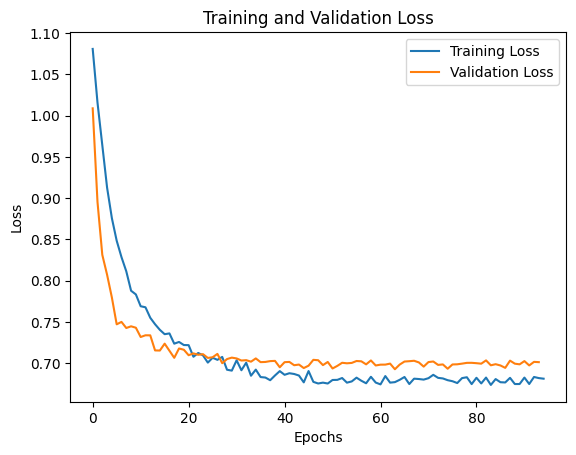

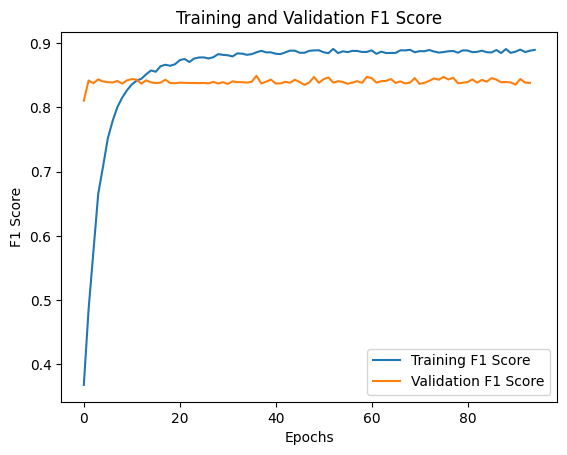

In [ ]:
# Initialize MetaClassifier and move to device
feed_forward_NN = FeedForwardNN().to(device)

# HP definition
num_epochs = 200
batch_size = 128
lr = 1e-5
weight_decay = 1e-2
model_path = "FFNN.pth"

# Training loop
train_metaclassifier(feed_forward_NN, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

In [ ]:
FFNN = FeedForwardNN()
FFNN.load_state_dict(torch.load(model_path))
FFNN = FFNN.to(device)
evaluate_metaclassifier(FFNN, test_dataset)


Test Loss: 0.6583713412284851
Test Macro F1 Score: 0.8796193867470405
Test Weighted F1 Score: [0.90783807 0.9048583  0.82616179]
Test Accuracy: 0.893491124260355


As you can see above, even though the model overfits a bit, it reaches extremely good performances!

##### <b>Convolutional NN</b>

Here, I would like to try a Convolutional architecture.</br>The reason behind this choice is the hope that the model could be capable of extracting high-order features concerning the reliability of base models.

Let's try and see!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_1d(nn.Module):
    def __init__(self):
        super(CNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, 3)  # Input tensor has shape [batch_size, 1, 6] after the unsqueeze
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(16, 32, 3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32 * 2, 64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)

        # First Convolutional Layer
        x = F.gelu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second Convolutional Layer
        x = F.gelu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FCLayers
        x = F.selu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

Epoch 0: 100%|██████████| 33/33 [00:00<00:00, 33.01it/s, training_loss=0.571]



Training Loss at end of epoch 0: 1.0762408718918308
Training F1 Score at end of epoch 0: 0.35878739742965576
New best model saved with validation loss: 1.0557010024785995

Validation Loss at end of epoch 0: 1.0557010024785995
Validation Macro F1 Score at end of epoch 0: 0.4994129560975882
Validation Weighted F1 Score at end of epoch 0: [0.62780269 0.8549323  0.01550388]


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 150.92it/s, training_loss=0.484]



Training Loss at end of epoch 1: 1.0613627939513235
Training F1 Score at end of epoch 1: 0.3776578720485064
New best model saved with validation loss: 1.0362662374973297

Validation Loss at end of epoch 1: 1.0362662374973297
Validation Macro F1 Score at end of epoch 1: 0.3413300158416379
Validation Weighted F1 Score at end of epoch 1: [0.09708738 0.88342441 0.04347826]


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 149.26it/s, training_loss=0.635]



Training Loss at end of epoch 2: 1.06096203399427
Training F1 Score at end of epoch 2: 0.39819181650498425
New best model saved with validation loss: 1.018019825220108

Validation Loss at end of epoch 2: 1.018019825220108
Validation Macro F1 Score at end of epoch 2: 0.4427239522024729
Validation Weighted F1 Score at end of epoch 2: [0.08849558 0.8852459  0.35443038]


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 152.49it/s, training_loss=0.483]



Training Loss at end of epoch 3: 1.040815492471059
Training F1 Score at end of epoch 3: 0.41038422859593493
New best model saved with validation loss: 1.005035512149334

Validation Loss at end of epoch 3: 1.005035512149334
Validation Macro F1 Score at end of epoch 3: 0.4637947570332481
Validation Weighted F1 Score at end of epoch 3: [0.09375    0.88586957 0.41176471]


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 147.87it/s, training_loss=0.486]



Training Loss at end of epoch 4: 1.0327745838598772
Training F1 Score at end of epoch 4: 0.432133290131734
New best model saved with validation loss: 0.9923207983374596

Validation Loss at end of epoch 4: 0.9923207983374596
Validation Macro F1 Score at end of epoch 4: 0.4801091473157362
Validation Weighted F1 Score at end of epoch 4: [0.13981763 0.88363636 0.41687345]


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 150.90it/s, training_loss=0.589]



Training Loss at end of epoch 5: 1.0286335674199192
Training F1 Score at end of epoch 5: 0.4408321727325501
New best model saved with validation loss: 0.9686191454529762

Validation Loss at end of epoch 5: 0.9686191454529762
Validation Macro F1 Score at end of epoch 5: 0.5599574456015304
Validation Weighted F1 Score at end of epoch 5: [0.31666667 0.88409704 0.47910864]


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 147.67it/s, training_loss=0.598]



Training Loss at end of epoch 6: 1.0197925784371116
Training F1 Score at end of epoch 6: 0.4574511045448719
New best model saved with validation loss: 0.9586010277271271

Validation Loss at end of epoch 6: 0.9586010277271271
Validation Macro F1 Score at end of epoch 6: 0.6190401840087958
Validation Weighted F1 Score at end of epoch 6: [0.45063291 0.88527552 0.52121212]


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 149.40it/s, training_loss=0.562]



Training Loss at end of epoch 7: 1.0118245933995103
Training F1 Score at end of epoch 7: 0.4773675667552917
New best model saved with validation loss: 0.9572726190090179

Validation Loss at end of epoch 7: 0.9572726190090179
Validation Macro F1 Score at end of epoch 7: 0.7269016182544519
Validation Weighted F1 Score at end of epoch 7: [0.65333333 0.88848263 0.63888889]


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 147.35it/s, training_loss=0.556]



Training Loss at end of epoch 8: 0.9996935707150083
Training F1 Score at end of epoch 8: 0.4969715246345246
New best model saved with validation loss: 0.944464847445488

Validation Loss at end of epoch 8: 0.944464847445488
Validation Macro F1 Score at end of epoch 8: 0.8249187305316176
Validation Weighted F1 Score at end of epoch 8: [0.8015873  0.88868613 0.78448276]


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 143.93it/s, training_loss=0.366]



Training Loss at end of epoch 9: 0.9795348427512429
Training F1 Score at end of epoch 9: 0.5132552800672209
New best model saved with validation loss: 0.9325494095683098

Validation Loss at end of epoch 9: 0.9325494095683098
Validation Macro F1 Score at end of epoch 9: 0.8276719296121717
Validation Weighted F1 Score at end of epoch 9: [0.812      0.88989991 0.78111588]


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 146.20it/s, training_loss=0.461]



Training Loss at end of epoch 10: 0.9780793045506333
Training F1 Score at end of epoch 10: 0.5277190440854932
New best model saved with validation loss: 0.9229534193873405

Validation Loss at end of epoch 10: 0.9229534193873405
Validation Macro F1 Score at end of epoch 10: 0.8351434781814527
Validation Weighted F1 Score at end of epoch 10: [0.82424242 0.89330922 0.78787879]


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 149.30it/s, training_loss=0.536]



Training Loss at end of epoch 11: 0.97359227772915
Training F1 Score at end of epoch 11: 0.5359096366093893
New best model saved with validation loss: 0.9109714552760124

Validation Loss at end of epoch 11: 0.9109714552760124
Validation Macro F1 Score at end of epoch 11: 0.8406262564532844
Validation Weighted F1 Score at end of epoch 11: [0.831643   0.89191644 0.79831933]


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 143.44it/s, training_loss=0.441]



Training Loss at end of epoch 12: 0.9592539252656879
Training F1 Score at end of epoch 12: 0.5559889054052047
New best model saved with validation loss: 0.8977272808551788

Validation Loss at end of epoch 12: 0.8977272808551788
Validation Macro F1 Score at end of epoch 12: 0.8386245153376469
Validation Weighted F1 Score at end of epoch 12: [0.82926829 0.89350181 0.79310345]


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 136.70it/s, training_loss=0.522]



Training Loss at end of epoch 13: 0.9575696984926859
Training F1 Score at end of epoch 13: 0.5634584426195451
New best model saved with validation loss: 0.8845675140619278

Validation Loss at end of epoch 13: 0.8845675140619278
Validation Macro F1 Score at end of epoch 13: 0.8423628776623171
Validation Weighted F1 Score at end of epoch 13: [0.83778234 0.89269612 0.79661017]


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 148.79it/s, training_loss=0.500]



Training Loss at end of epoch 14: 0.9530152389497468
Training F1 Score at end of epoch 14: 0.5676557981541959
New best model saved with validation loss: 0.87420654296875

Validation Loss at end of epoch 14: 0.87420654296875
Validation Macro F1 Score at end of epoch 14: 0.8414574980548482
Validation Weighted F1 Score at end of epoch 14: [0.83606557 0.89169675 0.79661017]


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 146.80it/s, training_loss=0.476]



Training Loss at end of epoch 15: 0.9398259520530701
Training F1 Score at end of epoch 15: 0.5965080998987173
New best model saved with validation loss: 0.8698838129639626

Validation Loss at end of epoch 15: 0.8698838129639626
Validation Macro F1 Score at end of epoch 15: 0.8433808528911627
Validation Weighted F1 Score at end of epoch 15: [0.83844581 0.89169675 0.8       ]


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 148.49it/s, training_loss=0.542]



Training Loss at end of epoch 16: 0.937155645905119
Training F1 Score at end of epoch 16: 0.6080606110160055
New best model saved with validation loss: 0.8647806495428085

Validation Loss at end of epoch 16: 0.8647806495428085
Validation Macro F1 Score at end of epoch 16: 0.8451243700203636
Validation Weighted F1 Score at end of epoch 16: [0.83910387 0.89292196 0.80334728]


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 147.60it/s, training_loss=0.387]



Training Loss at end of epoch 17: 0.9214331363186692
Training F1 Score at end of epoch 17: 0.6166520535856567
New best model saved with validation loss: 0.8563997745513916

Validation Loss at end of epoch 17: 0.8563997745513916
Validation Macro F1 Score at end of epoch 17: 0.8433808528911627
Validation Weighted F1 Score at end of epoch 17: [0.83844581 0.89169675 0.8       ]


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 126.29it/s, training_loss=0.391]



Training Loss at end of epoch 18: 0.9110784711259784
Training F1 Score at end of epoch 18: 0.6407910894185216
New best model saved with validation loss: 0.8498860150575638

Validation Loss at end of epoch 18: 0.8498860150575638
Validation Macro F1 Score at end of epoch 18: 0.8463307083100977
Validation Weighted F1 Score at end of epoch 18: [0.84210526 0.89353958 0.80334728]


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 145.81it/s, training_loss=0.523]



Training Loss at end of epoch 19: 0.9175355217673562
Training F1 Score at end of epoch 19: 0.6398308551905539
New best model saved with validation loss: 0.840580403804779

Validation Loss at end of epoch 19: 0.840580403804779
Validation Macro F1 Score at end of epoch 19: 0.8479418452610922
Validation Weighted F1 Score at end of epoch 19: [0.84317719 0.89392566 0.80672269]


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 144.15it/s, training_loss=0.422]



Training Loss at end of epoch 20: 0.9016112992257783
Training F1 Score at end of epoch 20: 0.6630174362859927
New best model saved with validation loss: 0.8339275047183037

Validation Loss at end of epoch 20: 0.8339275047183037
Validation Macro F1 Score at end of epoch 20: 0.8432227386083028
Validation Weighted F1 Score at end of epoch 20: [0.83935743 0.89031079 0.8       ]


Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 147.05it/s, training_loss=0.494]



Training Loss at end of epoch 21: 0.9026775865843801
Training F1 Score at end of epoch 21: 0.6553485501393594
New best model saved with validation loss: 0.829106293618679

Validation Loss at end of epoch 21: 0.829106293618679
Validation Macro F1 Score at end of epoch 21: 0.8464821432722306
Validation Weighted F1 Score at end of epoch 21: [0.84317719 0.89292196 0.80334728]


Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 152.80it/s, training_loss=0.430]



Training Loss at end of epoch 22: 0.8929961088931921
Training F1 Score at end of epoch 22: 0.6647308265821347
New best model saved with validation loss: 0.8234600722789764

Validation Loss at end of epoch 22: 0.8234600722789764
Validation Macro F1 Score at end of epoch 22: 0.8447540051608117
Validation Weighted F1 Score at end of epoch 22: [0.84168337 0.89092576 0.80165289]


Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 151.57it/s, training_loss=0.394]



Training Loss at end of epoch 23: 0.8841677362268622
Training F1 Score at end of epoch 23: 0.6862197913367348
New best model saved with validation loss: 0.815971314907074

Validation Loss at end of epoch 23: 0.815971314907074
Validation Macro F1 Score at end of epoch 23: 0.8447540051608117
Validation Weighted F1 Score at end of epoch 23: [0.84168337 0.89092576 0.80165289]


Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 141.45it/s, training_loss=0.376]



Training Loss at end of epoch 24: 0.8778907349615386
Training F1 Score at end of epoch 24: 0.6862538397472825
New best model saved with validation loss: 0.8042487055063248

Validation Loss at end of epoch 24: 0.8042487055063248
Validation Macro F1 Score at end of epoch 24: 0.8417046157305897
Validation Weighted F1 Score at end of epoch 24: [0.84081633 0.89090909 0.79338843]


Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 146.28it/s, training_loss=0.518]



Training Loss at end of epoch 25: 0.8804579124306188
Training F1 Score at end of epoch 25: 0.6957140331418774
New best model saved with validation loss: 0.802094042301178

Validation Loss at end of epoch 25: 0.802094042301178
Validation Macro F1 Score at end of epoch 25: 0.843706737463583
Validation Weighted F1 Score at end of epoch 25: [0.83935743 0.89010989 0.80165289]


Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 151.12it/s, training_loss=0.561]



Training Loss at end of epoch 26: 0.8756664539828445
Training F1 Score at end of epoch 26: 0.7097200951621389
New best model saved with validation loss: 0.7993645891547203

Validation Loss at end of epoch 26: 0.7993645891547203
Validation Macro F1 Score at end of epoch 26: 0.8453646407144119
Validation Weighted F1 Score at end of epoch 26: [0.84210526 0.89233577 0.80165289]


Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 150.11it/s, training_loss=0.439]



Training Loss at end of epoch 27: 0.8642559466939984
Training F1 Score at end of epoch 27: 0.7141731661611704
New best model saved with validation loss: 0.794237419962883

Validation Loss at end of epoch 27: 0.794237419962883
Validation Macro F1 Score at end of epoch 27: 0.843629993739521
Validation Weighted F1 Score at end of epoch 27: [0.84081633 0.89171975 0.79835391]


Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 148.70it/s, training_loss=0.420]



Training Loss at end of epoch 28: 0.8569882241162387
Training F1 Score at end of epoch 28: 0.7263822613601104
New best model saved with validation loss: 0.7936092466115952

Validation Loss at end of epoch 28: 0.7936092466115952
Validation Macro F1 Score at end of epoch 28: 0.8436322965133312
Validation Weighted F1 Score at end of epoch 28: [0.84040404 0.89213894 0.79835391]


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 145.05it/s, training_loss=0.432]



Training Loss at end of epoch 29: 0.8558137380715573
Training F1 Score at end of epoch 29: 0.729828535701646
New best model saved with validation loss: 0.7817171216011047

Validation Loss at end of epoch 29: 0.7817171216011047
Validation Macro F1 Score at end of epoch 29: 0.8446213317802029
Validation Weighted F1 Score at end of epoch 29: [0.84462151 0.89256198 0.7966805 ]


Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 146.23it/s, training_loss=0.529]



Training Loss at end of epoch 30: 0.8553479386098457
Training F1 Score at end of epoch 30: 0.7343948404048742
New best model saved with validation loss: 0.7764532044529915

Validation Loss at end of epoch 30: 0.7764532044529915
Validation Macro F1 Score at end of epoch 30: 0.843706737463583
Validation Weighted F1 Score at end of epoch 30: [0.83935743 0.89010989 0.80165289]


Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 143.45it/s, training_loss=0.446]



Training Loss at end of epoch 31: 0.8457237283388773
Training F1 Score at end of epoch 31: 0.7452390963983114
New best model saved with validation loss: 0.774522989988327

Validation Loss at end of epoch 31: 0.774522989988327
Validation Macro F1 Score at end of epoch 31: 0.8421430783978416
Validation Weighted F1 Score at end of epoch 31: [0.84231537 0.89072544 0.79338843]


Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 146.79it/s, training_loss=0.710]



Training Loss at end of epoch 32: 0.8535911350539236
Training F1 Score at end of epoch 32: 0.7499713104430304
New best model saved with validation loss: 0.7678255513310432

Validation Loss at end of epoch 32: 0.7678255513310432
Validation Macro F1 Score at end of epoch 32: 0.8443419204958934
Validation Weighted F1 Score at end of epoch 32: [0.84381339 0.89253188 0.7966805 ]


Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 145.05it/s, training_loss=0.333]



Training Loss at end of epoch 33: 0.825737582914757
Training F1 Score at end of epoch 33: 0.7639524245979151

Validation Loss at end of epoch 33: 0.7703042179346085
Validation Macro F1 Score at end of epoch 33: 0.8423877569121977
Validation Weighted F1 Score at end of epoch 33: [0.83935743 0.89112534 0.7966805 ]


Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 148.72it/s, training_loss=0.407]



Training Loss at end of epoch 34: 0.8257662256558737
Training F1 Score at end of epoch 34: 0.7643986137551383

Validation Loss at end of epoch 34: 0.768440842628479
Validation Macro F1 Score at end of epoch 34: 0.8451132429456756
Validation Weighted F1 Score at end of epoch 34: [0.84462151 0.89236431 0.79835391]


Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 140.94it/s, training_loss=0.409]



Training Loss at end of epoch 35: 0.8237140467672637
Training F1 Score at end of epoch 35: 0.7708991460647293
New best model saved with validation loss: 0.7656800672411919

Validation Loss at end of epoch 35: 0.7656800672411919
Validation Macro F1 Score at end of epoch 35: 0.8432885717540799
Validation Weighted F1 Score at end of epoch 35: [0.84104628 0.89213894 0.7966805 ]


Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 147.31it/s, training_loss=0.427]



Training Loss at end of epoch 36: 0.8204322547623606
Training F1 Score at end of epoch 36: 0.7724580222963606
New best model saved with validation loss: 0.7635791748762131

Validation Loss at end of epoch 36: 0.7635791748762131
Validation Macro F1 Score at end of epoch 36: 0.8423877569121977
Validation Weighted F1 Score at end of epoch 36: [0.83935743 0.89112534 0.7966805 ]


Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 147.05it/s, training_loss=0.335]



Training Loss at end of epoch 37: 0.8062296672300859
Training F1 Score at end of epoch 37: 0.7860280172089507
New best model saved with validation loss: 0.7550418078899384

Validation Loss at end of epoch 37: 0.7550418078899384
Validation Macro F1 Score at end of epoch 37: 0.8432885717540799
Validation Weighted F1 Score at end of epoch 37: [0.84104628 0.89213894 0.7966805 ]


Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 147.74it/s, training_loss=0.323]



Training Loss at end of epoch 38: 0.8046133301474832
Training F1 Score at end of epoch 38: 0.7899651246339895
New best model saved with validation loss: 0.7505120411515236

Validation Loss at end of epoch 38: 0.7505120411515236
Validation Macro F1 Score at end of epoch 38: 0.8451132429456756
Validation Weighted F1 Score at end of epoch 38: [0.84462151 0.89236431 0.79835391]


Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 139.54it/s, training_loss=0.446]



Training Loss at end of epoch 39: 0.80828267697132
Training F1 Score at end of epoch 39: 0.7879016946996278
New best model saved with validation loss: 0.7470750063657761

Validation Loss at end of epoch 39: 0.7470750063657761
Validation Macro F1 Score at end of epoch 39: 0.8423930334378342
Validation Weighted F1 Score at end of epoch 39: [0.84337349 0.89213894 0.79166667]


Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 146.95it/s, training_loss=0.419]



Training Loss at end of epoch 40: 0.8011917706691858
Training F1 Score at end of epoch 40: 0.7993329723434567
New best model saved with validation loss: 0.7422552481293678

Validation Loss at end of epoch 40: 0.7422552481293678
Validation Macro F1 Score at end of epoch 40: 0.8434360315734661
Validation Weighted F1 Score at end of epoch 40: [0.84210526 0.89152233 0.7966805 ]


Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 148.59it/s, training_loss=0.329]



Training Loss at end of epoch 41: 0.7918728897065828
Training F1 Score at end of epoch 41: 0.8015141110812728

Validation Loss at end of epoch 41: 0.7455066591501236
Validation Macro F1 Score at end of epoch 41: 0.8427822979275764
Validation Weighted F1 Score at end of epoch 41: [0.84294235 0.89032258 0.79508197]


Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 149.91it/s, training_loss=0.569]



Training Loss at end of epoch 42: 0.805902058427984
Training F1 Score at end of epoch 42: 0.7962217916652703
New best model saved with validation loss: 0.7394662350416183

Validation Loss at end of epoch 42: 0.7394662350416183
Validation Macro F1 Score at end of epoch 42: 0.8443419204958934
Validation Weighted F1 Score at end of epoch 42: [0.84381339 0.89253188 0.7966805 ]


Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 147.77it/s, training_loss=0.381]



Training Loss at end of epoch 43: 0.7891791679642417
Training F1 Score at end of epoch 43: 0.8098486819120958
New best model saved with validation loss: 0.7356246113777161

Validation Loss at end of epoch 43: 0.7356246113777161
Validation Macro F1 Score at end of epoch 43: 0.8431846871144494
Validation Weighted F1 Score at end of epoch 43: [0.84462151 0.89154412 0.79338843]


Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 146.99it/s, training_loss=0.375]



Training Loss at end of epoch 44: 0.7873513120593447
Training F1 Score at end of epoch 44: 0.8037235143957768

Validation Loss at end of epoch 44: 0.7370584458112717
Validation Macro F1 Score at end of epoch 44: 0.8423999331045108
Validation Weighted F1 Score at end of epoch 44: [0.84381339 0.89171975 0.79166667]


Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 146.75it/s, training_loss=0.369]



Training Loss at end of epoch 45: 0.7803872679219102
Training F1 Score at end of epoch 45: 0.8180072781442022
New best model saved with validation loss: 0.7347743958234787

Validation Loss at end of epoch 45: 0.7347743958234787
Validation Macro F1 Score at end of epoch 45: 0.8443419204958934
Validation Weighted F1 Score at end of epoch 45: [0.84381339 0.89253188 0.7966805 ]


Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 150.23it/s, training_loss=0.356]



Training Loss at end of epoch 46: 0.7763892755363927
Training F1 Score at end of epoch 46: 0.8230114961852597
New best model saved with validation loss: 0.7317712157964706

Validation Loss at end of epoch 46: 0.7317712157964706
Validation Macro F1 Score at end of epoch 46: 0.8435822114408081
Validation Weighted F1 Score at end of epoch 46: [0.84274194 0.8913242  0.7966805 ]


Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 150.62it/s, training_loss=0.353]



Training Loss at end of epoch 47: 0.775185657270027
Training F1 Score at end of epoch 47: 0.8208999729986198
New best model saved with validation loss: 0.7291282489895821

Validation Loss at end of epoch 47: 0.7291282489895821
Validation Macro F1 Score at end of epoch 47: 0.8470360159383573
Validation Weighted F1 Score at end of epoch 47: [0.84507042 0.89275894 0.80327869]


Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 148.67it/s, training_loss=0.343]



Training Loss at end of epoch 48: 0.7720546595978014
Training F1 Score at end of epoch 48: 0.8225822179579726
New best model saved with validation loss: 0.7287467271089554

Validation Loss at end of epoch 48: 0.7287467271089554
Validation Macro F1 Score at end of epoch 48: 0.8446213317802029
Validation Weighted F1 Score at end of epoch 48: [0.84462151 0.89256198 0.7966805 ]


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 149.59it/s, training_loss=0.299]



Training Loss at end of epoch 49: 0.7658237236918826
Training F1 Score at end of epoch 49: 0.8288405573395293
New best model saved with validation loss: 0.7261719182133675

Validation Loss at end of epoch 49: 0.7261719182133675
Validation Macro F1 Score at end of epoch 49: 0.8443363870533783
Validation Weighted F1 Score at end of epoch 49: [0.84337349 0.89295517 0.7966805 ]


Epoch 50: 100%|██████████| 33/33 [00:00<00:00, 148.47it/s, training_loss=0.458]



Training Loss at end of epoch 50: 0.7748207865339337
Training F1 Score at end of epoch 50: 0.8234387691336408
New best model saved with validation loss: 0.7250833138823509

Validation Loss at end of epoch 50: 0.7250833138823509
Validation Macro F1 Score at end of epoch 50: 0.8425318290781538
Validation Weighted F1 Score at end of epoch 50: [0.84040404 0.89051095 0.7966805 ]


Epoch 51: 100%|██████████| 33/33 [00:00<00:00, 151.35it/s, training_loss=0.318]



Training Loss at end of epoch 51: 0.7632170987851692
Training F1 Score at end of epoch 51: 0.8254219019697309

Validation Loss at end of epoch 51: 0.7251699268817902
Validation Macro F1 Score at end of epoch 51: 0.8434360315734661
Validation Weighted F1 Score at end of epoch 51: [0.84210526 0.89152233 0.7966805 ]


Epoch 52: 100%|██████████| 33/33 [00:00<00:00, 150.54it/s, training_loss=0.490]



Training Loss at end of epoch 52: 0.7705811930425239
Training F1 Score at end of epoch 52: 0.8330180283863893
New best model saved with validation loss: 0.7210856825113297

Validation Loss at end of epoch 52: 0.7210856825113297
Validation Macro F1 Score at end of epoch 52: 0.8430438496727071
Validation Weighted F1 Score at end of epoch 52: [0.844      0.89174312 0.79338843]


Epoch 53: 100%|██████████| 33/33 [00:00<00:00, 148.55it/s, training_loss=0.319]



Training Loss at end of epoch 53: 0.7566396485675465
Training F1 Score at end of epoch 53: 0.8380361760059539

Validation Loss at end of epoch 53: 0.7211876437067986
Validation Macro F1 Score at end of epoch 53: 0.8448287800653982
Validation Weighted F1 Score at end of epoch 53: [0.84337349 0.89275894 0.79835391]


Epoch 54: 100%|██████████| 33/33 [00:00<00:00, 148.82it/s, training_loss=0.293]



Training Loss at end of epoch 54: 0.7528257640925321
Training F1 Score at end of epoch 54: 0.8394064258416104
New best model saved with validation loss: 0.7195050567388535

Validation Loss at end of epoch 54: 0.7195050567388535
Validation Macro F1 Score at end of epoch 54: 0.8429011052231205
Validation Weighted F1 Score at end of epoch 54: [0.84337349 0.89194139 0.79338843]


Epoch 55: 100%|██████████| 33/33 [00:00<00:00, 149.75it/s, training_loss=0.335]



Training Loss at end of epoch 55: 0.7544891617514871
Training F1 Score at end of epoch 55: 0.8320840082701205
New best model saved with validation loss: 0.718482255935669

Validation Loss at end of epoch 55: 0.718482255935669
Validation Macro F1 Score at end of epoch 55: 0.8446954191211892
Validation Weighted F1 Score at end of epoch 55: [0.84294235 0.89114391 0.8       ]


Epoch 56: 100%|██████████| 33/33 [00:00<00:00, 143.71it/s, training_loss=0.445]



Training Loss at end of epoch 56: 0.7554601322520863
Training F1 Score at end of epoch 56: 0.8437573327263156
New best model saved with validation loss: 0.7160901129245758

Validation Loss at end of epoch 56: 0.7160901129245758
Validation Macro F1 Score at end of epoch 56: 0.8451219079805412
Validation Weighted F1 Score at end of epoch 56: [0.84507042 0.89194139 0.79835391]


Epoch 57: 100%|██████████| 33/33 [00:00<00:00, 143.96it/s, training_loss=0.398]



Training Loss at end of epoch 57: 0.7528498190822024
Training F1 Score at end of epoch 57: 0.844768868376437
New best model saved with validation loss: 0.71453458070755

Validation Loss at end of epoch 57: 0.71453458070755
Validation Macro F1 Score at end of epoch 57: 0.8459873386499509
Validation Weighted F1 Score at end of epoch 57: [0.84274194 0.89194139 0.80327869]


Epoch 58: 100%|██████████| 33/33 [00:00<00:00, 142.70it/s, training_loss=0.469]



Training Loss at end of epoch 58: 0.7549452980359396
Training F1 Score at end of epoch 58: 0.8402938225297986
New best model saved with validation loss: 0.714037612080574

Validation Loss at end of epoch 58: 0.714037612080574
Validation Macro F1 Score at end of epoch 58: 0.8436826214048093
Validation Weighted F1 Score at end of epoch 58: [0.84462151 0.89134438 0.79508197]


Epoch 59: 100%|██████████| 33/33 [00:00<00:00, 66.75it/s, training_loss=0.407]



Training Loss at end of epoch 59: 0.7468994639136575
Training F1 Score at end of epoch 59: 0.8482229486416063
New best model saved with validation loss: 0.711550384759903

Validation Loss at end of epoch 59: 0.711550384759903
Validation Macro F1 Score at end of epoch 59: 0.8467175968319335
Validation Weighted F1 Score at end of epoch 59: [0.8496994  0.89377289 0.7966805 ]


Epoch 60: 100%|██████████| 33/33 [00:00<00:00, 135.40it/s, training_loss=0.366]



Training Loss at end of epoch 60: 0.7420435547828674
Training F1 Score at end of epoch 60: 0.8463286879032007

Validation Loss at end of epoch 60: 0.7129452228546143
Validation Macro F1 Score at end of epoch 60: 0.8446213317802029
Validation Weighted F1 Score at end of epoch 60: [0.84462151 0.89256198 0.7966805 ]


Epoch 61: 100%|██████████| 33/33 [00:00<00:00, 148.58it/s, training_loss=0.525]



Training Loss at end of epoch 61: 0.7508450656226187
Training F1 Score at end of epoch 61: 0.8450431331467622
New best model saved with validation loss: 0.7088096514344215

Validation Loss at end of epoch 61: 0.7088096514344215
Validation Macro F1 Score at end of epoch 61: 0.8480820761362993
Validation Weighted F1 Score at end of epoch 61: [0.84738956 0.89357798 0.80327869]


Epoch 62: 100%|██████████| 33/33 [00:00<00:00, 140.34it/s, training_loss=0.287]



Training Loss at end of epoch 62: 0.7356410803216876
Training F1 Score at end of epoch 62: 0.8496089088696483

Validation Loss at end of epoch 62: 0.710499182343483
Validation Macro F1 Score at end of epoch 62: 0.8449719643120317
Validation Weighted F1 Score at end of epoch 62: [0.844      0.89256198 0.79835391]


Epoch 63: 100%|██████████| 33/33 [00:00<00:00, 142.29it/s, training_loss=0.331]



Training Loss at end of epoch 63: 0.7336859594691884
Training F1 Score at end of epoch 63: 0.8557783653140855
New best model saved with validation loss: 0.7073300778865814

Validation Loss at end of epoch 63: 0.7073300778865814
Validation Macro F1 Score at end of epoch 63: 0.8423999331045108
Validation Weighted F1 Score at end of epoch 63: [0.84381339 0.89171975 0.79166667]


Epoch 64: 100%|██████████| 33/33 [00:00<00:00, 146.33it/s, training_loss=0.444]



Training Loss at end of epoch 64: 0.7401865991679105
Training F1 Score at end of epoch 64: 0.8564340537623917
New best model saved with validation loss: 0.7061661258339882

Validation Loss at end of epoch 64: 0.7061661258339882
Validation Macro F1 Score at end of epoch 64: 0.8436826214048093
Validation Weighted F1 Score at end of epoch 64: [0.84462151 0.89134438 0.79508197]


Epoch 65: 100%|██████████| 33/33 [00:00<00:00, 146.50it/s, training_loss=0.454]



Training Loss at end of epoch 65: 0.7387878352945502
Training F1 Score at end of epoch 65: 0.8546943130012502
New best model saved with validation loss: 0.7048573195934296

Validation Loss at end of epoch 65: 0.7048573195934296
Validation Macro F1 Score at end of epoch 65: 0.8436826214048093
Validation Weighted F1 Score at end of epoch 65: [0.84462151 0.89134438 0.79508197]


Epoch 66: 100%|██████████| 33/33 [00:00<00:00, 136.92it/s, training_loss=0.298]



Training Loss at end of epoch 66: 0.7268797285629042
Training F1 Score at end of epoch 66: 0.8590444331417529

Validation Loss at end of epoch 66: 0.7069066762924194
Validation Macro F1 Score at end of epoch 66: 0.8440737293470993
Validation Weighted F1 Score at end of epoch 66: [0.84274194 0.89112534 0.79835391]


Epoch 67: 100%|██████████| 33/33 [00:00<00:00, 143.91it/s, training_loss=0.456]



Training Loss at end of epoch 67: 0.7349486694191442
Training F1 Score at end of epoch 67: 0.8577006679898442
New best model saved with validation loss: 0.703587681055069

Validation Loss at end of epoch 67: 0.703587681055069
Validation Macro F1 Score at end of epoch 67: 0.8468811580546084
Validation Weighted F1 Score at end of epoch 67: [0.84462151 0.89114391 0.80487805]


Epoch 68: 100%|██████████| 33/33 [00:00<00:00, 145.25it/s, training_loss=0.527]



Training Loss at end of epoch 68: 0.7372253681674148
Training F1 Score at end of epoch 68: 0.8562702769063891
New best model saved with validation loss: 0.7031800746917725

Validation Loss at end of epoch 68: 0.7031800746917725
Validation Macro F1 Score at end of epoch 68: 0.8476445789912672
Validation Weighted F1 Score at end of epoch 68: [0.84569138 0.89236431 0.80487805]


Epoch 69: 100%|██████████| 33/33 [00:00<00:00, 149.43it/s, training_loss=0.323]



Training Loss at end of epoch 69: 0.7227479562614904
Training F1 Score at end of epoch 69: 0.8607462242714777

Validation Loss at end of epoch 69: 0.7036740258336067
Validation Macro F1 Score at end of epoch 69: 0.8458131448935272
Validation Weighted F1 Score at end of epoch 69: [0.848      0.89275894 0.7966805 ]


Epoch 70: 100%|██████████| 33/33 [00:00<00:00, 143.58it/s, training_loss=0.314]



Training Loss at end of epoch 70: 0.7208404143651327
Training F1 Score at end of epoch 70: 0.8628681484569491
New best model saved with validation loss: 0.703179158270359

Validation Loss at end of epoch 70: 0.703179158270359
Validation Macro F1 Score at end of epoch 70: 0.8446954191211892
Validation Weighted F1 Score at end of epoch 70: [0.84294235 0.89114391 0.8       ]


Epoch 71: 100%|██████████| 33/33 [00:00<00:00, 147.77it/s, training_loss=0.369]



Training Loss at end of epoch 71: 0.7230859958764279
Training F1 Score at end of epoch 71: 0.8587166379908681
New best model saved with validation loss: 0.702586755156517

Validation Loss at end of epoch 71: 0.702586755156517
Validation Macro F1 Score at end of epoch 71: 0.8470196142415608
Validation Weighted F1 Score at end of epoch 71: [0.8452381  0.8909427  0.80487805]


Epoch 72: 100%|██████████| 33/33 [00:00<00:00, 145.89it/s, training_loss=0.366]



Training Loss at end of epoch 72: 0.7205637494723002
Training F1 Score at end of epoch 72: 0.8654423009283065
New best model saved with validation loss: 0.7003151476383209

Validation Loss at end of epoch 72: 0.7003151476383209
Validation Macro F1 Score at end of epoch 72: 0.8429080502710645
Validation Weighted F1 Score at end of epoch 72: [0.84381339 0.89152233 0.79338843]


Epoch 73: 100%|██████████| 33/33 [00:00<00:00, 139.72it/s, training_loss=0.433]



Training Loss at end of epoch 73: 0.7228938846877127
Training F1 Score at end of epoch 73: 0.8684566970408013
New best model saved with validation loss: 0.6994246914982796

Validation Loss at end of epoch 73: 0.6994246914982796
Validation Macro F1 Score at end of epoch 73: 0.8445845526234795
Validation Weighted F1 Score at end of epoch 73: [0.84630739 0.89236431 0.79508197]


Epoch 74: 100%|██████████| 33/33 [00:00<00:00, 147.81it/s, training_loss=0.421]



Training Loss at end of epoch 74: 0.7245790326234066
Training F1 Score at end of epoch 74: 0.8577859963239561

Validation Loss at end of epoch 74: 0.7007463201880455
Validation Macro F1 Score at end of epoch 74: 0.8425318290781538
Validation Weighted F1 Score at end of epoch 74: [0.84040404 0.89051095 0.7966805 ]


Epoch 75: 100%|██████████| 33/33 [00:00<00:00, 148.75it/s, training_loss=0.405]



Training Loss at end of epoch 75: 0.7189802039753307
Training F1 Score at end of epoch 75: 0.8643602089867648

Validation Loss at end of epoch 75: 0.6999279037117958
Validation Macro F1 Score at end of epoch 75: 0.8440859328175604
Validation Weighted F1 Score at end of epoch 75: [0.84630739 0.89256198 0.79338843]


Epoch 76: 100%|██████████| 33/33 [00:00<00:00, 146.86it/s, training_loss=0.340]



Training Loss at end of epoch 76: 0.713951461242907
Training F1 Score at end of epoch 76: 0.8662387678761121
New best model saved with validation loss: 0.6991028115153313

Validation Loss at end of epoch 76: 0.6991028115153313
Validation Macro F1 Score at end of epoch 76: 0.8499837847670738
Validation Weighted F1 Score at end of epoch 76: [0.84738956 0.89439853 0.80816327]


Epoch 77: 100%|██████████| 33/33 [00:00<00:00, 142.31it/s, training_loss=0.523]



Training Loss at end of epoch 77: 0.7250892935377179
Training F1 Score at end of epoch 77: 0.8653820895610354
New best model saved with validation loss: 0.6976575180888176

Validation Loss at end of epoch 77: 0.6976575180888176
Validation Macro F1 Score at end of epoch 77: 0.8485499866515319
Validation Weighted F1 Score at end of epoch 77: [0.84738956 0.89338235 0.80487805]


Epoch 78: 100%|██████████| 33/33 [00:00<00:00, 147.49it/s, training_loss=0.300]



Training Loss at end of epoch 78: 0.7099929470004458
Training F1 Score at end of epoch 78: 0.8730058730382564

Validation Loss at end of epoch 78: 0.6985326036810875
Validation Macro F1 Score at end of epoch 78: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 78: [0.84462151 0.89196676 0.8097166 ]


Epoch 79: 100%|██████████| 33/33 [00:00<00:00, 149.59it/s, training_loss=0.387]



Training Loss at end of epoch 79: 0.7136937018596765
Training F1 Score at end of epoch 79: 0.8704740931192417
New best model saved with validation loss: 0.6966621428728104

Validation Loss at end of epoch 79: 0.6966621428728104
Validation Macro F1 Score at end of epoch 79: 0.8468811580546084
Validation Weighted F1 Score at end of epoch 79: [0.84462151 0.89114391 0.80487805]


Epoch 80: 100%|██████████| 33/33 [00:00<00:00, 146.78it/s, training_loss=0.330]



Training Loss at end of epoch 80: 0.7098861065777865
Training F1 Score at end of epoch 80: 0.8684348212772627

Validation Loss at end of epoch 80: 0.6971935108304024
Validation Macro F1 Score at end of epoch 80: 0.843022911991698
Validation Weighted F1 Score at end of epoch 80: [0.84040404 0.89031079 0.79835391]


Epoch 81: 100%|██████████| 33/33 [00:00<00:00, 142.65it/s, training_loss=0.286]



Training Loss at end of epoch 81: 0.7064505418141683
Training F1 Score at end of epoch 81: 0.8671147550605521
New best model saved with validation loss: 0.6966613531112671

Validation Loss at end of epoch 81: 0.6966613531112671
Validation Macro F1 Score at end of epoch 81: 0.8456045139337555
Validation Weighted F1 Score at end of epoch 81: [0.84507042 0.89174312 0.8       ]


Epoch 82: 100%|██████████| 33/33 [00:00<00:00, 144.12it/s, training_loss=0.278]



Training Loss at end of epoch 82: 0.7030794403769753
Training F1 Score at end of epoch 82: 0.8678560917354959

Validation Loss at end of epoch 82: 0.6967181712388992
Validation Macro F1 Score at end of epoch 82: 0.8489071923148558
Validation Weighted F1 Score at end of epoch 82: [0.8452381  0.89176688 0.8097166 ]


Epoch 83: 100%|██████████| 33/33 [00:00<00:00, 147.26it/s, training_loss=0.319]



Training Loss at end of epoch 83: 0.7039852196520026
Training F1 Score at end of epoch 83: 0.8722579148382659
New best model saved with validation loss: 0.6952285915613174

Validation Loss at end of epoch 83: 0.6952285915613174
Validation Macro F1 Score at end of epoch 83: 0.8443771830060404
Validation Weighted F1 Score at end of epoch 83: [0.848      0.89174312 0.79338843]


Epoch 84: 100%|██████████| 33/33 [00:00<00:00, 141.69it/s, training_loss=0.303]



Training Loss at end of epoch 84: 0.7044440833005038
Training F1 Score at end of epoch 84: 0.8666621559058432

Validation Loss at end of epoch 84: 0.6956179961562157
Validation Macro F1 Score at end of epoch 84: 0.8479210989496213
Validation Weighted F1 Score at end of epoch 84: [0.84691849 0.89196676 0.80487805]


Epoch 85: 100%|██████████| 33/33 [00:00<00:00, 141.10it/s, training_loss=0.379]



Training Loss at end of epoch 85: 0.7060662869251135
Training F1 Score at end of epoch 85: 0.8715340729091544

Validation Loss at end of epoch 85: 0.6955796033143997
Validation Macro F1 Score at end of epoch 85: 0.8443771830060404
Validation Weighted F1 Score at end of epoch 85: [0.848      0.89174312 0.79338843]


Epoch 86: 100%|██████████| 33/33 [00:00<00:00, 151.26it/s, training_loss=0.437]



Training Loss at end of epoch 86: 0.7093422485120369
Training F1 Score at end of epoch 86: 0.8680007540176219
New best model saved with validation loss: 0.6943196728825569

Validation Loss at end of epoch 86: 0.6943196728825569
Validation Macro F1 Score at end of epoch 86: 0.8456750751390544
Validation Weighted F1 Score at end of epoch 86: [0.84738956 0.89295517 0.7966805 ]


Epoch 87: 100%|██████████| 33/33 [00:00<00:00, 148.57it/s, training_loss=0.392]



Training Loss at end of epoch 87: 0.7043662360220244
Training F1 Score at end of epoch 87: 0.8701066565162136
New best model saved with validation loss: 0.6942747682332993

Validation Loss at end of epoch 87: 0.6942747682332993
Validation Macro F1 Score at end of epoch 87: 0.8468811580546084
Validation Weighted F1 Score at end of epoch 87: [0.84462151 0.89114391 0.80487805]


Epoch 88: 100%|██████████| 33/33 [00:00<00:00, 150.21it/s, training_loss=0.298]



Training Loss at end of epoch 88: 0.7002771839951024
Training F1 Score at end of epoch 88: 0.873758189207321
New best model saved with validation loss: 0.6930951401591301

Validation Loss at end of epoch 88: 0.6930951401591301
Validation Macro F1 Score at end of epoch 88: 0.8445558972236183
Validation Weighted F1 Score at end of epoch 88: [0.84274194 0.89092576 0.8       ]


Epoch 89: 100%|██████████| 33/33 [00:00<00:00, 147.65it/s, training_loss=0.342]



Training Loss at end of epoch 89: 0.7006722237124587
Training F1 Score at end of epoch 89: 0.8706207069215962
New best model saved with validation loss: 0.6927464306354523

Validation Loss at end of epoch 89: 0.6927464306354523
Validation Macro F1 Score at end of epoch 89: 0.8485499866515319
Validation Weighted F1 Score at end of epoch 89: [0.84738956 0.89338235 0.80487805]


Epoch 90: 100%|██████████| 33/33 [00:00<00:00, 145.81it/s, training_loss=0.419]



Training Loss at end of epoch 90: 0.7052588137713346
Training F1 Score at end of epoch 90: 0.8687034632755196

Validation Loss at end of epoch 90: 0.6930652931332588
Validation Macro F1 Score at end of epoch 90: 0.8468811580546084
Validation Weighted F1 Score at end of epoch 90: [0.84462151 0.89114391 0.80487805]


Epoch 91: 100%|██████████| 33/33 [00:00<00:00, 143.72it/s, training_loss=0.335]



Training Loss at end of epoch 91: 0.6970696792458043
Training F1 Score at end of epoch 91: 0.8748097566336765

Validation Loss at end of epoch 91: 0.6930378898978233
Validation Macro F1 Score at end of epoch 91: 0.8448753616200579
Validation Weighted F1 Score at end of epoch 91: [0.848      0.89154412 0.79508197]


Epoch 92: 100%|██████████| 33/33 [00:00<00:00, 148.45it/s, training_loss=0.554]



Training Loss at end of epoch 92: 0.7095383170879248
Training F1 Score at end of epoch 92: 0.8733841821492275

Validation Loss at end of epoch 92: 0.6932821199297905
Validation Macro F1 Score at end of epoch 92: 0.8456045139337555
Validation Weighted F1 Score at end of epoch 92: [0.84507042 0.89174312 0.8       ]


Epoch 93: 100%|██████████| 33/33 [00:00<00:00, 142.04it/s, training_loss=0.473]



Training Loss at end of epoch 93: 0.7038414965976368
Training F1 Score at end of epoch 93: 0.8732558935089639
New best model saved with validation loss: 0.6915317848324776

Validation Loss at end of epoch 93: 0.6915317848324776
Validation Macro F1 Score at end of epoch 93: 0.8458839227622104
Validation Weighted F1 Score at end of epoch 93: [0.84630739 0.89134438 0.8       ]


Epoch 94: 100%|██████████| 33/33 [00:00<00:00, 149.05it/s, training_loss=0.560]



Training Loss at end of epoch 94: 0.7090068423386776
Training F1 Score at end of epoch 94: 0.8747422173424225
New best model saved with validation loss: 0.6913850754499435

Validation Loss at end of epoch 94: 0.6913850754499435
Validation Macro F1 Score at end of epoch 94: 0.8429603827568729
Validation Weighted F1 Score at end of epoch 94: [0.84146341 0.89233577 0.79508197]


Epoch 95: 100%|██████████| 33/33 [00:00<00:00, 146.75it/s, training_loss=0.361]



Training Loss at end of epoch 95: 0.6948811177051428
Training F1 Score at end of epoch 95: 0.8786901554658936
New best model saved with validation loss: 0.6912392899394035

Validation Loss at end of epoch 95: 0.6912392899394035
Validation Macro F1 Score at end of epoch 95: 0.8448713665218843
Validation Weighted F1 Score at end of epoch 95: [0.84146341 0.89315068 0.8       ]


Epoch 96: 100%|██████████| 33/33 [00:00<00:00, 147.65it/s, training_loss=0.446]



Training Loss at end of epoch 96: 0.6999172496073174
Training F1 Score at end of epoch 96: 0.8758188321543013

Validation Loss at end of epoch 96: 0.6913944408297539
Validation Macro F1 Score at end of epoch 96: 0.8468811580546084
Validation Weighted F1 Score at end of epoch 96: [0.84462151 0.89114391 0.80487805]


Epoch 97: 100%|██████████| 33/33 [00:00<00:00, 143.27it/s, training_loss=0.280]



Training Loss at end of epoch 97: 0.6896882869980552
Training F1 Score at end of epoch 97: 0.8751488807512683
New best model saved with validation loss: 0.6910712271928787

Validation Loss at end of epoch 97: 0.6910712271928787
Validation Macro F1 Score at end of epoch 97: 0.8440737293470993
Validation Weighted F1 Score at end of epoch 97: [0.84274194 0.89112534 0.79835391]


Epoch 98: 100%|██████████| 33/33 [00:00<00:00, 148.85it/s, training_loss=0.291]



Training Loss at end of epoch 98: 0.6891424023743832
Training F1 Score at end of epoch 98: 0.8760808101672702
New best model saved with validation loss: 0.6910526528954506

Validation Loss at end of epoch 98: 0.6910526528954506
Validation Macro F1 Score at end of epoch 98: 0.8495938931362699
Validation Weighted F1 Score at end of epoch 98: [0.8496994  0.89420423 0.80487805]


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 148.37it/s, training_loss=0.521]



Training Loss at end of epoch 99: 0.7028522635951187
Training F1 Score at end of epoch 99: 0.8762998380794773
New best model saved with validation loss: 0.6905397549271584

Validation Loss at end of epoch 99: 0.6905397549271584
Validation Macro F1 Score at end of epoch 99: 0.8477837775425133
Validation Weighted F1 Score at end of epoch 99: [0.84630739 0.8921659  0.80487805]


Epoch 100: 100%|██████████| 33/33 [00:00<00:00, 149.31it/s, training_loss=0.294]



Training Loss at end of epoch 100: 0.6905709505081177
Training F1 Score at end of epoch 100: 0.8699305930581129

Validation Loss at end of epoch 100: 0.6907147467136383
Validation Macro F1 Score at end of epoch 100: 0.8456045139337555
Validation Weighted F1 Score at end of epoch 100: [0.84507042 0.89174312 0.8       ]


Epoch 101: 100%|██████████| 33/33 [00:00<00:00, 144.20it/s, training_loss=0.351]



Training Loss at end of epoch 101: 0.6919159293174744
Training F1 Score at end of epoch 101: 0.8740427564404828
New best model saved with validation loss: 0.6898779720067978

Validation Loss at end of epoch 101: 0.6898779720067978
Validation Macro F1 Score at end of epoch 101: 0.8425433009547234
Validation Weighted F1 Score at end of epoch 101: [0.83975659 0.89112534 0.79674797]


Epoch 102: 100%|██████████| 33/33 [00:00<00:00, 143.78it/s, training_loss=0.303]



Training Loss at end of epoch 102: 0.6864309058044896
Training F1 Score at end of epoch 102: 0.8799256320139168

Validation Loss at end of epoch 102: 0.690175011754036
Validation Macro F1 Score at end of epoch 102: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 102: [0.84462151 0.89196676 0.8097166 ]


Epoch 103: 100%|██████████| 33/33 [00:00<00:00, 149.26it/s, training_loss=0.570]



Training Loss at end of epoch 103: 0.7023628083142367
Training F1 Score at end of epoch 103: 0.8765157264955699
New best model saved with validation loss: 0.6889932453632355

Validation Loss at end of epoch 103: 0.6889932453632355
Validation Macro F1 Score at end of epoch 103: 0.8458839227622104
Validation Weighted F1 Score at end of epoch 103: [0.84630739 0.89134438 0.8       ]


Epoch 104: 100%|██████████| 33/33 [00:00<00:00, 144.13it/s, training_loss=0.467]



Training Loss at end of epoch 104: 0.6955426714637063
Training F1 Score at end of epoch 104: 0.8780558368288366

Validation Loss at end of epoch 104: 0.6900006532669067
Validation Macro F1 Score at end of epoch 104: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 104: [0.84462151 0.89279113 0.81451613]


Epoch 105: 100%|██████████| 33/33 [00:00<00:00, 144.69it/s, training_loss=0.535]



Training Loss at end of epoch 105: 0.7002557389663927
Training F1 Score at end of epoch 105: 0.878783034056203
New best model saved with validation loss: 0.6885313615202904

Validation Loss at end of epoch 105: 0.6885313615202904
Validation Macro F1 Score at end of epoch 105: 0.842644597602292
Validation Weighted F1 Score at end of epoch 105: [0.84274194 0.89010989 0.79508197]


Epoch 106: 100%|██████████| 33/33 [00:00<00:00, 148.85it/s, training_loss=0.528]



Training Loss at end of epoch 106: 0.6991197015299941
Training F1 Score at end of epoch 106: 0.8758791728482187

Validation Loss at end of epoch 106: 0.6885722205042839
Validation Macro F1 Score at end of epoch 106: 0.8456045139337555
Validation Weighted F1 Score at end of epoch 106: [0.84507042 0.89174312 0.8       ]


Epoch 107: 100%|██████████| 33/33 [00:00<00:00, 143.99it/s, training_loss=0.315]



Training Loss at end of epoch 107: 0.6835811300711199
Training F1 Score at end of epoch 107: 0.8830030349722401

Validation Loss at end of epoch 107: 0.6891379132866859
Validation Macro F1 Score at end of epoch 107: 0.8458839227622104
Validation Weighted F1 Score at end of epoch 107: [0.84630739 0.89134438 0.8       ]


Epoch 108: 100%|██████████| 33/33 [00:00<00:00, 140.54it/s, training_loss=0.290]



Training Loss at end of epoch 108: 0.6840069944208319
Training F1 Score at end of epoch 108: 0.8769782517565682

Validation Loss at end of epoch 108: 0.6887508481740952
Validation Macro F1 Score at end of epoch 108: 0.8425318290781538
Validation Weighted F1 Score at end of epoch 108: [0.84040404 0.89051095 0.7966805 ]


Epoch 109: 100%|██████████| 33/33 [00:00<00:00, 143.42it/s, training_loss=0.305]



Training Loss at end of epoch 109: 0.6823606328530745
Training F1 Score at end of epoch 109: 0.879598454026826

Validation Loss at end of epoch 109: 0.6894532069563866
Validation Macro F1 Score at end of epoch 109: 0.8497417858243
Validation Weighted F1 Score at end of epoch 109: [0.84294235 0.89176688 0.81451613]


Epoch 110: 100%|██████████| 33/33 [00:00<00:00, 138.82it/s, training_loss=0.304]



Training Loss at end of epoch 110: 0.682608091469967
Training F1 Score at end of epoch 110: 0.8753440634596377

Validation Loss at end of epoch 110: 0.6891091391444206
Validation Macro F1 Score at end of epoch 110: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 110: [0.84462151 0.89279113 0.81451613]


Epoch 111: 100%|██████████| 33/33 [00:00<00:00, 141.80it/s, training_loss=0.287]



Training Loss at end of epoch 111: 0.6791922612623735
Training F1 Score at end of epoch 111: 0.8810345673467374
New best model saved with validation loss: 0.6882980465888977

Validation Loss at end of epoch 111: 0.6882980465888977
Validation Macro F1 Score at end of epoch 111: 0.8429292831886853
Validation Weighted F1 Score at end of epoch 111: [0.844      0.88970588 0.79508197]


Epoch 112: 100%|██████████| 33/33 [00:00<00:00, 143.58it/s, training_loss=0.278]



Training Loss at end of epoch 112: 0.6816814975305037
Training F1 Score at end of epoch 112: 0.8794825102281489

Validation Loss at end of epoch 112: 0.6888717710971832
Validation Macro F1 Score at end of epoch 112: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 112: [0.84462151 0.89196676 0.8097166 ]


Epoch 113: 100%|██████████| 33/33 [00:00<00:00, 144.61it/s, training_loss=0.515]



Training Loss at end of epoch 113: 0.6936815868724476
Training F1 Score at end of epoch 113: 0.8811254493460514

Validation Loss at end of epoch 113: 0.6884308159351349
Validation Macro F1 Score at end of epoch 113: 0.8456045139337555
Validation Weighted F1 Score at end of epoch 113: [0.84507042 0.89174312 0.8       ]


Epoch 114: 100%|██████████| 33/33 [00:00<00:00, 143.34it/s, training_loss=0.351]



Training Loss at end of epoch 114: 0.6829314159624504
Training F1 Score at end of epoch 114: 0.8773773451037695
New best model saved with validation loss: 0.6876362860202789

Validation Loss at end of epoch 114: 0.6876362860202789
Validation Macro F1 Score at end of epoch 114: 0.8419027235013582
Validation Weighted F1 Score at end of epoch 114: [0.83910387 0.89152233 0.79508197]


Epoch 115: 100%|██████████| 33/33 [00:00<00:00, 145.87it/s, training_loss=0.404]



Training Loss at end of epoch 115: 0.6860855239810366
Training F1 Score at end of epoch 115: 0.8813582183445378
New best model saved with validation loss: 0.6871788576245308

Validation Loss at end of epoch 115: 0.6871788576245308
Validation Macro F1 Score at end of epoch 115: 0.8435822114408081
Validation Weighted F1 Score at end of epoch 115: [0.84274194 0.8913242  0.7966805 ]


Epoch 116: 100%|██████████| 33/33 [00:00<00:00, 139.11it/s, training_loss=0.304]



Training Loss at end of epoch 116: 0.6761457667206273
Training F1 Score at end of epoch 116: 0.8878562363934366

Validation Loss at end of epoch 116: 0.6881672143936157
Validation Macro F1 Score at end of epoch 116: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 116: [0.84462151 0.89196676 0.8097166 ]


Epoch 117: 100%|██████████| 33/33 [00:00<00:00, 142.18it/s, training_loss=0.302]



Training Loss at end of epoch 117: 0.6787989862037428
Training F1 Score at end of epoch 117: 0.8769698125866751

Validation Loss at end of epoch 117: 0.6872645393013954
Validation Macro F1 Score at end of epoch 117: 0.844699643385295
Validation Weighted F1 Score at end of epoch 117: [0.84337349 0.89072544 0.8       ]


Epoch 118: 100%|██████████| 33/33 [00:00<00:00, 143.92it/s, training_loss=0.309]



Training Loss at end of epoch 118: 0.6777769941272158
Training F1 Score at end of epoch 118: 0.8812437128757377
New best model saved with validation loss: 0.6864585652947426

Validation Loss at end of epoch 118: 0.6864585652947426
Validation Macro F1 Score at end of epoch 118: 0.8425318290781538
Validation Weighted F1 Score at end of epoch 118: [0.84040404 0.89051095 0.7966805 ]


Epoch 119: 100%|██████████| 33/33 [00:00<00:00, 148.64it/s, training_loss=0.293]



Training Loss at end of epoch 119: 0.677095064611146
Training F1 Score at end of epoch 119: 0.8815544885168941

Validation Loss at end of epoch 119: 0.6875871196389198
Validation Macro F1 Score at end of epoch 119: 0.8439712438224981
Validation Weighted F1 Score at end of epoch 119: [0.84630739 0.89052438 0.79508197]


Epoch 120: 100%|██████████| 33/33 [00:00<00:00, 144.88it/s, training_loss=0.293]



Training Loss at end of epoch 120: 0.6748803601120458
Training F1 Score at end of epoch 120: 0.8856147011173316

Validation Loss at end of epoch 120: 0.6869457587599754
Validation Macro F1 Score at end of epoch 120: 0.844699643385295
Validation Weighted F1 Score at end of epoch 120: [0.84337349 0.89072544 0.8       ]


Epoch 121: 100%|██████████| 33/33 [00:00<00:00, 146.01it/s, training_loss=0.308]



Training Loss at end of epoch 121: 0.6754779743425774
Training F1 Score at end of epoch 121: 0.8837788742249745

Validation Loss at end of epoch 121: 0.6878308281302452
Validation Macro F1 Score at end of epoch 121: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 121: [0.84462151 0.89279113 0.81451613]


Epoch 122: 100%|██████████| 33/33 [00:00<00:00, 67.49it/s, training_loss=0.378]



Training Loss at end of epoch 122: 0.6813401381174723
Training F1 Score at end of epoch 122: 0.8788101036103636

Validation Loss at end of epoch 122: 0.687133826315403
Validation Macro F1 Score at end of epoch 122: 0.8429292831886853
Validation Weighted F1 Score at end of epoch 122: [0.844      0.88970588 0.79508197]


Epoch 123: 100%|██████████| 33/33 [00:00<00:00, 145.74it/s, training_loss=0.329]



Training Loss at end of epoch 123: 0.6776046337503375
Training F1 Score at end of epoch 123: 0.8821166409288742

Validation Loss at end of epoch 123: 0.687598891556263
Validation Macro F1 Score at end of epoch 123: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 123: [0.84462151 0.89279113 0.81451613]


Epoch 124: 100%|██████████| 33/33 [00:00<00:00, 147.20it/s, training_loss=0.348]



Training Loss at end of epoch 124: 0.6786110690145781
Training F1 Score at end of epoch 124: 0.8829285957595947
New best model saved with validation loss: 0.6862847357988358

Validation Loss at end of epoch 124: 0.6862847357988358
Validation Macro F1 Score at end of epoch 124: 0.841593841514349
Validation Weighted F1 Score at end of epoch 124: [0.84040404 0.88929552 0.79508197]


Epoch 125: 100%|██████████| 33/33 [00:00<00:00, 146.22it/s, training_loss=0.501]



Training Loss at end of epoch 125: 0.6877421556097089
Training F1 Score at end of epoch 125: 0.8818818297805864
New best model saved with validation loss: 0.6861511170864105

Validation Loss at end of epoch 125: 0.6861511170864105
Validation Macro F1 Score at end of epoch 125: 0.8434360315734661
Validation Weighted F1 Score at end of epoch 125: [0.84210526 0.89152233 0.7966805 ]


Epoch 126: 100%|██████████| 33/33 [00:00<00:00, 146.19it/s, training_loss=0.523]



Training Loss at end of epoch 126: 0.6884625897263036
Training F1 Score at end of epoch 126: 0.8790665907831704

Validation Loss at end of epoch 126: 0.6865558326244354
Validation Macro F1 Score at end of epoch 126: 0.8427879060232507
Validation Weighted F1 Score at end of epoch 126: [0.84337349 0.88990826 0.79508197]


Epoch 127: 100%|██████████| 33/33 [00:00<00:00, 142.84it/s, training_loss=0.276]



Training Loss at end of epoch 127: 0.6728013519084814
Training F1 Score at end of epoch 127: 0.8813689581943707

Validation Loss at end of epoch 127: 0.6869345009326935
Validation Macro F1 Score at end of epoch 127: 0.8447366095038117
Validation Weighted F1 Score at end of epoch 127: [0.84104628 0.89154412 0.80161943]


Epoch 128: 100%|██████████| 33/33 [00:00<00:00, 145.69it/s, training_loss=0.532]



Training Loss at end of epoch 128: 0.6882295807202657
Training F1 Score at end of epoch 128: 0.8802907109526409

Validation Loss at end of epoch 128: 0.6864519417285919
Validation Macro F1 Score at end of epoch 128: 0.8515456651109661
Validation Weighted F1 Score at end of epoch 128: [0.84630739 0.89381348 0.81451613]


Epoch 129: 100%|██████████| 33/33 [00:00<00:00, 145.72it/s, training_loss=0.355]



Training Loss at end of epoch 129: 0.6755706378907869
Training F1 Score at end of epoch 129: 0.8856466455504841

Validation Loss at end of epoch 129: 0.6867769956588745
Validation Macro F1 Score at end of epoch 129: 0.8515456651109661
Validation Weighted F1 Score at end of epoch 129: [0.84630739 0.89381348 0.81451613]


Epoch 130: 100%|██████████| 33/33 [00:00<00:00, 141.68it/s, training_loss=0.378]



Training Loss at end of epoch 130: 0.6774049166477087
Training F1 Score at end of epoch 130: 0.8819923220642584

Validation Loss at end of epoch 130: 0.6866544932126999
Validation Macro F1 Score at end of epoch 130: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 130: [0.84462151 0.89196676 0.8097166 ]


Epoch 131: 100%|██████████| 33/33 [00:00<00:00, 136.94it/s, training_loss=0.475]



Training Loss at end of epoch 131: 0.6820226040753451
Training F1 Score at end of epoch 131: 0.8813923834627779
New best model saved with validation loss: 0.6857995912432671

Validation Loss at end of epoch 131: 0.6857995912432671
Validation Macro F1 Score at end of epoch 131: 0.840634704364
Validation Weighted F1 Score at end of epoch 131: [0.83975659 0.89031079 0.79183673]


Epoch 132: 100%|██████████| 33/33 [00:00<00:00, 146.62it/s, training_loss=0.281]



Training Loss at end of epoch 132: 0.6713960658420216
Training F1 Score at end of epoch 132: 0.8820283730490378

Validation Loss at end of epoch 132: 0.6867832615971565
Validation Macro F1 Score at end of epoch 132: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 132: [0.84462151 0.89279113 0.81451613]


Epoch 133: 100%|██████████| 33/33 [00:00<00:00, 147.25it/s, training_loss=0.296]



Training Loss at end of epoch 133: 0.6718277136484782
Training F1 Score at end of epoch 133: 0.885294687486482

Validation Loss at end of epoch 133: 0.6866789758205414
Validation Macro F1 Score at end of epoch 133: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 133: [0.84462151 0.89196676 0.8097166 ]


Epoch 134: 100%|██████████| 33/33 [00:00<00:00, 146.81it/s, training_loss=0.293]



Training Loss at end of epoch 134: 0.6682791348659631
Training F1 Score at end of epoch 134: 0.887128651145594

Validation Loss at end of epoch 134: 0.6868578568100929
Validation Macro F1 Score at end of epoch 134: 0.8497417858243
Validation Weighted F1 Score at end of epoch 134: [0.84294235 0.89176688 0.81451613]


Epoch 135: 100%|██████████| 33/33 [00:00<00:00, 145.71it/s, training_loss=0.294]



Training Loss at end of epoch 135: 0.6701072255770365
Training F1 Score at end of epoch 135: 0.8845970769691274

Validation Loss at end of epoch 135: 0.6866027042269707
Validation Macro F1 Score at end of epoch 135: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 135: [0.84462151 0.89279113 0.81451613]


Epoch 136: 100%|██████████| 33/33 [00:00<00:00, 143.02it/s, training_loss=0.282]



Training Loss at end of epoch 136: 0.6670186736366965
Training F1 Score at end of epoch 136: 0.8849740002561656

Validation Loss at end of epoch 136: 0.6861522197723389
Validation Macro F1 Score at end of epoch 136: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 136: [0.84462151 0.89196676 0.8097166 ]


Epoch 137: 100%|██████████| 33/33 [00:00<00:00, 147.54it/s, training_loss=0.293]



Training Loss at end of epoch 137: 0.6680862217238455
Training F1 Score at end of epoch 137: 0.883535473060293

Validation Loss at end of epoch 137: 0.6862741485238075
Validation Macro F1 Score at end of epoch 137: 0.8487682907124255
Validation Weighted F1 Score at end of epoch 137: [0.84462151 0.89196676 0.8097166 ]


Epoch 138: 100%|██████████| 33/33 [00:00<00:00, 142.34it/s, training_loss=0.294]



Training Loss at end of epoch 138: 0.6674326333132657
Training F1 Score at end of epoch 138: 0.8864732279515709
New best model saved with validation loss: 0.6852106377482414

Validation Loss at end of epoch 138: 0.6852106377482414
Validation Macro F1 Score at end of epoch 138: 0.8428100566273868
Validation Weighted F1 Score at end of epoch 138: [0.84081633 0.89253188 0.79508197]


Epoch 139: 100%|██████████| 33/33 [00:00<00:00, 141.19it/s, training_loss=0.278]



Training Loss at end of epoch 139: 0.6674312551816305
Training F1 Score at end of epoch 139: 0.8823956677477365

Validation Loss at end of epoch 139: 0.6857110112905502
Validation Macro F1 Score at end of epoch 139: 0.8427879060232507
Validation Weighted F1 Score at end of epoch 139: [0.84337349 0.88990826 0.79508197]


Epoch 140: 100%|██████████| 33/33 [00:00<00:00, 130.95it/s, training_loss=0.376]



Training Loss at end of epoch 140: 0.6739463173981869
Training F1 Score at end of epoch 140: 0.8823970633125976

Validation Loss at end of epoch 140: 0.6860512122511864
Validation Macro F1 Score at end of epoch 140: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 140: [0.84462151 0.89279113 0.81451613]


Epoch 141: 100%|██████████| 33/33 [00:00<00:00, 143.30it/s, training_loss=0.283]



Training Loss at end of epoch 141: 0.6656305320335157
Training F1 Score at end of epoch 141: 0.8869783352768487

Validation Loss at end of epoch 141: 0.6854654774069786
Validation Macro F1 Score at end of epoch 141: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 141: [0.83870968 0.88990826 0.79674797]


Epoch 142: 100%|██████████| 33/33 [00:00<00:00, 143.72it/s, training_loss=0.361]



Training Loss at end of epoch 142: 0.6720687223203254
Training F1 Score at end of epoch 142: 0.8803193521779988

Validation Loss at end of epoch 142: 0.6859235242009163
Validation Macro F1 Score at end of epoch 142: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 142: [0.84462151 0.89279113 0.81451613]


Epoch 143: 100%|██████████| 33/33 [00:00<00:00, 142.13it/s, training_loss=0.283]



Training Loss at end of epoch 143: 0.6659231745835507
Training F1 Score at end of epoch 143: 0.8855374609493172

Validation Loss at end of epoch 143: 0.6857850775122643
Validation Macro F1 Score at end of epoch 143: 0.8515456651109661
Validation Weighted F1 Score at end of epoch 143: [0.84630739 0.89381348 0.81451613]


Epoch 144: 100%|██████████| 33/33 [00:00<00:00, 138.17it/s, training_loss=0.295]



Training Loss at end of epoch 144: 0.6670901052879564
Training F1 Score at end of epoch 144: 0.8843945426329342
New best model saved with validation loss: 0.6851508021354675

Validation Loss at end of epoch 144: 0.6851508021354675
Validation Macro F1 Score at end of epoch 144: 0.8426925880235666
Validation Weighted F1 Score at end of epoch 144: [0.84040404 0.89092576 0.79674797]


Epoch 145: 100%|██████████| 33/33 [00:00<00:00, 144.66it/s, training_loss=0.278]



Training Loss at end of epoch 145: 0.6681097673647332
Training F1 Score at end of epoch 145: 0.8815627089107975

Validation Loss at end of epoch 145: 0.6854603141546249
Validation Macro F1 Score at end of epoch 145: 0.8477837775425133
Validation Weighted F1 Score at end of epoch 145: [0.84630739 0.8921659  0.80487805]


Epoch 146: 100%|██████████| 33/33 [00:00<00:00, 144.47it/s, training_loss=0.277]



Training Loss at end of epoch 146: 0.6658985903768828
Training F1 Score at end of epoch 146: 0.884941438772152
New best model saved with validation loss: 0.6850736513733864

Validation Loss at end of epoch 146: 0.6850736513733864
Validation Macro F1 Score at end of epoch 146: 0.8417402734992697
Validation Weighted F1 Score at end of epoch 146: [0.84104628 0.88909258 0.79508197]


Epoch 147: 100%|██████████| 33/33 [00:00<00:00, 145.58it/s, training_loss=0.315]



Training Loss at end of epoch 147: 0.6690471136208737
Training F1 Score at end of epoch 147: 0.8854930501691669
New best model saved with validation loss: 0.684934988617897

Validation Loss at end of epoch 147: 0.684934988617897
Validation Macro F1 Score at end of epoch 147: 0.8408631754615752
Validation Weighted F1 Score at end of epoch 147: [0.84337349 0.88909258 0.79012346]


Epoch 148: 100%|██████████| 33/33 [00:00<00:00, 146.70it/s, training_loss=0.308]



Training Loss at end of epoch 148: 0.6668492465308218
Training F1 Score at end of epoch 148: 0.885621641141143
New best model saved with validation loss: 0.6847612634301186

Validation Loss at end of epoch 148: 0.6847612634301186
Validation Macro F1 Score at end of epoch 148: 0.8408865095145552
Validation Weighted F1 Score at end of epoch 148: [0.84081633 0.89171975 0.79012346]


Epoch 149: 100%|██████████| 33/33 [00:00<00:00, 142.64it/s, training_loss=0.288]



Training Loss at end of epoch 149: 0.6655892874255325
Training F1 Score at end of epoch 149: 0.8824124803143275

Validation Loss at end of epoch 149: 0.6860148832201958
Validation Macro F1 Score at end of epoch 149: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 149: [0.84462151 0.89279113 0.81451613]


Epoch 150: 100%|██████████| 33/33 [00:00<00:00, 143.03it/s, training_loss=0.289]



Training Loss at end of epoch 150: 0.6664457537911155
Training F1 Score at end of epoch 150: 0.8853120843918285

Validation Loss at end of epoch 150: 0.6859500706195831
Validation Macro F1 Score at end of epoch 150: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 150: [0.84462151 0.89279113 0.81451613]


Epoch 151: 100%|██████████| 33/33 [00:00<00:00, 147.72it/s, training_loss=0.278]



Training Loss at end of epoch 151: 0.6651872125538912
Training F1 Score at end of epoch 151: 0.8831369662491403

Validation Loss at end of epoch 151: 0.685267336666584
Validation Macro F1 Score at end of epoch 151: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 151: [0.83870968 0.88990826 0.79674797]


Epoch 152: 100%|██████████| 33/33 [00:00<00:00, 148.19it/s, training_loss=0.363]



Training Loss at end of epoch 152: 0.6700478394826254
Training F1 Score at end of epoch 152: 0.8818394282478742

Validation Loss at end of epoch 152: 0.6850374937057495
Validation Macro F1 Score at end of epoch 152: 0.8419370931838306
Validation Weighted F1 Score at end of epoch 152: [0.83935743 0.88970588 0.79674797]


Epoch 153: 100%|██████████| 33/33 [00:00<00:00, 144.67it/s, training_loss=0.526]



Training Loss at end of epoch 153: 0.6791100646510269
Training F1 Score at end of epoch 153: 0.883187786173005
New best model saved with validation loss: 0.6847609207034111

Validation Loss at end of epoch 153: 0.6847609207034111
Validation Macro F1 Score at end of epoch 153: 0.8398796625773103
Validation Weighted F1 Score at end of epoch 153: [0.83870968 0.88909258 0.79183673]


Epoch 154: 100%|██████████| 33/33 [00:00<00:00, 146.16it/s, training_loss=0.278]



Training Loss at end of epoch 154: 0.664696039575519
Training F1 Score at end of epoch 154: 0.8836286640732466

Validation Loss at end of epoch 154: 0.6848721280694008
Validation Macro F1 Score at end of epoch 154: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 154: [0.83870968 0.88990826 0.79674797]


Epoch 155: 100%|██████████| 33/33 [00:00<00:00, 141.87it/s, training_loss=0.289]



Training Loss at end of epoch 155: 0.6641557595946572
Training F1 Score at end of epoch 155: 0.8863038669559108

Validation Loss at end of epoch 155: 0.6848650276660919
Validation Macro F1 Score at end of epoch 155: 0.8407835550692694
Validation Weighted F1 Score at end of epoch 155: [0.84040404 0.89010989 0.79183673]


Epoch 156: 100%|██████████| 33/33 [00:00<00:00, 144.72it/s, training_loss=0.293]



Training Loss at end of epoch 156: 0.6644142974506725
Training F1 Score at end of epoch 156: 0.8822465729784047

Validation Loss at end of epoch 156: 0.6855762824416161
Validation Macro F1 Score at end of epoch 156: 0.8496861536635926
Validation Weighted F1 Score at end of epoch 156: [0.844      0.89381348 0.81124498]


Epoch 157: 100%|██████████| 33/33 [00:00<00:00, 141.84it/s, training_loss=0.425]



Training Loss at end of epoch 157: 0.6721894722996336
Training F1 Score at end of epoch 157: 0.8842084886363977

Validation Loss at end of epoch 157: 0.6853264048695564
Validation Macro F1 Score at end of epoch 157: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 157: [0.84462151 0.89279113 0.81451613]


Epoch 158: 100%|██████████| 33/33 [00:00<00:00, 136.05it/s, training_loss=0.389]



Training Loss at end of epoch 158: 0.6684741937752926
Training F1 Score at end of epoch 158: 0.8868759679055876

Validation Loss at end of epoch 158: 0.6852095052599907
Validation Macro F1 Score at end of epoch 158: 0.8486390921808148
Validation Weighted F1 Score at end of epoch 158: [0.84168337 0.89298893 0.81124498]


Epoch 159: 100%|██████████| 33/33 [00:00<00:00, 142.93it/s, training_loss=0.337]



Training Loss at end of epoch 159: 0.6680478182705966
Training F1 Score at end of epoch 159: 0.8829863116800055

Validation Loss at end of epoch 159: 0.68541419506073
Validation Macro F1 Score at end of epoch 159: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 159: [0.84462151 0.89279113 0.81451613]
Epoch 00160: reducing learning rate of group 0 to 1.0000e-06.


Epoch 160: 100%|██████████| 33/33 [00:00<00:00, 146.07it/s, training_loss=0.483]



Training Loss at end of epoch 160: 0.6772891535903468
Training F1 Score at end of epoch 160: 0.8796389122775219

Validation Loss at end of epoch 160: 0.6849662959575653
Validation Macro F1 Score at end of epoch 160: 0.8496709714363745
Validation Weighted F1 Score at end of epoch 160: [0.84630739 0.89298893 0.8097166 ]


Epoch 161: 100%|██████████| 33/33 [00:00<00:00, 145.32it/s, training_loss=0.537]



Training Loss at end of epoch 161: 0.677711419986956
Training F1 Score at end of epoch 161: 0.8873762076789191
New best model saved with validation loss: 0.683516301214695

Validation Loss at end of epoch 161: 0.683516301214695
Validation Macro F1 Score at end of epoch 161: 0.8425318290781538
Validation Weighted F1 Score at end of epoch 161: [0.84040404 0.89051095 0.7966805 ]


Epoch 162: 100%|██████████| 33/33 [00:00<00:00, 141.37it/s, training_loss=0.523]



Training Loss at end of epoch 162: 0.6774769895004503
Training F1 Score at end of epoch 162: 0.8876956694575728

Validation Loss at end of epoch 162: 0.6844620704650879
Validation Macro F1 Score at end of epoch 162: 0.8429292831886853
Validation Weighted F1 Score at end of epoch 162: [0.844      0.88970588 0.79508197]


Epoch 163: 100%|██████████| 33/33 [00:00<00:00, 146.18it/s, training_loss=0.283]



Training Loss at end of epoch 163: 0.6630104978879293
Training F1 Score at end of epoch 163: 0.8852928599092506

Validation Loss at end of epoch 163: 0.6851881518959999
Validation Macro F1 Score at end of epoch 163: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 163: [0.84462151 0.89279113 0.81451613]


Epoch 164: 100%|██████████| 33/33 [00:00<00:00, 142.03it/s, training_loss=0.531]



Training Loss at end of epoch 164: 0.6762029673113967
Training F1 Score at end of epoch 164: 0.8887152791540652

Validation Loss at end of epoch 164: 0.6849238350987434
Validation Macro F1 Score at end of epoch 164: 0.8515456651109661
Validation Weighted F1 Score at end of epoch 164: [0.84630739 0.89381348 0.81451613]


Epoch 165: 100%|██████████| 33/33 [00:00<00:00, 142.44it/s, training_loss=0.525]



Training Loss at end of epoch 165: 0.6753364783344846
Training F1 Score at end of epoch 165: 0.889495082434543

Validation Loss at end of epoch 165: 0.6844433546066284
Validation Macro F1 Score at end of epoch 165: 0.8407347264873365
Validation Weighted F1 Score at end of epoch 165: [0.83636364 0.88909258 0.79674797]


Epoch 166: 100%|██████████| 33/33 [00:00<00:00, 139.95it/s, training_loss=0.295]



Training Loss at end of epoch 166: 0.6627005212234728
Training F1 Score at end of epoch 166: 0.8876493635566657

Validation Loss at end of epoch 166: 0.6853034198284149
Validation Macro F1 Score at end of epoch 166: 0.8486390921808148
Validation Weighted F1 Score at end of epoch 166: [0.84168337 0.89298893 0.81124498]


Epoch 167: 100%|██████████| 33/33 [00:00<00:00, 141.84it/s, training_loss=0.279]



Training Loss at end of epoch 167: 0.6617017045165553
Training F1 Score at end of epoch 167: 0.8864229927248747

Validation Loss at end of epoch 167: 0.6841631233692169
Validation Macro F1 Score at end of epoch 167: 0.8434360315734661
Validation Weighted F1 Score at end of epoch 167: [0.84210526 0.89152233 0.7966805 ]


Epoch 168: 100%|██████████| 33/33 [00:00<00:00, 144.79it/s, training_loss=0.276]



Training Loss at end of epoch 168: 0.6634616400256301
Training F1 Score at end of epoch 168: 0.8824134316445531

Validation Loss at end of epoch 168: 0.6847171932458878
Validation Macro F1 Score at end of epoch 168: 0.8388262531119675
Validation Weighted F1 Score at end of epoch 168: [0.83636364 0.88827839 0.79183673]


Epoch 169: 100%|██████████| 33/33 [00:00<00:00, 139.86it/s, training_loss=0.300]



Training Loss at end of epoch 169: 0.661537558743448
Training F1 Score at end of epoch 169: 0.8897951913700904

Validation Loss at end of epoch 169: 0.6849789619445801
Validation Macro F1 Score at end of epoch 169: 0.8467669594180679
Validation Weighted F1 Score at end of epoch 169: [0.84168337 0.8921659  0.80645161]


Epoch 170: 100%|██████████| 33/33 [00:00<00:00, 149.37it/s, training_loss=0.292]



Training Loss at end of epoch 170: 0.6631430568117084
Training F1 Score at end of epoch 170: 0.8866381569508582

Validation Loss at end of epoch 170: 0.68462223559618
Validation Macro F1 Score at end of epoch 170: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 170: [0.83870968 0.88990826 0.79674797]


Epoch 171: 100%|██████████| 33/33 [00:00<00:00, 147.29it/s, training_loss=0.278]



Training Loss at end of epoch 171: 0.6617590766964536
Training F1 Score at end of epoch 171: 0.8892872240339201

Validation Loss at end of epoch 171: 0.684625156223774
Validation Macro F1 Score at end of epoch 171: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 171: [0.83870968 0.88990826 0.79674797]


Epoch 172: 100%|██████████| 33/33 [00:00<00:00, 145.04it/s, training_loss=0.279]



Training Loss at end of epoch 172: 0.6620065009955204
Training F1 Score at end of epoch 172: 0.8846509280681132

Validation Loss at end of epoch 172: 0.6847151964902878
Validation Macro F1 Score at end of epoch 172: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 172: [0.83870968 0.88990826 0.79674797]


Epoch 173: 100%|██████████| 33/33 [00:00<00:00, 148.98it/s, training_loss=0.281]



Training Loss at end of epoch 173: 0.6633130330027956
Training F1 Score at end of epoch 173: 0.8842820194001497

Validation Loss at end of epoch 173: 0.6846100836992264
Validation Macro F1 Score at end of epoch 173: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 173: [0.83870968 0.88990826 0.79674797]


Epoch 174: 100%|██████████| 33/33 [00:00<00:00, 146.18it/s, training_loss=0.348]



Training Loss at end of epoch 174: 0.6664819374228969
Training F1 Score at end of epoch 174: 0.8858399517864374

Validation Loss at end of epoch 174: 0.6841051802039146
Validation Macro F1 Score at end of epoch 174: 0.8417402734992697
Validation Weighted F1 Score at end of epoch 174: [0.84104628 0.88909258 0.79508197]


Epoch 175: 100%|██████████| 33/33 [00:00<00:00, 137.56it/s, training_loss=0.280]



Training Loss at end of epoch 175: 0.6604746959426187
Training F1 Score at end of epoch 175: 0.888175419412233

Validation Loss at end of epoch 175: 0.6843704432249069
Validation Macro F1 Score at end of epoch 175: 0.8429292831886853
Validation Weighted F1 Score at end of epoch 175: [0.844      0.88970588 0.79508197]
Epoch 00176: reducing learning rate of group 0 to 1.0000e-07.


Epoch 176: 100%|██████████| 33/33 [00:00<00:00, 141.56it/s, training_loss=0.284]



Training Loss at end of epoch 176: 0.6620810862743494
Training F1 Score at end of epoch 176: 0.8852333045668986

Validation Loss at end of epoch 176: 0.684745579957962
Validation Macro F1 Score at end of epoch 176: 0.8436848489325723
Validation Weighted F1 Score at end of epoch 176: [0.83870968 0.89072544 0.80161943]


Epoch 177: 100%|██████████| 33/33 [00:00<00:00, 134.13it/s, training_loss=0.497]



Training Loss at end of epoch 177: 0.6745602922006086
Training F1 Score at end of epoch 177: 0.885415372004343

Validation Loss at end of epoch 177: 0.6846533641219139
Validation Macro F1 Score at end of epoch 177: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 177: [0.83870968 0.88990826 0.79674797]


Epoch 178: 100%|██████████| 33/33 [00:00<00:00, 145.17it/s, training_loss=0.281]



Training Loss at end of epoch 178: 0.6615974018068025
Training F1 Score at end of epoch 178: 0.8861410463433681

Validation Loss at end of epoch 178: 0.6847920566797256
Validation Macro F1 Score at end of epoch 178: 0.8448823943296458
Validation Weighted F1 Score at end of epoch 178: [0.84168337 0.89134438 0.80161943]


Epoch 179: 100%|██████████| 33/33 [00:00<00:00, 144.68it/s, training_loss=0.328]



Training Loss at end of epoch 179: 0.6643674500060804
Training F1 Score at end of epoch 179: 0.8871122001523576

Validation Loss at end of epoch 179: 0.6850526556372643
Validation Macro F1 Score at end of epoch 179: 0.8505016863071857
Validation Weighted F1 Score at end of epoch 179: [0.844      0.89298893 0.81451613]


Epoch 180: 100%|██████████| 33/33 [00:00<00:00, 146.88it/s, training_loss=0.281]



Training Loss at end of epoch 180: 0.661533483953187
Training F1 Score at end of epoch 180: 0.886314324066963

Validation Loss at end of epoch 180: 0.6852071806788445
Validation Macro F1 Score at end of epoch 180: 0.8467408106125259
Validation Weighted F1 Score at end of epoch 180: [0.844      0.89134438 0.80487805]


Epoch 181: 100%|██████████| 33/33 [00:00<00:00, 145.70it/s, training_loss=0.551]



Training Loss at end of epoch 181: 0.6786562186298948
Training F1 Score at end of epoch 181: 0.8852450163539453

Validation Loss at end of epoch 181: 0.6846659481525421
Validation Macro F1 Score at end of epoch 181: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 181: [0.83870968 0.88990826 0.79674797]


Epoch 182: 100%|██████████| 33/33 [00:00<00:00, 145.43it/s, training_loss=0.281]



Training Loss at end of epoch 182: 0.6619167345942873
Training F1 Score at end of epoch 182: 0.8874944765966082

Validation Loss at end of epoch 182: 0.6845668256282806
Validation Macro F1 Score at end of epoch 182: 0.8398796625773103
Validation Weighted F1 Score at end of epoch 182: [0.83870968 0.88909258 0.79183673]


Epoch 183: 100%|██████████| 33/33 [00:00<00:00, 143.70it/s, training_loss=0.531]



Training Loss at end of epoch 183: 0.6770459847016768
Training F1 Score at end of epoch 183: 0.8836073297457615

Validation Loss at end of epoch 183: 0.6850705966353416
Validation Macro F1 Score at end of epoch 183: 0.8496861536635926
Validation Weighted F1 Score at end of epoch 183: [0.844      0.89381348 0.81124498]


Epoch 184: 100%|██████████| 33/33 [00:00<00:00, 67.80it/s, training_loss=0.510]



Training Loss at end of epoch 184: 0.6755335638017366
Training F1 Score at end of epoch 184: 0.8899737860384448

Validation Loss at end of epoch 184: 0.6855489015579224
Validation Macro F1 Score at end of epoch 184: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 184: [0.84462151 0.89279113 0.81451613]


Epoch 185: 100%|██████████| 33/33 [00:00<00:00, 142.35it/s, training_loss=0.514]



Training Loss at end of epoch 185: 0.676299841114969
Training F1 Score at end of epoch 185: 0.885238770775982

Validation Loss at end of epoch 185: 0.6855772212147713
Validation Macro F1 Score at end of epoch 185: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 185: [0.84462151 0.89279113 0.81451613]


Epoch 186: 100%|██████████| 33/33 [00:00<00:00, 146.79it/s, training_loss=0.277]



Training Loss at end of epoch 186: 0.6614832805864739
Training F1 Score at end of epoch 186: 0.8857732053511053

Validation Loss at end of epoch 186: 0.6843097135424614
Validation Macro F1 Score at end of epoch 186: 0.8427879060232507
Validation Weighted F1 Score at end of epoch 186: [0.84337349 0.88990826 0.79508197]


Epoch 187: 100%|██████████| 33/33 [00:00<00:00, 144.99it/s, training_loss=0.517]



Training Loss at end of epoch 187: 0.6767335479909723
Training F1 Score at end of epoch 187: 0.8886269487486652

Validation Loss at end of epoch 187: 0.6848317757248878
Validation Macro F1 Score at end of epoch 187: 0.8436848489325723
Validation Weighted F1 Score at end of epoch 187: [0.83870968 0.89072544 0.80161943]


Epoch 188: 100%|██████████| 33/33 [00:00<00:00, 140.18it/s, training_loss=0.461]



Training Loss at end of epoch 188: 0.672866651506135
Training F1 Score at end of epoch 188: 0.8837188999937616

Validation Loss at end of epoch 188: 0.6842161938548088
Validation Macro F1 Score at end of epoch 188: 0.8413917982872273
Validation Weighted F1 Score at end of epoch 188: [0.84081633 0.89152233 0.79183673]


Epoch 189: 100%|██████████| 33/33 [00:00<00:00, 138.17it/s, training_loss=0.280]



Training Loss at end of epoch 189: 0.6621037559075789
Training F1 Score at end of epoch 189: 0.8840468328616531

Validation Loss at end of epoch 189: 0.6843167766928673
Validation Macro F1 Score at end of epoch 189: 0.8417402734992697
Validation Weighted F1 Score at end of epoch 189: [0.84104628 0.88909258 0.79508197]


Epoch 190: 100%|██████████| 33/33 [00:00<00:00, 142.95it/s, training_loss=0.305]



Training Loss at end of epoch 190: 0.6638341618306709
Training F1 Score at end of epoch 190: 0.8840851272424564

Validation Loss at end of epoch 190: 0.685334749519825
Validation Macro F1 Score at end of epoch 190: 0.8506429235060237
Validation Weighted F1 Score at end of epoch 190: [0.84462151 0.89279113 0.81451613]


Epoch 191: 100%|██████████| 33/33 [00:00<00:00, 146.38it/s, training_loss=0.518]



Training Loss at end of epoch 191: 0.6752662134893013
Training F1 Score at end of epoch 191: 0.885816102003107

Validation Loss at end of epoch 191: 0.6845514625310898
Validation Macro F1 Score at end of epoch 191: 0.8417886339265879
Validation Weighted F1 Score at end of epoch 191: [0.83870968 0.88990826 0.79674797]
Epoch 00192: reducing learning rate of group 0 to 1.0000e-08.


Epoch 192: 100%|██████████| 33/33 [00:00<00:00, 141.61it/s, training_loss=0.531]



Training Loss at end of epoch 192: 0.6771024411374872
Training F1 Score at end of epoch 192: 0.8861887863168718
No improvement in Validation Loss for 30 epochs. Training stops.


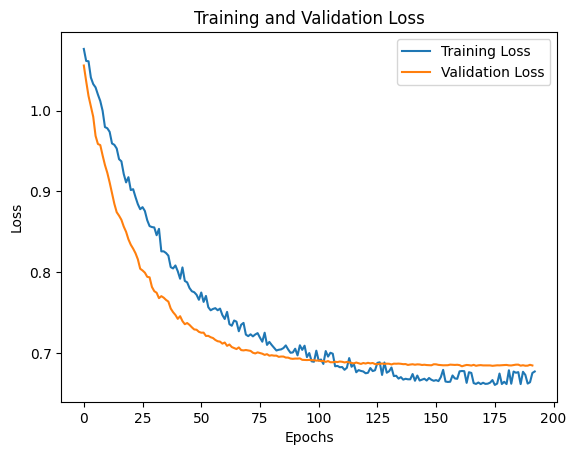

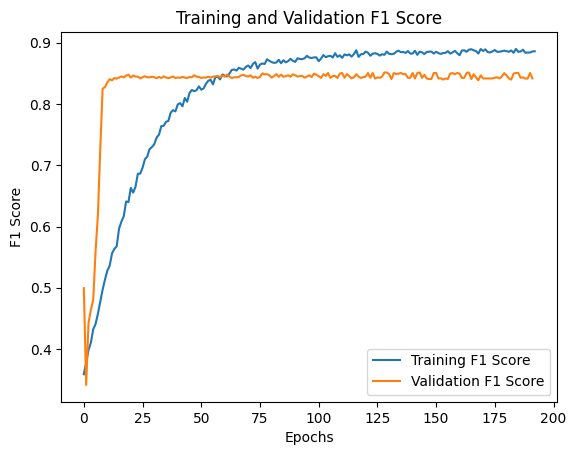

In [ ]:
# Initialize MetaClassifier and move to device
CNN_1D = CNN_1d().to(device)

# HP definition
num_epochs = 200
batch_size = 256
lr = 1e-5
weight_decay = 1e-3
model_path = "CNN.pth"

# Training loop
train_metaclassifier(CNN_1D, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

A bit of overfitting can be seen by means of the two plots above. The model's generalization capabilities seems to find a plateau pretty early in the training loop, but this is probably due to the simplicity of the input tensor.

In [ ]:
CNN_model = CNN_1d()
CNN_model.load_state_dict(torch.load(model_path))
CNN_model = CNN_model.to(device)

evaluate_metaclassifier(CNN_model, test_dataset)


Test Loss: 0.6498988608519236
Test Macro F1 Score: 0.8853032061403617
Test Weighted F1 Score: [0.90094746 0.91189647 0.84306569]
Test Accuracy: 0.8983324367939752


As you can see above we have surpassed the previous top models results.